In [3]:
# Enze Xu
# Github: https://github.com/EnzeXu/PINN
# git clone https://github.com/EnzeXu/PINN.git

import torch
import time
import random
import argparse
import math
import os
import numpy as np
import matplotlib.pyplot as plt
from torch import nn, optim
from tqdm import tqdm
from collections import OrderedDict
from torchsummary import summary
from torch.backends import cudnn
from mpl_toolkits.mplot3d import Axes3D

from google.colab import drive
import sys
drive.mount("/content/drive")

main_path = '/content/drive/My Drive/Workspace/PINN/' # ENZE marked: you need to change your main_path if it's not here
sys.path.append(main_path)
from cyclic_lr_scheduler import CyclicLR

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
class ConfigPP:
    T = 20.0
    T_unit = 0.001
    N = int(T / T_unit)
    U_start = 10.0
    V_start = 5.0
    alpha = 1.0
    beta = 3.0
    gamma = 0.3
    e = 0.333
    ub = T
    lb = 0.0

class SimpleNetworkPP(nn.Module):
    def __init__(self, config):
        super(SimpleNetworkPP, self).__init__()
        self.setup_seed(0)
        self.config = config
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.x, self.y0, self.t0 = None, None, None
        self.generate_x()
        self.initial_start()
        self.model_name = "SimpleNetworkPP"
        self.act = nn.Tanh()

        # A
        self.fc1 = nn.Sequential(OrderedDict({
            'lin1': nn.Linear(1, 100),
            'activation1': self.act,
            'lin2': nn.Linear(100, 100),
            'activation2': self.act,
            'lin3': nn.Linear(100, 100),
            'activation3': self.act,
            'lin4': nn.Linear(100, 100),#
            'activation4': self.act,#
            # 'lin5': nn.Linear(100, 100),#
            # 'activation5': self.act,#
            'lin6': nn.Linear(100, 1),
            # 'activation5': nn.ReLU(),
        }))

        self.fc2 = nn.Sequential(OrderedDict({
            'lin1': nn.Linear(1, 100),
            'activation1': self.act,
            'lin2': nn.Linear(100, 100),
            'activation2': self.act,
            'lin3': nn.Linear(100, 100),
            'activation3': self.act,
            'lin4': nn.Linear(100, 100),#
            'activation4': self.act,#
            # 'lin5': nn.Linear(100, 100),#
            # 'activation5': self.act,#
            'lin6': nn.Linear(100, 1),
            # 'activation5': nn.ReLU(),
        }))

        # B
        # self.fc_start1 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(1, 100),
        #     'activation1': self.act,
        # }))

        # self.fc_start2 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(1, 100),
        #     'activation1': self.act,
        # }))

        # self.fc_end1 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(100, 1),
        #     # 'activation1': self.act,
        # }))

        # self.fc_end2 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(100, 1),
        #     # 'activation1': self.act,
        # }))

        # self.fc_middle = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(200, 200),
        #     'activation1': self.act,
        #     'lin2': nn.Linear(200, 200),
        #     'activation2': self.act,
        # }))

    def forward(self, inputs):
        # A
        u_old, v_old = torch.chunk(inputs, 2, 1)
        u_new = self.fc1(u_old)
        v_new = self.fc2(v_old)
        outputs = torch.cat((u_new, v_new), 1)

        # B
        # u_old, v_old = torch.chunk(inputs, 2, 1)
        # u_middle = self.fc_start1(u_old)
        # v_middle = self.fc_start2(v_old)
        # middle_input = torch.cat((u_middle, v_middle), 1)
        # middle_output = self.fc_middle(middle_input)
        # middle_output_chunk = torch.chunk(middle_output, 2, 1)
        # u_end_input, v_end_input = middle_output_chunk[0], middle_output_chunk[1]
        # u_new = self.fc_end1(u_end_input)
        # v_new = self.fc_end2(v_end_input)
        # outputs = torch.cat((u_new, v_new), 1)
        return outputs

    def generate_x(self):
        # lb_row = np.repeat(self.config.lb, 2).reshape([1, -1])
        # ub_row = np.repeat(self.config.ub, 2).reshape([1, -1])
        # x = lb_row + (ub_row - lb_row) * lhs(1, self.config.N)
        # x = sorted(x, key=lambda xx: xx[0])
        x = [[i*self.config.T_unit, i*self.config.T_unit] for i in range(self.config.N)]  # toy
        x = np.asarray(x)
        x = self.encode_t(x)
        self.x = torch.Tensor(x).float().to(self.device)

    def initial_start(self):
        self.t0 = torch.Tensor(np.asarray([-1.0, -1.0]).reshape([1, -1])).float().to(self.device)
        # self.y0 = torch.Tensor(np.asarray([0.0, 0.0]).reshape([1, -1])).float().to(self.device)
        self.y0 = torch.Tensor(np.asarray([self.config.U_start, self.config.V_start]).reshape([1, -1])).float().to(self.device)

    def loss(self):
        self.eval()
        y = self.decode_y(self.forward(self.x))
        y0_pred = self.decode_y(self.forward(self.encode_y(self.t0)))
        # print("y.shape:", y[:, 0:1].shape)
        # print(y[:, 0:1])
        # print("self.x.shape:", self.x[:, 0:1].shape)
        # y_t = torch.gradient(y, spacing=(self.x,))[0]  # y_t = tf.gradients(y, t)[0]
        u = y[:, 0:1]
        v = y[:, 1:2]

        u_t = torch.gradient(y[:, 0:1].reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.N]),))[0]  # u_t = y_t[:, 0:1]
        v_t = torch.gradient(y[:, 1:2].reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 1:2].reshape([self.config.N]),))[0]  # y_t[:, 1:2]
        u_t = u_t.reshape([self.config.N, 1])
        v_t = v_t.reshape([self.config.N, 1])
        # print(y_t,u_t)
        f_u = u_t - (self.config.alpha - self.config.gamma * v) * u    # nn model
        f_v = v_t - (-self.config.beta + self.config.e * self.config.gamma * u) * v    # nn model
        # f_u = u_t - torch.cos(self.decode_t(self.x)[:, 0:1])
        # f_v = v_t - torch.cos(self.decode_t(self.x)[:, 1:2])
        f_y = torch.cat((f_u, f_v), 1)

        # print((self.decode_t(self.x)[:, 0:1].reshape([self.config.N]),).shape)
        # print(u_t.shape)

        # u_tt = torch.gradient(u_t, spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.N]),))[0]
        # v_tt = torch.gradient(v_t, spacing=(self.decode_t(self.x)[:, 1:2].reshape([self.config.N]),))[0]
        
        # print_flag = False  # True # False
        # if print_flag:
        #     print("u=", u.shape, u, "v=", v.shape, v, "t=", (self.decode_t(self.x)[:, 0:1]).shape, self.decode_t(self.x)[:, 0:1])
        #     print("u_t=", u_t, "shape=", u_t.shape, "u_t_minus=", (self.config.alpha - self.config.gamma * v) * u,
        #           "shape=", ((self.config.alpha - self.config.gamma * v) * u).shape)
        #     print("v_t=", v_t, "shape=", v_t.shape, "v_t_minus=",
        #           (-self.config.beta + self.config.e * self.config.gamma * u) * v, "shape=",
        #           ((-self.config.beta + self.config.e * self.config.gamma * u) * v).shape)
        #     print("self.t0 =", self.t0, "self.encode_y(self.t0)=", self.encode_y(self.t0), "self.y0 =", self.y0,
        #           "y0_pred =", y0_pred, "self.y0 - y0_pred =", self.y0 - y0_pred)

        # loss_2_weights = [[i, i] for i in range(20000)]  # toy
        # loss_2_weights = np.asarray(loss_2_weights)
        # loss_2_weights = torch.Tensor(loss_2_weights).float().to(self.device)

        loss_1 = torch.mean(torch.square(self.y0 - y0_pred))
        loss_2 = torch.mean(torch.square(f_y))  # + torch.var(torch.square(f_y))
        loss_3 = torch.mean(torch.square((0.1/(u * u + v * v + 1e-12)))) + torch.mean(torch.square((torch.abs(u) - u))) + torch.mean(torch.square((torch.abs(v) - v)))
        # loss_3 = torch.mean(torch.square(1.0 / u - (self.config.e * self.config.gamma / self.config.beta))) + \
        #     torch.mean(torch.square(1.0 / v - (self.config.gamma / self.config.alpha)))
        # loss_3 = torch.mean(torch.square((torch.abs(u) - u)))

        # loss_3 = torch.mean(torch.square((1/(u * u+ 1e-12)))) + torch.mean(torch.square((1/(v * v + 1e-12)))) + torch.mean((torch.abs(u) - u)) + torch.mean((torch.abs(v) - v))

        # loss_3 = torch.mean(torch.square((1/(u * u + v * v)))) + torch.mean((torch.abs(u) - u)) + torch.mean((torch.abs(v) - v))  # torch.mean(torch.square((1/(u * u + v * v + 1e-12)))) + torch.mean((torch.abs(u) - u)) + torch.mean((torch.abs(v) - v))
        # loss_4 = torch.mean(0.001 / (torch.abs(u_t)+1e-8)) + torch.mean(0.001 / (torch.abs(v_t)+1e-8))
        # loss_5 = torch.mean(0.001 / (torch.abs(u_tt)+1e-8)) + torch.mean(0.001 / (torch.abs(v_tt)+1e-8))
        loss = (loss_1 + loss_2 + loss_3 )#+ loss_4 + loss_5) / 1e5
        # if loss < 2.0:
        #     f_y_square_pure = torch.square(f_y).cpu().detach().numpy()
        #     for i in range(20000):
        #         print(i, f_y_square_pure[i])
        self.train()
        return loss, [loss_1, loss_2, loss_3]
        # return torch.mean(torch.square(y_hat - y))
        # return F.mse_loss(torch.cat((u_hat, v_hat), 1), torch.cat((u, v), 1))
        # return torch.abs(u_hat - u) + torch.abs(v_hat - v)  # F.mse_loss(x_hat, x) + beta * self.kl_div(rho)

    def encode_y(self, num):
        return num
        # return (num - self.config.y_lb) / (self.config.y_ub - self.config.y_lb) * 2.0 - 1.0

    def decode_y(self, num):
        return num
        # return self.config.y_lb + (num + 1.0) / 2.0 * (self.config.y_ub - self.config.y_lb)

    def encode_t(self, num):
        return (num - self.config.lb) / (self.config.ub - self.config.lb) * 2.0 - 1.0

    def decode_t(self, num):
        return self.config.lb + (num + 1.0) / 2.0 * (self.config.ub - self.config.lb)

    @staticmethod
    def setup_seed(seed):
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        np.random.seed(seed)
        random.seed(seed)
        cudnn.deterministic = True



In [53]:
def get_model_parameters(model, config):
    parameters = my_summary(model, (config.N, 1))
    return parameters


def get_now_string():
    return time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime(time.time()))


def draw_loss(loss_list):
    map = np.asarray([[loss] for loss in loss_list])
    plt.plot(map)
    plt.show()
    plt.clf()

# optimizer = optim.LBFGS(model.parameters(), lr=1, max_iter=20, max_eval=None, tolerance_grad=1e-07, tolerance_change=1e-09, history_size=100, line_search_fn=None)

def train_pp(model, args, config, now_string):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # model = model_framework(config).to(device)
    model.train()
    model_save_path_last = f"{args.main_path}/train/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{config.alpha}_{config.beta}_{config.gamma}_{config.e}_{now_string}_last.pt"
    model_save_path_best = f"{args.main_path}/train/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{config.alpha}_{config.beta}_{config.gamma}_{config.e}_{now_string}_best.pt"
    loss_save_path = f"{args.main_path}/loss/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{config.alpha}_{config.beta}_{config.gamma}_{config.e}_{now_string}_loss_{args.epoch}.npy"
    print("using " + str(device))
    print("epoch = {}".format(args.epoch))
    print("epoch_step = {}".format(args.epoch_step))
    print("model_name = {}".format(model.model_name))
    print("now_string = {}".format(now_string))
    print("model_save_path_last = {}".format(model_save_path_last))
    print("model_save_path_best = {}".format(model_save_path_best))
    print("loss_save_path = {}".format(loss_save_path))
    print("args = {}".format({item[0]: item[1] for item in args.__dict__.items() if item[0][0] != "_"}))
    print("config = {}".format({item[0]: item[1] for item in config.__dict__.items() if item[0][0] != "_"}))
    # optimizer = optim.Adam(model.parameters(), lr=args.lr)
    initial_lr = args.lr
    optimizer = optim.Adam(model.parameters(), lr = initial_lr)

    #scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 1/(epoch/10000+1)) # decade
    scheduler = CyclicLR(optimizer, base_lr=0.001, max_lr=0.01, step_size=10000) # cyclic
    epoch_step = args.epoch_step
    start_time = time.time()
    start_time_0 = start_time
    best_loss = 999999
    now_time = 0
    loss_record = []
    def closure():
        optimizer.zero_grad()
        inputs = model.x
        outputs = model(inputs)
        loss, loss_list = model.loss()
        return loss
    for epoch in range(1, args.epoch + 1):
        optimizer.zero_grad()
        inputs = model.x
        outputs = model(inputs)
        loss, loss_list = model.loss()
        
        loss_1, loss_2, loss_3 = loss_list[0], loss_list[1], loss_list[2]
        loss.backward()
        # options = {'closure': closure, 'current_loss': loss, 'max_ls': 10}
        # _loss, _, lr, _, F_eval, G_eval, _, _ = optimizer.step(closure)
        optimizer.step()
        scheduler.step()
        loss_record.append(float(loss.item()))
        if epoch % epoch_step == 0:
            now_time = time.time()
            print("Epoch [{0:05d}/{1:05d}] Loss:{2:.6f} Loss_1:{3:.6f} Loss_2:{4:.6f} Loss_3: {5:.6f} Lr:{6:.6f} Time:{7:.6f}s ({8:.2f}min in total)".format(epoch, args.epoch, loss.item(), loss_1.item(), loss_2.item(), loss_3.item(), optimizer.param_groups[0]["lr"], now_time - start_time, (now_time - start_time_0) / 60.0))
            start_time = time.time()
            torch.save(
                {
                    'epoch': args.epoch,
                    'model_state_dict': model.state_dict(),
                    # 'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss.item()
                }, model_save_path_last)
            # print(inputs.shape)
            if loss.item() < best_loss:
                best_loss = loss.item()
                torch.save(
                    {
                        'epoch': args.epoch,
                        'model_state_dict': model.state_dict(),
                        # 'optimizer_state_dict': optimizer.state_dict(),
                        'loss': loss.item()
                    }, model_save_path_best)
        if epoch % args.save_step == 0:
            test_pp(model, args, config, now_string, True)
            draw_loss(np.asarray(loss_record))
    
    num_parameter = -1  # get_model_parameters(model, config)
    best_loss = best_loss
    time_cost = (now_time - start_time_0) / 60.0
    loss_record = np.asarray(loss_record)
    np.save(loss_save_path, loss_record)
    draw_loss(loss_record)
    return [num_parameter, best_loss, time_cost, loss_record]


def test_pp(model, args, config, now_string, show_flag=True):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # model = model_framework(config).to(device)
    model_save_path = f"{args.main_path}/train/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{config.alpha}_{config.beta}_{config.gamma}_{config.e}_{now_string}_last.pt"
    model.load_state_dict(torch.load(model_save_path, map_location=device)["model_state_dict"])
    model.eval()
    print("Testing & drawing...")
    t = model.x
    y = model(t)
    y0_pred = model(model.t0)
    # print("t=", t)
    # print("t0=", model.t0)
    # print("y=", y)
    # print("y0_pred=", y0_pred)
    u, v = torch.chunk(y, 2, 1)
    # print("u=", u)
    # print("v=", v)
    u = model.decode_y(u)
    v = model.decode_y(v)
    u = [item[0] for item in u.cpu().detach().numpy()]
    v = [item[0] for item in v.cpu().detach().numpy()]
    x = [item[0] for item in model.decode_t(t).cpu().detach().numpy()]
    pairs = [[uu, vv, xx] for uu, vv, xx in zip(u, v, x)]
    pairs.sort(key=lambda xx: xx[2])
    u = [item[0] for item in pairs]
    v = [item[1] for item in pairs]
    x = [item[2] for item in pairs]
    print("u=", u[:10], "...", u[-10:])
    print("v=", v[:10], "...", v[-10:])
    print("x=", x[:10], "...", x[-10:])
    plt.plot(x, u, marker='.', markersize=0.2, linewidth=0.1, c="b")
    plt.plot(x, v, marker='.', markersize=0.2, linewidth=0.1, c="r")
    figure_save_path = f"{args.main_path}/figure/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{config.alpha}_{config.beta}_{config.gamma}_{config.e}_{now_string}_{int(time.time())}.png"
    plt.savefig(figure_save_path, dpi=300)
    if show_flag:
        plt.show()
    plt.clf()
    print("Saved as {}".format(figure_save_path))

class Args:
    epoch = 100000
    epoch_step = 1000
    lr = 0.01
    main_path = "."
    save_step = 10000

def run_pp(main_path=None):
    # parser = argparse.ArgumentParser()
    # parser.add_argument("--epoch", type=int, default=1000, help="epoch")
    # parser.add_argument("--epoch_step", type=int, default=10, help="epoch_step")
    # parser.add_argument('--lr', type=float, default=0.01, help='learning rate, default=0.001')
    # parser.add_argument("--main_path", default=".", help="main_path")
    # parser.add_argument("--save_step", type=int, default=10, help="save_step")
    # args = parser.parse_args()
    args = Args
    if main_path:
        args.main_path = main_path
    if not os.path.exists("{}/train".format(args.main_path)):
        os.makedirs("{}/train".format(args.main_path))
    if not os.path.exists("{}/figure".format(args.main_path)):
        os.makedirs("{}/figure".format(args.main_path))
    if not os.path.exists("{}/loss".format(args.main_path)):
        os.makedirs("{}/loss".format(args.main_path))
    now_string = get_now_string()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    config = ConfigPP
    model = SimpleNetworkPP(config).to(device)
    res_list = train_pp(model, args, config, now_string)

    print("\n[Training Summary]")
    print("num_parameter: {}".format(res_list[0]))
    print("best_loss: {}".format(res_list[1]))
    print("time_cost: {}".format(res_list[2]))
    # model = SimpleNetworkPP(config).to(device)
    # test_pp(model, args, config, now_string)

using cuda
epoch = 100000
epoch_step = 1000
model_name = SimpleNetworkPP
now_string = 2022-04-22-01-07-17
model_save_path_last = /content/drive/My Drive/Workspace/PINN/train/SimpleNetworkPP_100000_1000_0.01_1.0_3.0_0.3_0.333_2022-04-22-01-07-17_last.pt
model_save_path_best = /content/drive/My Drive/Workspace/PINN/train/SimpleNetworkPP_100000_1000_0.01_1.0_3.0_0.3_0.333_2022-04-22-01-07-17_best.pt
loss_save_path = /content/drive/My Drive/Workspace/PINN/loss/SimpleNetworkPP_100000_1000_0.01_1.0_3.0_0.3_0.333_2022-04-22-01-07-17_loss_100000.npy
args = {'epoch': 100000, 'epoch_step': 1000, 'lr': 0.01, 'main_path': '/content/drive/My Drive/Workspace/PINN', 'save_step': 10000}
config = {'T': 20.0, 'T_unit': 0.001, 'N': 20000, 'U_start': 10.0, 'V_start': 5.0, 'alpha': 1.0, 'beta': 3.0, 'gamma': 0.3, 'e': 0.333, 'ub': 20.0, 'lb': 0.0}
Epoch [01000/100000] Loss:15.108110 Loss_1:0.039361 Loss_2:15.068748 Loss_3: 0.000001 Lr:0.001899 Time:9.105682s (0.15min in total)
Epoch [02000/100000] Loss:5.4

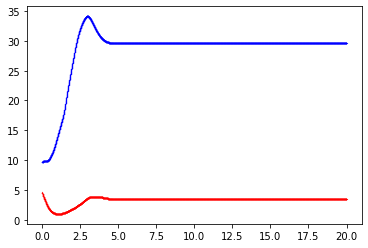

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_100000_1000_0.01_1.0_3.0_0.3_0.333_2022-04-22-01-07-17_1650589729.png


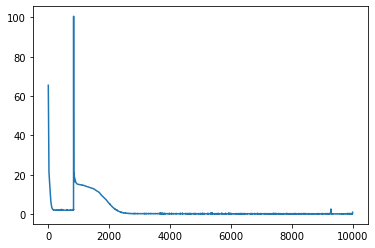

Epoch [11000/100000] Loss:0.156635 Loss_1:0.001595 Loss_2:0.155040 Loss_3: 0.000000 Lr:0.009101 Time:9.685471s (1.68min in total)
Epoch [12000/100000] Loss:0.209967 Loss_1:0.001541 Loss_2:0.208426 Loss_3: 0.000000 Lr:0.008201 Time:9.091610s (1.83min in total)
Epoch [13000/100000] Loss:0.150487 Loss_1:0.000533 Loss_2:0.149954 Loss_3: 0.000000 Lr:0.007301 Time:9.105075s (1.99min in total)
Epoch [14000/100000] Loss:0.133385 Loss_1:0.003963 Loss_2:0.129421 Loss_3: 0.000000 Lr:0.006401 Time:9.109967s (2.14min in total)
Epoch [15000/100000] Loss:0.130857 Loss_1:0.000190 Loss_2:0.130666 Loss_3: 0.000000 Lr:0.005501 Time:9.137249s (2.29min in total)
Epoch [16000/100000] Loss:0.116301 Loss_1:0.001848 Loss_2:0.114452 Loss_3: 0.000000 Lr:0.004601 Time:9.101289s (2.44min in total)
Epoch [17000/100000] Loss:0.100924 Loss_1:0.000029 Loss_2:0.100894 Loss_3: 0.000000 Lr:0.003701 Time:9.111147s (2.59min in total)
Epoch [18000/100000] Loss:0.083873 Loss_1:0.000090 Loss_2:0.083783 Loss_3: 0.000000 Lr:0.0

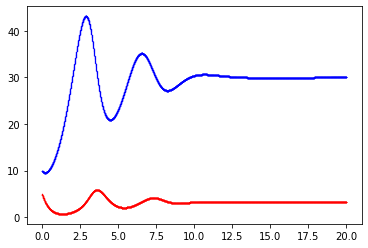

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_100000_1000_0.01_1.0_3.0_0.3_0.333_2022-04-22-01-07-17_1650589820.png


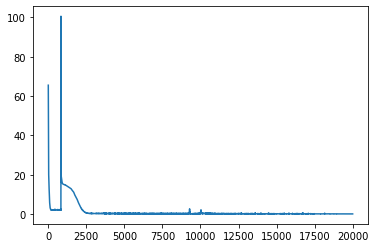

Epoch [21000/100000] Loss:0.064773 Loss_1:0.000013 Loss_2:0.064760 Loss_3: 0.000000 Lr:0.001899 Time:9.804805s (3.21min in total)
Epoch [22000/100000] Loss:0.067609 Loss_1:0.000330 Loss_2:0.067279 Loss_3: 0.000000 Lr:0.002799 Time:9.114292s (3.36min in total)
Epoch [23000/100000] Loss:0.079976 Loss_1:0.000889 Loss_2:0.079087 Loss_3: 0.000000 Lr:0.003699 Time:9.101839s (3.52min in total)
Epoch [24000/100000] Loss:0.092913 Loss_1:0.000927 Loss_2:0.091986 Loss_3: 0.000000 Lr:0.004599 Time:9.110321s (3.67min in total)
Epoch [25000/100000] Loss:0.091705 Loss_1:0.000294 Loss_2:0.091410 Loss_3: 0.000000 Lr:0.005499 Time:9.099871s (3.82min in total)
Epoch [26000/100000] Loss:0.074610 Loss_1:0.000109 Loss_2:0.074502 Loss_3: 0.000000 Lr:0.006399 Time:9.099087s (3.97min in total)
Epoch [27000/100000] Loss:0.138390 Loss_1:0.001785 Loss_2:0.136605 Loss_3: 0.000000 Lr:0.007299 Time:9.094810s (4.12min in total)
Epoch [28000/100000] Loss:0.123520 Loss_1:0.017601 Loss_2:0.105919 Loss_3: 0.000000 Lr:0.0

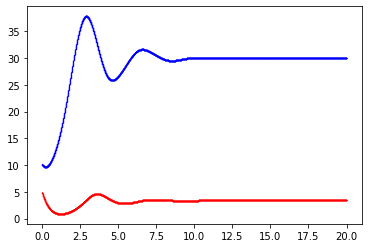

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_100000_1000_0.01_1.0_3.0_0.3_0.333_2022-04-22-01-07-17_1650589914.png


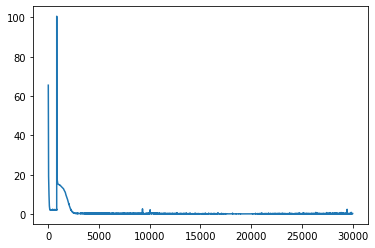

Epoch [31000/100000] Loss:0.095407 Loss_1:0.000393 Loss_2:0.095015 Loss_3: 0.000000 Lr:0.009101 Time:9.749628s (4.77min in total)
Epoch [32000/100000] Loss:0.138322 Loss_1:0.003530 Loss_2:0.134792 Loss_3: 0.000000 Lr:0.008201 Time:9.096061s (4.92min in total)
Epoch [33000/100000] Loss:0.109358 Loss_1:0.001810 Loss_2:0.107548 Loss_3: 0.000000 Lr:0.007301 Time:9.352411s (5.07min in total)
Epoch [34000/100000] Loss:0.079152 Loss_1:0.000694 Loss_2:0.078458 Loss_3: 0.000000 Lr:0.006401 Time:9.586709s (5.23min in total)
Epoch [35000/100000] Loss:0.090249 Loss_1:0.000977 Loss_2:0.089272 Loss_3: 0.000000 Lr:0.005501 Time:9.076783s (5.38min in total)
Epoch [36000/100000] Loss:0.124549 Loss_1:0.002289 Loss_2:0.122260 Loss_3: 0.000000 Lr:0.004601 Time:9.274315s (5.54min in total)
Epoch [37000/100000] Loss:0.067161 Loss_1:0.000038 Loss_2:0.067123 Loss_3: 0.000000 Lr:0.003701 Time:10.255848s (5.71min in total)
Epoch [38000/100000] Loss:0.060600 Loss_1:0.000047 Loss_2:0.060553 Loss_3: 0.000000 Lr:0.

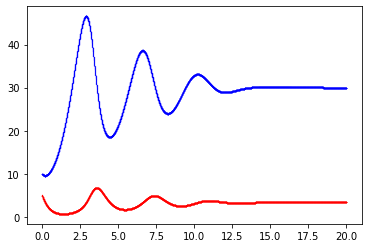

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_100000_1000_0.01_1.0_3.0_0.3_0.333_2022-04-22-01-07-17_1650590010.png


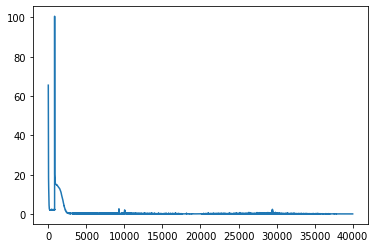

Epoch [41000/100000] Loss:0.060567 Loss_1:0.000240 Loss_2:0.060327 Loss_3: 0.000000 Lr:0.001899 Time:10.724505s (6.39min in total)
Epoch [42000/100000] Loss:0.149019 Loss_1:0.000439 Loss_2:0.148580 Loss_3: 0.000000 Lr:0.002799 Time:9.900572s (6.55min in total)
Epoch [43000/100000] Loss:0.060903 Loss_1:0.000520 Loss_2:0.060383 Loss_3: 0.000000 Lr:0.003699 Time:9.692467s (6.72min in total)
Epoch [44000/100000] Loss:0.087497 Loss_1:0.001623 Loss_2:0.085874 Loss_3: 0.000000 Lr:0.004599 Time:9.076161s (6.87min in total)
Epoch [45000/100000] Loss:0.084822 Loss_1:0.000642 Loss_2:0.084181 Loss_3: 0.000000 Lr:0.005499 Time:9.067529s (7.02min in total)
Epoch [46000/100000] Loss:0.097590 Loss_1:0.007281 Loss_2:0.090309 Loss_3: 0.000000 Lr:0.006399 Time:9.056847s (7.17min in total)
Epoch [47000/100000] Loss:0.080325 Loss_1:0.000330 Loss_2:0.079995 Loss_3: 0.000000 Lr:0.007299 Time:9.062864s (7.32min in total)
Epoch [48000/100000] Loss:0.099280 Loss_1:0.000291 Loss_2:0.098988 Loss_3: 0.000000 Lr:0.

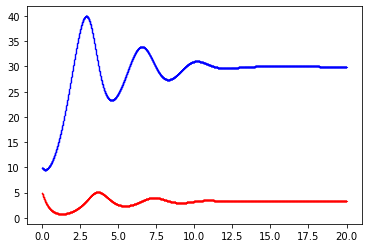

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_100000_1000_0.01_1.0_3.0_0.3_0.333_2022-04-22-01-07-17_1650590104.png


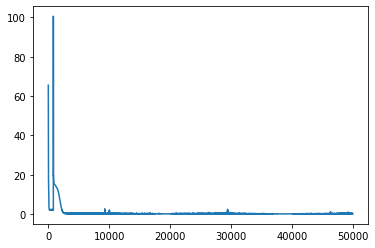

Epoch [51000/100000] Loss:0.084615 Loss_1:0.001859 Loss_2:0.082756 Loss_3: 0.000000 Lr:0.009101 Time:10.213833s (7.95min in total)
Epoch [52000/100000] Loss:0.099161 Loss_1:0.004032 Loss_2:0.095129 Loss_3: 0.000000 Lr:0.008201 Time:9.046128s (8.10min in total)
Epoch [53000/100000] Loss:0.075780 Loss_1:0.000457 Loss_2:0.075324 Loss_3: 0.000000 Lr:0.007301 Time:9.060878s (8.25min in total)
Epoch [54000/100000] Loss:0.070144 Loss_1:0.000382 Loss_2:0.069763 Loss_3: 0.000000 Lr:0.006401 Time:9.039157s (8.40min in total)
Epoch [55000/100000] Loss:0.073780 Loss_1:0.000459 Loss_2:0.073320 Loss_3: 0.000000 Lr:0.005501 Time:9.049654s (8.55min in total)
Epoch [56000/100000] Loss:0.070648 Loss_1:0.000059 Loss_2:0.070589 Loss_3: 0.000000 Lr:0.004601 Time:9.052038s (8.70min in total)
Epoch [57000/100000] Loss:0.060755 Loss_1:0.000290 Loss_2:0.060466 Loss_3: 0.000000 Lr:0.003701 Time:9.045833s (8.85min in total)
Epoch [58000/100000] Loss:0.055451 Loss_1:0.000007 Loss_2:0.055443 Loss_3: 0.000000 Lr:0.

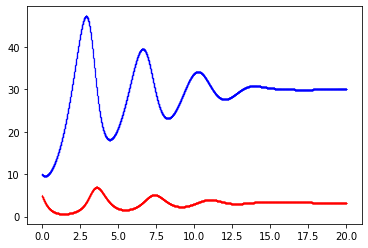

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_100000_1000_0.01_1.0_3.0_0.3_0.333_2022-04-22-01-07-17_1650590196.png


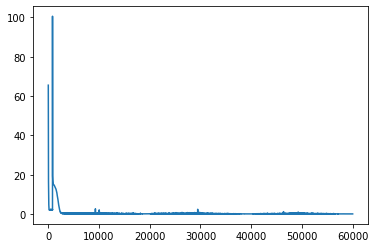

Epoch [61000/100000] Loss:0.047647 Loss_1:0.000002 Loss_2:0.047644 Loss_3: 0.000000 Lr:0.001899 Time:9.822425s (9.47min in total)
Epoch [62000/100000] Loss:0.056028 Loss_1:0.000098 Loss_2:0.055930 Loss_3: 0.000000 Lr:0.002799 Time:9.074341s (9.62min in total)
Epoch [63000/100000] Loss:0.073212 Loss_1:0.000362 Loss_2:0.072850 Loss_3: 0.000000 Lr:0.003699 Time:9.064574s (9.77min in total)
Epoch [64000/100000] Loss:0.056668 Loss_1:0.000656 Loss_2:0.056011 Loss_3: 0.000000 Lr:0.004599 Time:9.046711s (9.92min in total)
Epoch [65000/100000] Loss:0.059864 Loss_1:0.000085 Loss_2:0.059778 Loss_3: 0.000000 Lr:0.005499 Time:9.082860s (10.07min in total)
Epoch [66000/100000] Loss:0.181578 Loss_1:0.005706 Loss_2:0.175872 Loss_3: 0.000000 Lr:0.006399 Time:9.070634s (10.22min in total)
Epoch [67000/100000] Loss:0.111664 Loss_1:0.000423 Loss_2:0.111241 Loss_3: 0.000000 Lr:0.007299 Time:9.075952s (10.37min in total)
Epoch [68000/100000] Loss:0.108352 Loss_1:0.001231 Loss_2:0.107121 Loss_3: 0.000000 Lr:

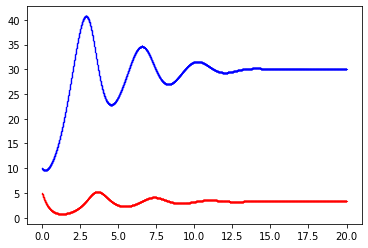

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_100000_1000_0.01_1.0_3.0_0.3_0.333_2022-04-22-01-07-17_1650590287.png


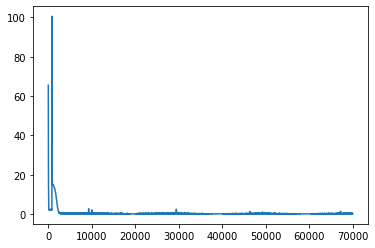

Epoch [71000/100000] Loss:0.081340 Loss_1:0.001683 Loss_2:0.079657 Loss_3: 0.000000 Lr:0.009101 Time:9.779321s (10.99min in total)
Epoch [72000/100000] Loss:0.100952 Loss_1:0.003323 Loss_2:0.097630 Loss_3: 0.000000 Lr:0.008201 Time:9.041904s (11.14min in total)
Epoch [73000/100000] Loss:0.177901 Loss_1:0.001000 Loss_2:0.176901 Loss_3: 0.000000 Lr:0.007301 Time:9.044202s (11.29min in total)
Epoch [74000/100000] Loss:0.071658 Loss_1:0.000687 Loss_2:0.070971 Loss_3: 0.000000 Lr:0.006401 Time:9.027043s (11.44min in total)
Epoch [75000/100000] Loss:0.060410 Loss_1:0.000042 Loss_2:0.060368 Loss_3: 0.000000 Lr:0.005501 Time:9.046580s (11.59min in total)
Epoch [76000/100000] Loss:0.060958 Loss_1:0.000007 Loss_2:0.060951 Loss_3: 0.000000 Lr:0.004601 Time:9.048394s (11.74min in total)
Epoch [77000/100000] Loss:0.057826 Loss_1:0.000359 Loss_2:0.057468 Loss_3: 0.000000 Lr:0.003701 Time:9.026623s (11.89min in total)
Epoch [78000/100000] Loss:0.051648 Loss_1:0.000372 Loss_2:0.051277 Loss_3: 0.000000

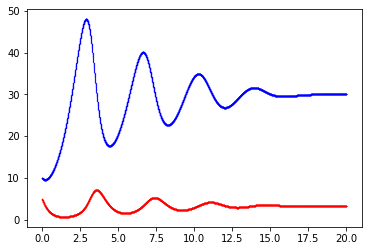

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_100000_1000_0.01_1.0_3.0_0.3_0.333_2022-04-22-01-07-17_1650590378.png


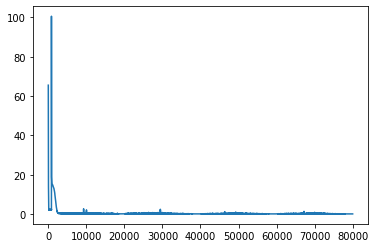

Epoch [81000/100000] Loss:0.060824 Loss_1:0.000788 Loss_2:0.060035 Loss_3: 0.000000 Lr:0.001899 Time:9.780992s (12.51min in total)
Epoch [82000/100000] Loss:0.045001 Loss_1:0.000095 Loss_2:0.044906 Loss_3: 0.000000 Lr:0.002799 Time:9.087607s (12.66min in total)
Epoch [83000/100000] Loss:0.052151 Loss_1:0.000248 Loss_2:0.051903 Loss_3: 0.000000 Lr:0.003699 Time:9.058950s (12.81min in total)
Epoch [84000/100000] Loss:0.059782 Loss_1:0.000772 Loss_2:0.059010 Loss_3: 0.000000 Lr:0.004599 Time:9.046987s (12.96min in total)
Epoch [85000/100000] Loss:0.060811 Loss_1:0.000509 Loss_2:0.060302 Loss_3: 0.000000 Lr:0.005499 Time:9.037171s (13.11min in total)
Epoch [86000/100000] Loss:0.143073 Loss_1:0.000370 Loss_2:0.142703 Loss_3: 0.000000 Lr:0.006399 Time:9.061313s (13.26min in total)
Epoch [87000/100000] Loss:0.076561 Loss_1:0.000321 Loss_2:0.076240 Loss_3: 0.000000 Lr:0.007299 Time:9.051926s (13.42min in total)
Epoch [88000/100000] Loss:0.062415 Loss_1:0.000121 Loss_2:0.062295 Loss_3: 0.000000

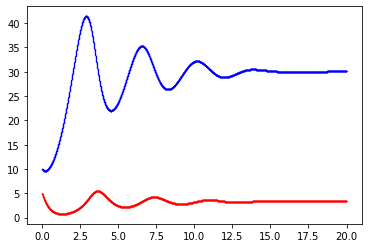

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_100000_1000_0.01_1.0_3.0_0.3_0.333_2022-04-22-01-07-17_1650590470.png


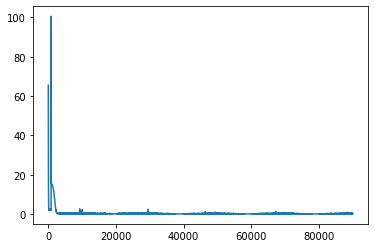

Epoch [91000/100000] Loss:0.093470 Loss_1:0.007390 Loss_2:0.086079 Loss_3: 0.000000 Lr:0.009101 Time:9.848106s (14.03min in total)
Epoch [92000/100000] Loss:0.088438 Loss_1:0.000050 Loss_2:0.088388 Loss_3: 0.000000 Lr:0.008201 Time:9.030455s (14.18min in total)
Epoch [93000/100000] Loss:0.064970 Loss_1:0.000327 Loss_2:0.064643 Loss_3: 0.000000 Lr:0.007301 Time:9.022512s (14.33min in total)
Epoch [94000/100000] Loss:0.058597 Loss_1:0.000058 Loss_2:0.058538 Loss_3: 0.000000 Lr:0.006401 Time:9.022186s (14.48min in total)
Epoch [95000/100000] Loss:0.063264 Loss_1:0.001154 Loss_2:0.062111 Loss_3: 0.000000 Lr:0.005501 Time:9.032260s (14.63min in total)
Epoch [96000/100000] Loss:0.065609 Loss_1:0.000699 Loss_2:0.064910 Loss_3: 0.000000 Lr:0.004601 Time:9.053029s (14.79min in total)
Epoch [97000/100000] Loss:0.051094 Loss_1:0.000173 Loss_2:0.050922 Loss_3: 0.000000 Lr:0.003701 Time:9.015158s (14.94min in total)
Epoch [98000/100000] Loss:0.048260 Loss_1:0.000036 Loss_2:0.048223 Loss_3: 0.000000

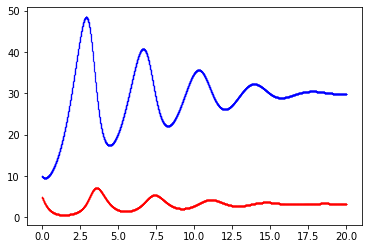

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_100000_1000_0.01_1.0_3.0_0.3_0.333_2022-04-22-01-07-17_1650590561.png


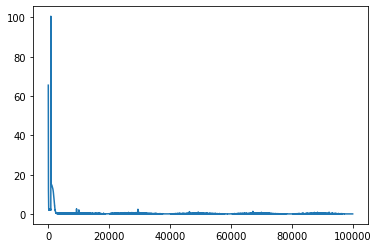

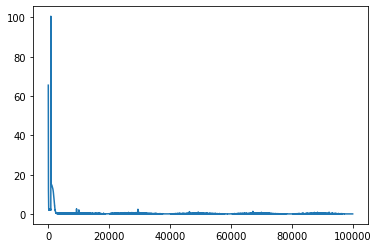


[Training Summary]
num_parameter: -1
best_loss: 0.04115523025393486
time_cost: 15.387340974807739


<Figure size 432x288 with 0 Axes>

In [54]:
# saved: design A - cyclic - Adam
main_path = "/content/drive/My Drive/Workspace/PINN"  # you may need to alter the path if it's not here
run_pp(main_path)

using cuda
epoch = 100000
epoch_step = 1000
model_name = SimpleNetworkPP
now_string = 2022-04-22-00-38-13
model_save_path_last = /content/drive/My Drive/Workspace/PINN/train/SimpleNetworkPP_100000_1000_0.01_1.0_3.0_0.3_0.333_2022-04-22-00-38-13_last.pt
model_save_path_best = /content/drive/My Drive/Workspace/PINN/train/SimpleNetworkPP_100000_1000_0.01_1.0_3.0_0.3_0.333_2022-04-22-00-38-13_best.pt
loss_save_path = /content/drive/My Drive/Workspace/PINN/loss/SimpleNetworkPP_100000_1000_0.01_1.0_3.0_0.3_0.333_2022-04-22-00-38-13_loss_100000.npy
args = {'epoch': 100000, 'epoch_step': 1000, 'lr': 0.01, 'main_path': '/content/drive/My Drive/Workspace/PINN', 'save_step': 10000}
config = {'T': 20.0, 'T_unit': 0.001, 'N': 20000, 'U_start': 10.0, 'V_start': 5.0, 'alpha': 1.0, 'beta': 3.0, 'gamma': 0.3, 'e': 0.333, 'ub': 20.0, 'lb': 0.0}
Epoch [01000/100000] Loss:0.220596 Loss_1:0.001257 Loss_2:0.219339 Loss_3: 0.000000 Lr:0.009091 Time:9.067259s (0.15min in total)
Epoch [02000/100000] Loss:0.322

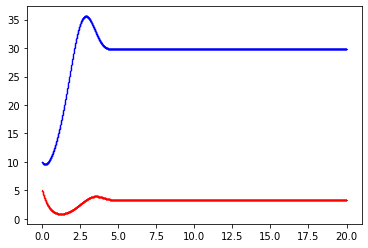

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_100000_1000_0.01_1.0_3.0_0.3_0.333_2022-04-22-00-38-13_1650587985.png


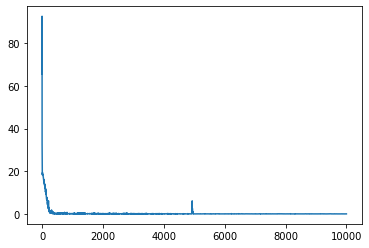

Epoch [11000/100000] Loss:0.160154 Loss_1:0.005582 Loss_2:0.154572 Loss_3: 0.000000 Lr:0.004762 Time:9.671555s (1.69min in total)
Epoch [12000/100000] Loss:0.173131 Loss_1:0.004693 Loss_2:0.168439 Loss_3: 0.000000 Lr:0.004545 Time:9.123409s (1.84min in total)
Epoch [13000/100000] Loss:0.148211 Loss_1:0.003312 Loss_2:0.144899 Loss_3: 0.000000 Lr:0.004348 Time:10.366973s (2.01min in total)
Epoch [14000/100000] Loss:0.108093 Loss_1:0.001486 Loss_2:0.106607 Loss_3: 0.000000 Lr:0.004167 Time:9.096850s (2.16min in total)
Epoch [15000/100000] Loss:0.129432 Loss_1:0.000707 Loss_2:0.128724 Loss_3: 0.000000 Lr:0.004000 Time:9.126422s (2.32min in total)
Epoch [16000/100000] Loss:0.117324 Loss_1:0.004406 Loss_2:0.112919 Loss_3: 0.000000 Lr:0.003846 Time:9.121150s (2.47min in total)
Epoch [17000/100000] Loss:0.108035 Loss_1:0.005075 Loss_2:0.102960 Loss_3: 0.000000 Lr:0.003704 Time:9.100910s (2.62min in total)
Epoch [18000/100000] Loss:0.079417 Loss_1:0.001112 Loss_2:0.078305 Loss_3: 0.000000 Lr:0.

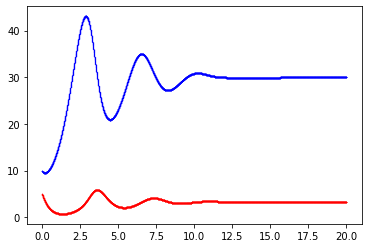

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_100000_1000_0.01_1.0_3.0_0.3_0.333_2022-04-22-00-38-13_1650588078.png


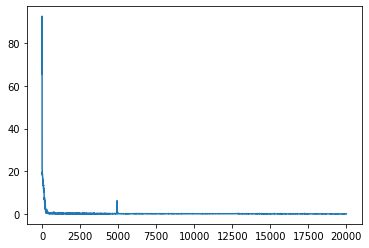

Epoch [21000/100000] Loss:0.065698 Loss_1:0.000866 Loss_2:0.064831 Loss_3: 0.000000 Lr:0.003226 Time:9.800238s (3.24min in total)
Epoch [22000/100000] Loss:0.111725 Loss_1:0.002775 Loss_2:0.108951 Loss_3: 0.000000 Lr:0.003125 Time:9.106930s (3.39min in total)
Epoch [23000/100000] Loss:0.070835 Loss_1:0.000222 Loss_2:0.070613 Loss_3: 0.000000 Lr:0.003030 Time:9.113290s (3.54min in total)
Epoch [24000/100000] Loss:0.061595 Loss_1:0.000045 Loss_2:0.061550 Loss_3: 0.000000 Lr:0.002941 Time:9.101893s (3.69min in total)
Epoch [25000/100000] Loss:0.058126 Loss_1:0.000003 Loss_2:0.058123 Loss_3: 0.000000 Lr:0.002857 Time:9.104064s (3.85min in total)
Epoch [26000/100000] Loss:0.062951 Loss_1:0.000573 Loss_2:0.062378 Loss_3: 0.000000 Lr:0.002778 Time:9.122637s (4.00min in total)
Epoch [27000/100000] Loss:0.056473 Loss_1:0.000136 Loss_2:0.056337 Loss_3: 0.000000 Lr:0.002703 Time:9.084438s (4.15min in total)
Epoch [28000/100000] Loss:0.053630 Loss_1:0.000020 Loss_2:0.053611 Loss_3: 0.000000 Lr:0.0

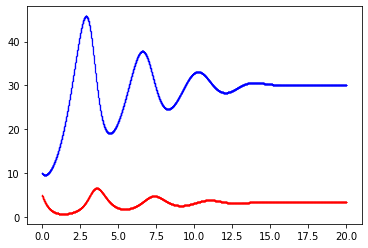

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_100000_1000_0.01_1.0_3.0_0.3_0.333_2022-04-22-00-38-13_1650588170.png


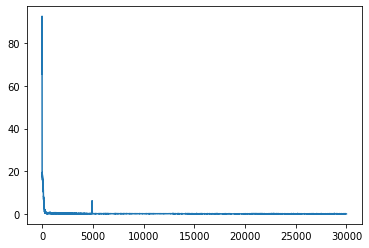

Epoch [31000/100000] Loss:0.066778 Loss_1:0.000073 Loss_2:0.066705 Loss_3: 0.000000 Lr:0.002439 Time:9.777157s (4.77min in total)
Epoch [32000/100000] Loss:0.051971 Loss_1:0.000017 Loss_2:0.051955 Loss_3: 0.000000 Lr:0.002381 Time:9.110078s (4.92min in total)
Epoch [33000/100000] Loss:0.058105 Loss_1:0.000529 Loss_2:0.057576 Loss_3: 0.000000 Lr:0.002326 Time:9.121824s (5.07min in total)
Epoch [34000/100000] Loss:0.056769 Loss_1:0.000158 Loss_2:0.056611 Loss_3: 0.000000 Lr:0.002273 Time:9.112106s (5.22min in total)
Epoch [35000/100000] Loss:0.061418 Loss_1:0.000286 Loss_2:0.061132 Loss_3: 0.000000 Lr:0.002222 Time:9.109356s (5.38min in total)
Epoch [36000/100000] Loss:0.047488 Loss_1:0.000007 Loss_2:0.047481 Loss_3: 0.000000 Lr:0.002174 Time:9.095055s (5.53min in total)
Epoch [37000/100000] Loss:0.068080 Loss_1:0.001225 Loss_2:0.066855 Loss_3: 0.000000 Lr:0.002128 Time:9.107469s (5.68min in total)
Epoch [38000/100000] Loss:0.046554 Loss_1:0.000013 Loss_2:0.046542 Loss_3: 0.000000 Lr:0.0

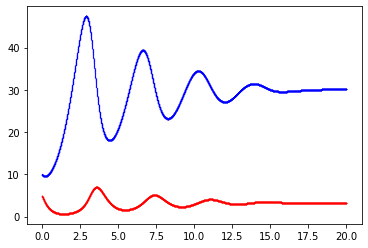

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_100000_1000_0.01_1.0_3.0_0.3_0.333_2022-04-22-00-38-13_1650588262.png


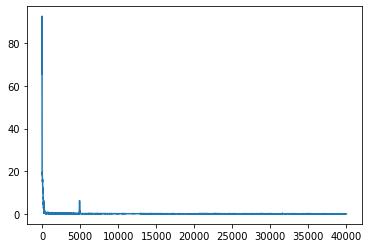

Epoch [41000/100000] Loss:0.046007 Loss_1:0.000004 Loss_2:0.046003 Loss_3: 0.000000 Lr:0.001961 Time:9.804999s (6.30min in total)
Epoch [42000/100000] Loss:0.107799 Loss_1:0.000762 Loss_2:0.107037 Loss_3: 0.000000 Lr:0.001923 Time:9.136735s (6.45min in total)
Epoch [43000/100000] Loss:0.144059 Loss_1:0.000270 Loss_2:0.143789 Loss_3: 0.000000 Lr:0.001887 Time:9.176966s (6.60min in total)
Epoch [44000/100000] Loss:0.050399 Loss_1:0.000073 Loss_2:0.050326 Loss_3: 0.000000 Lr:0.001852 Time:9.095539s (6.76min in total)
Epoch [45000/100000] Loss:0.043510 Loss_1:0.000007 Loss_2:0.043503 Loss_3: 0.000000 Lr:0.001818 Time:9.100306s (6.91min in total)
Epoch [46000/100000] Loss:0.042624 Loss_1:0.000005 Loss_2:0.042619 Loss_3: 0.000000 Lr:0.001786 Time:9.116831s (7.06min in total)
Epoch [47000/100000] Loss:0.042526 Loss_1:0.000021 Loss_2:0.042505 Loss_3: 0.000000 Lr:0.001754 Time:9.111280s (7.21min in total)
Epoch [48000/100000] Loss:0.043290 Loss_1:0.000000 Loss_2:0.043290 Loss_3: 0.000000 Lr:0.0

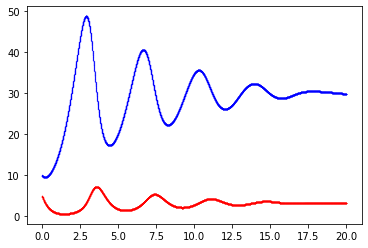

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_100000_1000_0.01_1.0_3.0_0.3_0.333_2022-04-22-00-38-13_1650588353.png


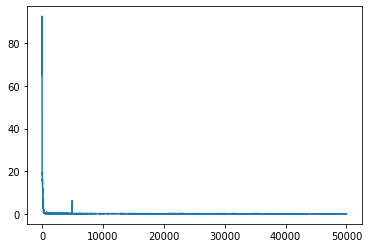

Epoch [51000/100000] Loss:0.040598 Loss_1:0.000004 Loss_2:0.040594 Loss_3: 0.000000 Lr:0.001639 Time:9.825943s (7.83min in total)
Epoch [52000/100000] Loss:0.040313 Loss_1:0.000009 Loss_2:0.040304 Loss_3: 0.000000 Lr:0.001613 Time:9.103752s (7.98min in total)
Epoch [53000/100000] Loss:0.045552 Loss_1:0.000193 Loss_2:0.045359 Loss_3: 0.000000 Lr:0.001587 Time:9.103495s (8.13min in total)
Epoch [54000/100000] Loss:0.039704 Loss_1:0.000007 Loss_2:0.039696 Loss_3: 0.000000 Lr:0.001563 Time:9.105839s (8.28min in total)
Epoch [55000/100000] Loss:0.043429 Loss_1:0.000141 Loss_2:0.043288 Loss_3: 0.000000 Lr:0.001538 Time:9.151094s (8.44min in total)
Epoch [56000/100000] Loss:0.041240 Loss_1:0.000103 Loss_2:0.041137 Loss_3: 0.000000 Lr:0.001515 Time:9.093132s (8.59min in total)
Epoch [57000/100000] Loss:0.039055 Loss_1:0.000004 Loss_2:0.039051 Loss_3: 0.000000 Lr:0.001493 Time:9.115808s (8.74min in total)
Epoch [58000/100000] Loss:0.039010 Loss_1:0.000014 Loss_2:0.038996 Loss_3: 0.000000 Lr:0.0

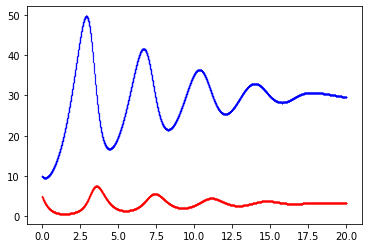

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_100000_1000_0.01_1.0_3.0_0.3_0.333_2022-04-22-00-38-13_1650588445.png


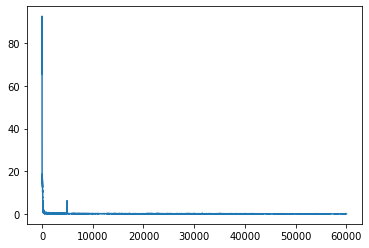

Epoch [61000/100000] Loss:0.039704 Loss_1:0.000074 Loss_2:0.039629 Loss_3: 0.000000 Lr:0.001408 Time:9.840966s (9.36min in total)
Epoch [62000/100000] Loss:0.104943 Loss_1:0.002394 Loss_2:0.102549 Loss_3: 0.000000 Lr:0.001389 Time:9.104100s (9.51min in total)
Epoch [63000/100000] Loss:0.055656 Loss_1:0.000581 Loss_2:0.055075 Loss_3: 0.000000 Lr:0.001370 Time:9.155322s (9.67min in total)
Epoch [64000/100000] Loss:0.037779 Loss_1:0.000004 Loss_2:0.037775 Loss_3: 0.000000 Lr:0.001351 Time:9.094105s (9.82min in total)
Epoch [65000/100000] Loss:0.039082 Loss_1:0.000097 Loss_2:0.038985 Loss_3: 0.000000 Lr:0.001333 Time:9.122003s (9.97min in total)
Epoch [66000/100000] Loss:0.037618 Loss_1:0.000003 Loss_2:0.037615 Loss_3: 0.000000 Lr:0.001316 Time:9.114251s (10.12min in total)
Epoch [67000/100000] Loss:0.082155 Loss_1:0.001083 Loss_2:0.081072 Loss_3: 0.000000 Lr:0.001299 Time:9.124797s (10.27min in total)
Epoch [68000/100000] Loss:0.077098 Loss_1:0.000727 Loss_2:0.076370 Loss_3: 0.000000 Lr:0

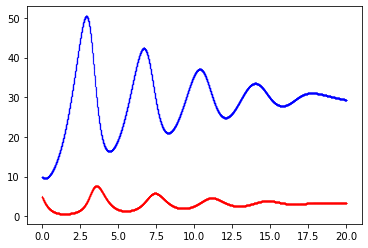

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_100000_1000_0.01_1.0_3.0_0.3_0.333_2022-04-22-00-38-13_1650588537.png


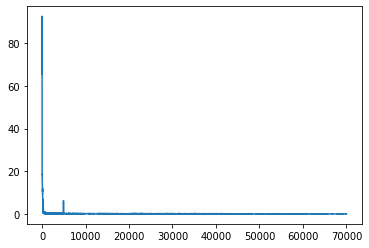

Epoch [71000/100000] Loss:0.037348 Loss_1:0.000007 Loss_2:0.037341 Loss_3: 0.000000 Lr:0.001235 Time:9.845296s (10.89min in total)
Epoch [72000/100000] Loss:0.036290 Loss_1:0.000006 Loss_2:0.036284 Loss_3: 0.000000 Lr:0.001220 Time:9.091848s (11.04min in total)
Epoch [73000/100000] Loss:0.065729 Loss_1:0.000051 Loss_2:0.065677 Loss_3: 0.000000 Lr:0.001205 Time:9.103261s (11.20min in total)
Epoch [74000/100000] Loss:0.044558 Loss_1:0.000286 Loss_2:0.044272 Loss_3: 0.000000 Lr:0.001190 Time:9.118859s (11.35min in total)
Epoch [75000/100000] Loss:0.036047 Loss_1:0.000030 Loss_2:0.036017 Loss_3: 0.000000 Lr:0.001176 Time:9.148532s (11.50min in total)
Epoch [76000/100000] Loss:0.035810 Loss_1:0.000235 Loss_2:0.035575 Loss_3: 0.000000 Lr:0.001163 Time:9.105599s (11.65min in total)
Epoch [77000/100000] Loss:0.037269 Loss_1:0.000003 Loss_2:0.037266 Loss_3: 0.000000 Lr:0.001149 Time:9.113911s (11.80min in total)
Epoch [78000/100000] Loss:0.047535 Loss_1:0.000883 Loss_2:0.046651 Loss_3: 0.000000

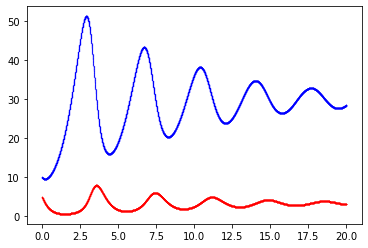

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_100000_1000_0.01_1.0_3.0_0.3_0.333_2022-04-22-00-38-13_1650588629.png


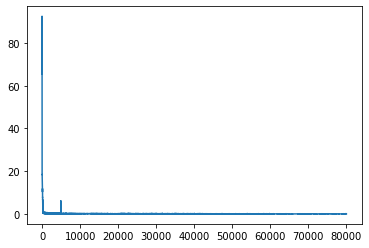

Epoch [81000/100000] Loss:0.029823 Loss_1:0.000003 Loss_2:0.029820 Loss_3: 0.000000 Lr:0.001099 Time:9.904979s (12.42min in total)
Epoch [82000/100000] Loss:0.029164 Loss_1:0.000003 Loss_2:0.029161 Loss_3: 0.000000 Lr:0.001087 Time:9.099472s (12.58min in total)
Epoch [83000/100000] Loss:0.028835 Loss_1:0.000002 Loss_2:0.028833 Loss_3: 0.000000 Lr:0.001075 Time:9.094768s (12.73min in total)
Epoch [84000/100000] Loss:0.027967 Loss_1:0.000003 Loss_2:0.027964 Loss_3: 0.000000 Lr:0.001064 Time:9.167712s (12.88min in total)
Epoch [85000/100000] Loss:0.027931 Loss_1:0.000001 Loss_2:0.027930 Loss_3: 0.000000 Lr:0.001053 Time:9.125430s (13.03min in total)
Epoch [86000/100000] Loss:0.074404 Loss_1:0.000183 Loss_2:0.074220 Loss_3: 0.000000 Lr:0.001042 Time:9.133227s (13.19min in total)
Epoch [87000/100000] Loss:0.027501 Loss_1:0.000001 Loss_2:0.027500 Loss_3: 0.000000 Lr:0.001031 Time:9.123241s (13.34min in total)
Epoch [88000/100000] Loss:0.025920 Loss_1:0.000006 Loss_2:0.025913 Loss_3: 0.000000

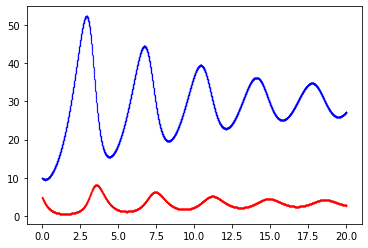

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_100000_1000_0.01_1.0_3.0_0.3_0.333_2022-04-22-00-38-13_1650588721.png


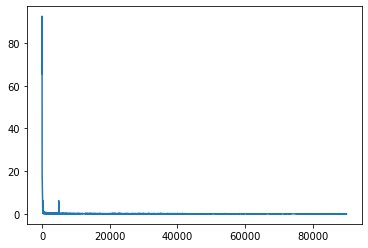

Epoch [91000/100000] Loss:0.024417 Loss_1:0.000002 Loss_2:0.024415 Loss_3: 0.000000 Lr:0.000990 Time:9.872570s (13.96min in total)
Epoch [92000/100000] Loss:0.024104 Loss_1:0.000005 Loss_2:0.024099 Loss_3: 0.000000 Lr:0.000980 Time:9.164164s (14.11min in total)
Epoch [93000/100000] Loss:0.135468 Loss_1:0.000187 Loss_2:0.135281 Loss_3: 0.000000 Lr:0.000971 Time:9.125005s (14.26min in total)
Epoch [94000/100000] Loss:0.023454 Loss_1:0.000007 Loss_2:0.023447 Loss_3: 0.000000 Lr:0.000962 Time:9.118231s (14.42min in total)
Epoch [95000/100000] Loss:0.086158 Loss_1:0.000291 Loss_2:0.085867 Loss_3: 0.000000 Lr:0.000952 Time:9.145087s (14.57min in total)
Epoch [96000/100000] Loss:0.022396 Loss_1:0.000003 Loss_2:0.022393 Loss_3: 0.000000 Lr:0.000943 Time:9.106197s (14.72min in total)
Epoch [97000/100000] Loss:0.026705 Loss_1:0.000125 Loss_2:0.026580 Loss_3: 0.000000 Lr:0.000935 Time:9.129137s (14.87min in total)
Epoch [98000/100000] Loss:0.037031 Loss_1:0.000022 Loss_2:0.037009 Loss_3: 0.000000

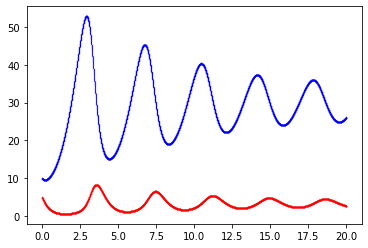

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_100000_1000_0.01_1.0_3.0_0.3_0.333_2022-04-22-00-38-13_1650588813.png


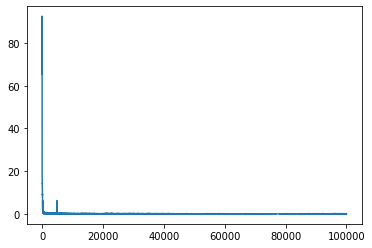

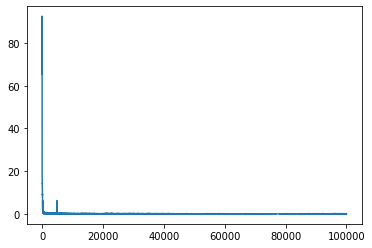


[Training Summary]
num_parameter: -1
best_loss: 0.021337801590561867
time_cost: 15.327450315157572


<Figure size 432x288 with 0 Axes>

In [50]:
# saved: design A - original - Adam
main_path = "/content/drive/My Drive/Workspace/PINN"  # you may need to alter the path if it's not here
run_pp(main_path)

using cuda
epoch = 1000
epoch_step = 10
model_name = SimpleNetworkPP
now_string = 2022-04-21-21-42-17
model_save_path_last = /content/drive/My Drive/Workspace/PINN/train/SimpleNetworkPP_1000_10_0.01_1.0_3.0_0.3_0.333_2022-04-21-21-42-17_last.pt
model_save_path_best = /content/drive/My Drive/Workspace/PINN/train/SimpleNetworkPP_1000_10_0.01_1.0_3.0_0.3_0.333_2022-04-21-21-42-17_best.pt
Epoch [00010/01000] Loss:43442064279187484573696.000000 Loss_1:984924422144.000000 Loss_2:43442064279187484573696.000000 Loss_3:3916235.500000 Lr:0.009010 Time:4.650605s (0.08min in total)
Epoch [00020/01000] Loss:39500365266525123248128.000000 Loss_1:935344275456.000000 Loss_2:39500365266525123248128.000000 Loss_3:3820194.500000 Lr:0.001090 Time:5.550032s (0.17min in total)
Epoch [00030/01000] Loss:30926781591106617344000.000000 Loss_1:793274613760.000000 Loss_2:30926781591106617344000.000000 Loss_3:3555058.000000 Lr:0.009010 Time:6.457937s (0.28min in total)
Epoch [00040/01000] Loss:19214184471811248357

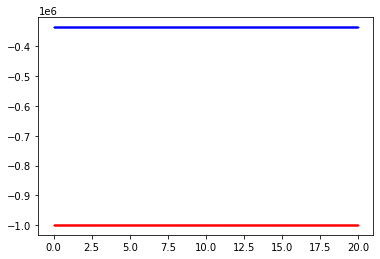

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_1000_10_0.01_1.0_3.0_0.3_0.333_2022-04-21-21-42-17_1650577426.png
Epoch [00110/01000] Loss:5159549476046962163712.000000 Loss_1:556979716096.000000 Loss_2:5159549476046962163712.000000 Loss_3:2650635.250000 Lr:0.009010 Time:14.081804s (1.71min in total)
Epoch [00120/01000] Loss:4200308369639927185408.000000 Loss_1:560871178240.000000 Loss_2:4200308369639927185408.000000 Loss_3:2608794.750000 Lr:0.001090 Time:13.519192s (1.94min in total)
Epoch [00130/01000] Loss:3816712019578831503360.000000 Loss_1:564038991872.000000 Loss_2:3816712019578831503360.000000 Loss_3:2592822.750000 Lr:0.009010 Time:13.563765s (2.17min in total)
Epoch [00140/01000] Loss:2924927517240412078080.000000 Loss_1:582678020096.000000 Loss_2:2924927517240412078080.000000 Loss_3:2568354.000000 Lr:0.001090 Time:13.626973s (2.39min in total)
Epoch [00150/01000] Loss:2365472920079893004288.000000 Loss_1:609109016576.000000 Loss_2:2365472920079893004288

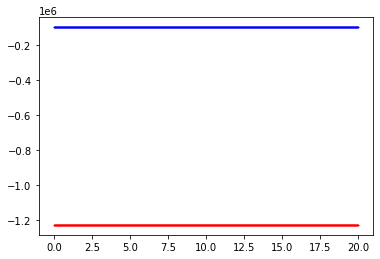

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_1000_10_0.01_1.0_3.0_0.3_0.333_2022-04-21-21-42-17_1650577563.png
Epoch [00210/01000] Loss:658333026935531110400.000000 Loss_1:772834000896.000000 Loss_2:658333026935531110400.000000 Loss_3:2664703.250000 Lr:0.009010 Time:14.075465s (3.99min in total)
Epoch [00220/01000] Loss:529010861813820030976.000000 Loss_1:797925507072.000000 Loss_2:529010861813820030976.000000 Loss_3:2684451.000000 Lr:0.001090 Time:13.548816s (4.21min in total)
Epoch [00230/01000] Loss:480800320384028114944.000000 Loss_1:808539979776.000000 Loss_2:480800320384028114944.000000 Loss_3:2693102.500000 Lr:0.009010 Time:13.599528s (4.44min in total)
Epoch [00240/01000] Loss:392709313538335703040.000000 Loss_1:830022549504.000000 Loss_2:392709313538335703040.000000 Loss_3:2710932.000000 Lr:0.001090 Time:13.567384s (4.66min in total)
Epoch [00250/01000] Loss:357614556045213958144.000000 Loss_1:840496185344.000000 Loss_2:357614556045213958144.000000 Lo

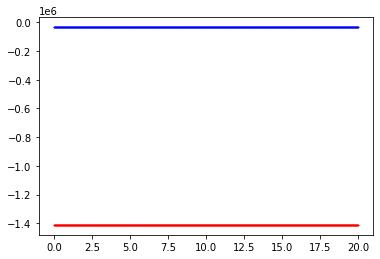

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_1000_10_0.01_1.0_3.0_0.3_0.333_2022-04-21-21-42-17_1650577698.png
Epoch [00310/01000] Loss:107403946179763896320.000000 Loss_1:1014424010752.000000 Loss_2:107403946179763896320.000000 Loss_3:2913093.250000 Lr:0.009010 Time:13.013934s (6.22min in total)
Epoch [00320/01000] Loss:86431852595471450112.000000 Loss_1:1048163188736.000000 Loss_2:86431852595471450112.000000 Loss_3:2952602.250000 Lr:0.001090 Time:13.577420s (6.45min in total)
Epoch [00330/01000] Loss:78420195148983959552.000000 Loss_1:1063531053056.000000 Loss_2:78420195148983959552.000000 Loss_3:2970691.250000 Lr:0.009010 Time:13.586194s (6.67min in total)
Epoch [00340/01000] Loss:63593447974192021504.000000 Loss_1:1095693303808.000000 Loss_2:63593447974192021504.000000 Loss_3:3008452.000000 Lr:0.001090 Time:13.598330s (6.90min in total)
Epoch [00350/01000] Loss:57957241419049467904.000000 Loss_1:1109896855552.000000 Loss_2:57957241419049467904.000000 Loss_

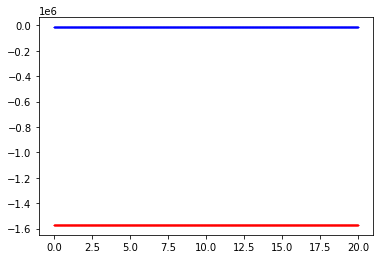

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_1000_10_0.01_1.0_3.0_0.3_0.333_2022-04-21-21-42-17_1650577833.png
Epoch [00410/01000] Loss:23852334661995855872.000000 Loss_1:1251369025536.000000 Loss_2:23852332462972600320.000000 Loss_3:3191488.000000 Lr:0.009010 Time:13.563668s (8.48min in total)
Epoch [00420/01000] Loss:19289181086818500608.000000 Loss_1:1290752622592.000000 Loss_2:19289178887795245056.000000 Loss_3:3237755.250000 Lr:0.001090 Time:13.527467s (8.71min in total)
Epoch [00430/01000] Loss:17421350524761931776.000000 Loss_1:1311185436672.000000 Loss_2:17421349425250304000.000000 Loss_3:3261706.250000 Lr:0.009010 Time:13.244192s (8.93min in total)
Epoch [00440/01000] Loss:14044073016699125760.000000 Loss_1:1354006265856.000000 Loss_2:14044071917187497984.000000 Loss_3:3311500.750000 Lr:0.001090 Time:13.651917s (9.15min in total)
Epoch [00450/01000] Loss:12720919624321859584.000000 Loss_1:1374502649856.000000 Loss_2:12720918524810231808.000000 Loss_3:

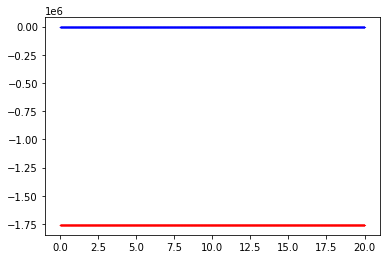

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_1000_10_0.01_1.0_3.0_0.3_0.333_2022-04-21-21-42-17_1650577966.png
Epoch [00510/01000] Loss:5002121497939017728.000000 Loss_1:1566161108992.000000 Loss_2:5002119848671576064.000000 Loss_3:3550943.500000 Lr:0.009010 Time:14.136750s (10.71min in total)
Epoch [00520/01000] Loss:4083930057821650944.000000 Loss_1:1609680420864.000000 Loss_2:4083928408554209280.000000 Loss_3:3598560.500000 Lr:0.001090 Time:13.590309s (10.93min in total)
Epoch [00530/01000] Loss:3717834467214098432.000000 Loss_1:1631123537920.000000 Loss_2:3717832817946656768.000000 Loss_3:3621859.000000 Lr:0.009010 Time:12.584043s (11.14min in total)
Epoch [00540/01000] Loss:3027961564406743040.000000 Loss_1:1677714128896.000000 Loss_2:3027959915139301376.000000 Loss_3:3672037.000000 Lr:0.001090 Time:13.565546s (11.37min in total)
Epoch [00550/01000] Loss:2754563325235822592.000000 Loss_1:1700771790848.000000 Loss_2:2754561675968380928.000000 Loss_3:369667

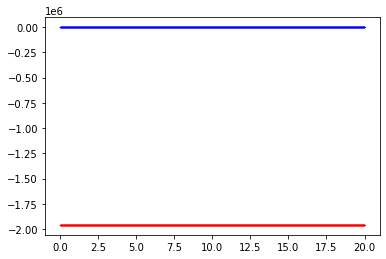

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_1000_10_0.01_1.0_3.0_0.3_0.333_2022-04-21-21-42-17_1650578100.png
Epoch [00610/01000] Loss:1072274044696395776.000000 Loss_1:1942348890112.000000 Loss_2:1072272120551047168.000000 Loss_3:3946607.500000 Lr:0.009010 Time:13.082711s (12.92min in total)
Epoch [00620/01000] Loss:874959536266412032.000000 Loss_1:1997339623424.000000 Loss_2:874957543401586688.000000 Loss_3:4001507.000000 Lr:0.001090 Time:13.656245s (13.14min in total)
Epoch [00630/01000] Loss:799533107320455168.000000 Loss_1:2022641238016.000000 Loss_2:799531114455629824.000000 Loss_3:4026536.250000 Lr:0.009010 Time:13.601511s (13.37min in total)
Epoch [00640/01000] Loss:651533069785759744.000000 Loss_1:2079464882176.000000 Loss_2:651531008201457664.000000 Loss_3:4082213.250000 Lr:0.001090 Time:13.606940s (13.60min in total)
Epoch [00650/01000] Loss:589159493128945664.000000 Loss_1:2109365157888.000000 Loss_2:589157362825166848.000000 Loss_3:4111234.750000

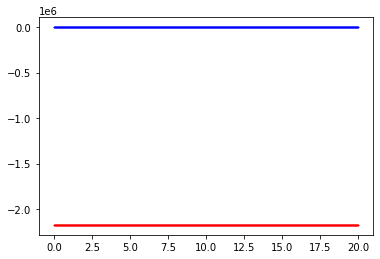

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_1000_10_0.01_1.0_3.0_0.3_0.333_2022-04-21-21-42-17_1650578235.png
Epoch [00710/01000] Loss:189727311262646272.000000 Loss_1:2500586635264.000000 Loss_2:189724803001745408.000000 Loss_3:4474387.500000 Lr:0.009010 Time:12.842748s (15.17min in total)
Epoch [00720/01000] Loss:94117216085082112.000000 Loss_1:2851179855872.000000 Loss_2:94114364226797568.000000 Loss_3:4776913.500000 Lr:0.001090 Time:13.548783s (15.40min in total)
Epoch [00730/01000] Loss:537919401455356746375148601344.000000 Loss_1:8803866376142848.000000 Loss_2:537919401455356746375148601344.000000 Loss_3:0.000000 Lr:0.009010 Time:12.436075s (15.60min in total)
Epoch [00740/01000] Loss:474774410255926805750278520832.000000 Loss_1:7386398856314880.000000 Loss_2:474774410255926805750278520832.000000 Loss_3:0.000000 Lr:0.001090 Time:13.657068s (15.83min in total)
Epoch [00750/01000] Loss:437692008559726985231149826048.000000 Loss_1:6196168392441856.000000 L

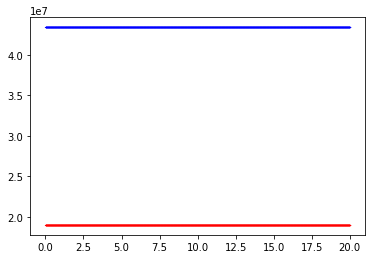

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_1000_10_0.01_1.0_3.0_0.3_0.333_2022-04-21-21-42-17_1650578369.png
Epoch [00810/01000] Loss:30445656315488822745655934976.000000 Loss_1:1119712469581824.000000 Loss_2:30445656315488822745655934976.000000 Loss_3:0.000000 Lr:0.009010 Time:14.145889s (17.42min in total)
Epoch [00820/01000] Loss:23921813272650272449952219136.000000 Loss_1:1121768550957056.000000 Loss_2:23921813272650272449952219136.000000 Loss_3:0.000000 Lr:0.001090 Time:13.518599s (17.65min in total)
Epoch [00830/01000] Loss:21534005328985030783389401088.000000 Loss_1:1125547048435712.000000 Loss_2:21534005328985030783389401088.000000 Loss_3:0.000000 Lr:0.009010 Time:13.575413s (17.87min in total)
Epoch [00840/01000] Loss:17310767010339051285732392960.000000 Loss_1:1136508207628288.000000 Loss_2:17310767010339051285732392960.000000 Loss_3:0.000000 Lr:0.001090 Time:13.528347s (18.10min in total)
Epoch [00850/01000] Loss:15731733981770858689281916928.0000

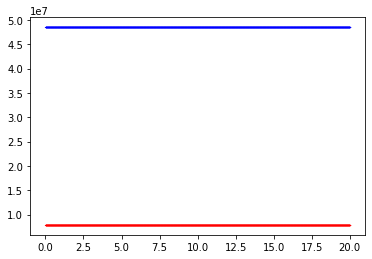

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_1000_10_0.01_1.0_3.0_0.3_0.333_2022-04-21-21-42-17_1650578505.png
Epoch [00910/01000] Loss:6665888284868407071497781248.000000 Loss_1:1218470679150592.000000 Loss_2:6665888284868407071497781248.000000 Loss_3:0.000000 Lr:0.009010 Time:13.915695s (19.69min in total)
Epoch [00920/01000] Loss:5408972596463235844718723072.000000 Loss_1:1248453980061696.000000 Loss_2:5408972596463235844718723072.000000 Loss_3:0.000000 Lr:0.001090 Time:13.589577s (19.92min in total)
Epoch [00930/01000] Loss:4493577271507576642382856192.000000 Loss_1:1283585201930240.000000 Loss_2:4493577271507576642382856192.000000 Loss_3:0.000000 Lr:0.009010 Time:12.349417s (20.12min in total)
Epoch [00940/01000] Loss:3388734180062825524303495168.000000 Loss_1:1353746982371328.000000 Loss_2:3388734180062825524303495168.000000 Loss_3:0.000000 Lr:0.001090 Time:13.640942s (20.35min in total)
Epoch [00950/01000] Loss:2894110858315912270445543424.000000 Loss_1

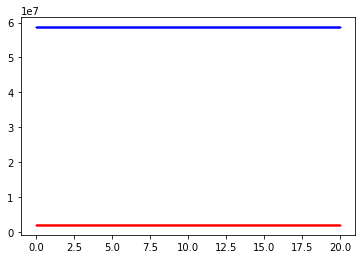

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_1000_10_0.01_1.0_3.0_0.3_0.333_2022-04-21-21-42-17_1650578636.png


<Figure size 432x288 with 0 Axes>

In [22]:
# LBFGS version

class Args:
    epoch = 1000
    epoch_step = 10
    lr = 0.01
    main_path = "."
    save_step = 100


main_path = "/content/drive/My Drive/Workspace/PINN"  # you may need to alter the path if it's not here
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
args = Args
if main_path:
    args.main_path = main_path
if not os.path.exists("{}/train".format(args.main_path)):
    os.makedirs("{}/train".format(args.main_path))
if not os.path.exists("{}/figure".format(args.main_path)):
    os.makedirs("{}/figure".format(args.main_path))
now_string = get_now_string()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = ConfigPP
model = SimpleNetworkPP(config).to(device)

model.train()
model_save_path_last = f"{args.main_path}/train/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{config.alpha}_{config.beta}_{config.gamma}_{config.e}_{now_string}_last.pt"
model_save_path_best = f"{args.main_path}/train/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{config.alpha}_{config.beta}_{config.gamma}_{config.e}_{now_string}_best.pt"
loss_save_path = f"{args.main_path}/loss/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{config.alpha}_{config.beta}_{config.gamma}_{config.e}_{now_string}_loss_{args.epoch}.npy"
  
print("using " + str(device))
print("epoch = {}".format(args.epoch))
print("epoch_step = {}".format(args.epoch_step))
print("model_name = {}".format(model.model_name))
print("now_string = {}".format(now_string))
print("model_save_path_last = {}".format(model_save_path_last))
print("model_save_path_best = {}".format(model_save_path_best))
# optimizer = optim.Adam(model.parameters(), lr=args.lr)
initial_lr = args.lr
# optimizer = optim.Adam(model.parameters(), lr = initial_lr)

# params = torch.nn.Parameter(1*torch.ones(1).to(device), requires_grad=True)

optimizer = optim.LBFGS(model.parameters(), lr=args.lr, max_iter=100)
# line_search_fn="strong_wolfe"
# line_search_fn="strong_wolfe" 
# scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 1/(epoch/1000+1))
scheduler = CyclicLR(optimizer, base_lr=0.0001, max_lr=0.01, step_size=10)
# optimizer = optim.LBFGS(model.parameters(), lr=args.lr, max_iter=5000, max_eval=None, tolerance_grad=1e-05, tolerance_change=1e-09, history_size=100,
#       line_search_fn=None)
epoch_step = args.epoch_step
start_time = time.time()
start_time_0 = start_time

train_x = model.x
loss_record = []


for epoch in range(1, args.epoch + 1):
    # optimizer.zero_grad()
    # inputs = model.x
    # outputs = model(inputs)
    # u_hat, v_hat = torch.chunk(outputs, 2, 1)
    
    # Changes here
    loss, loss_list = model.loss()
    loss_1, loss_2, loss_3 = loss_list[0], loss_list[1], loss_list[2]
    # loss.backward()
    # optimizer.step()

    def closure():
        #optimizer.zero_grad()
        output = model(train_x)
        l, loss_list = model.loss()
        return l

    optimizer.zero_grad()
    l = closure()
    l.backward()
    optimizer.step(closure)

    # options = {'closure': closure, 'current_loss': loss, 'max_ls': 10}

    scheduler.step()
    best_loss = 1e20
    if epoch % epoch_step == 0:
        now_time = time.time()
        print("Epoch [{0:05d}/{1:05d}] Loss:{2:.6f} Loss_1:{3:.6f} Loss_2:{4:.6f} Loss_3:{5:.6f} Lr:{6:.6f} Time:{7:.6f}s ({8:.2f}min in total)".format(epoch, args.epoch, loss.item(), loss_1.item(), loss_2.item(), loss_3.item(), optimizer.param_groups[0]["lr"], time.time() - start_time, (now_time - start_time_0) / 60.0))
        start_time = now_time
        torch.save(
            {
                'epoch': args.epoch,
                'model_state_dict': model.state_dict(),
                # 'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss.item()
            }, model_save_path_last)
        # print(inputs.shape)
        if loss.item() < best_loss:
            torch.save(
                {
                    'epoch': args.epoch,
                    'model_state_dict': model.state_dict(),
                    # 'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss.item()
                }, model_save_path_best)
            best_loss = loss.item()
    if epoch % args.save_step == 0:
        test_pp(model, args, config, now_string, True)

num_parameter = -1  # get_model_parameters(model, config)
best_loss = best_loss
time_cost = (now_time - start_time_0) / 60.0
loss_record = np.asarray(loss_record)
np.save(loss_save_path, loss_record)




using cuda
epoch = 100000
epoch_step = 1000
model_name = SimpleNetworkPP
now_string = 2022-03-30-15-40-48
model_save_path_last = /content/drive/My Drive/Workspace/PINN/train/SimpleNetworkPP_100000_1000_0.01_1.0_3.0_0.3_0.333_2022-03-30-15-40-48_last.pt
model_save_path_best = /content/drive/My Drive/Workspace/PINN/train/SimpleNetworkPP_100000_1000_0.01_1.0_3.0_0.3_0.333_2022-03-30-15-40-48_best.pt
loss_save_path = /content/drive/My Drive/Workspace/PINN/loss/SimpleNetworkPP_100000_1000_0.01_1.0_3.0_0.3_0.333_2022-03-30-15-40-48_loss_100000.npy
args = {'epoch': 100000, 'epoch_step': 1000, 'lr': 0.01, 'main_path': '/content/drive/My Drive/Workspace/PINN', 'save_step': 10000}
config = {'T': 20.0, 'T_unit': 0.001, 'N': 20000, 'U_start': 10.0, 'V_start': 5.0, 'alpha': 1.0, 'beta': 3.0, 'gamma': 0.3, 'e': 0.333, 'ub': 20.0, 'lb': 0.0}
Epoch [01000/100000] Loss:17.655598 Loss_1:12.779760 Loss_2:4.480127 Loss_3: 0.395709 Lr:0.009091 Time:7.263627s (0.12min in total)
Epoch [02000/100000] Loss:17.

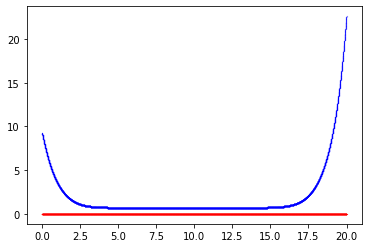

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_100000_1000_0.01_1.0_3.0_0.3_0.333_2022-03-30-15-40-48_1648654917.png


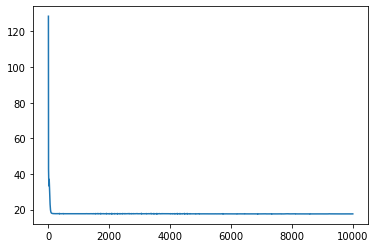

Epoch [11000/100000] Loss:17.540241 Loss_1:12.955536 Loss_2:4.228876 Loss_3: 0.355829 Lr:0.004762 Time:7.496655s (1.27min in total)
Epoch [12000/100000] Loss:17.540089 Loss_1:12.993961 Loss_2:4.194094 Loss_3: 0.352034 Lr:0.004545 Time:7.290060s (1.39min in total)
Epoch [13000/100000] Loss:17.546535 Loss_1:12.967595 Loss_2:4.221474 Loss_3: 0.357467 Lr:0.004348 Time:6.884099s (1.51min in total)
Epoch [14000/100000] Loss:17.545753 Loss_1:12.898437 Loss_2:4.296947 Loss_3: 0.350369 Lr:0.004167 Time:6.876582s (1.62min in total)
Epoch [15000/100000] Loss:17.536371 Loss_1:12.861966 Loss_2:4.335043 Loss_3: 0.339361 Lr:0.004000 Time:6.867102s (1.74min in total)
Epoch [16000/100000] Loss:17.560102 Loss_1:12.949822 Loss_2:4.244782 Loss_3: 0.365498 Lr:0.003846 Time:6.866038s (1.85min in total)
Epoch [17000/100000] Loss:17.542953 Loss_1:12.899865 Loss_2:4.296634 Loss_3: 0.346454 Lr:0.003704 Time:6.848669s (1.97min in total)
Epoch [18000/100000] Loss:17.582220 Loss_1:13.144226 Loss_2:4.069483 Loss_3:

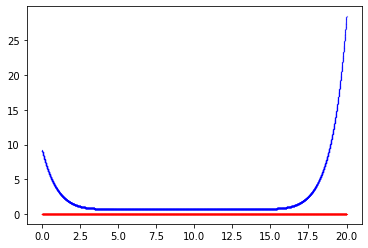

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_100000_1000_0.01_1.0_3.0_0.3_0.333_2022-03-30-15-40-48_1648654987.png


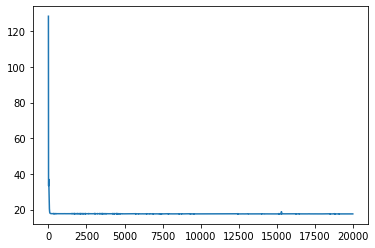

Epoch [21000/100000] Loss:17.526188 Loss_1:12.907730 Loss_2:4.278484 Loss_3: 0.339974 Lr:0.003226 Time:7.605198s (2.44min in total)
Epoch [22000/100000] Loss:17.523291 Loss_1:12.917255 Loss_2:4.267509 Loss_3: 0.338526 Lr:0.003125 Time:6.869061s (2.55min in total)
Epoch [23000/100000] Loss:17.524134 Loss_1:12.962294 Loss_2:4.219318 Loss_3: 0.342523 Lr:0.003030 Time:6.894659s (2.67min in total)
Epoch [24000/100000] Loss:17.522310 Loss_1:12.842485 Loss_2:4.349547 Loss_3: 0.330278 Lr:0.002941 Time:6.915985s (2.78min in total)
Epoch [25000/100000] Loss:17.520872 Loss_1:12.880871 Loss_2:4.307304 Loss_3: 0.332697 Lr:0.002857 Time:6.822362s (2.89min in total)
Epoch [26000/100000] Loss:17.526392 Loss_1:12.901913 Loss_2:4.294065 Loss_3: 0.330413 Lr:0.002778 Time:6.840005s (3.01min in total)
Epoch [27000/100000] Loss:17.518888 Loss_1:12.934633 Loss_2:4.247201 Loss_3: 0.337053 Lr:0.002703 Time:6.878396s (3.12min in total)
Epoch [28000/100000] Loss:17.521839 Loss_1:12.916300 Loss_2:4.268095 Loss_3:

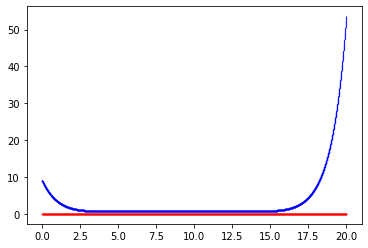

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_100000_1000_0.01_1.0_3.0_0.3_0.333_2022-03-30-15-40-48_1648655056.png


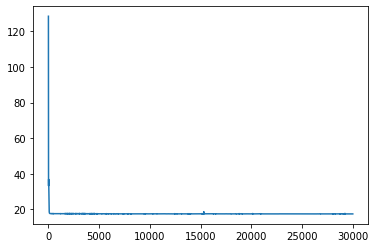

Epoch [31000/100000] Loss:17.511986 Loss_1:12.911549 Loss_2:4.268825 Loss_3: 0.331612 Lr:0.002439 Time:7.623886s (3.59min in total)
Epoch [32000/100000] Loss:17.512985 Loss_1:12.866418 Loss_2:4.321884 Loss_3: 0.324685 Lr:0.002381 Time:6.862521s (3.71min in total)
Epoch [33000/100000] Loss:17.508141 Loss_1:12.914274 Loss_2:4.265337 Loss_3: 0.328530 Lr:0.002326 Time:6.830456s (3.82min in total)
Epoch [34000/100000] Loss:17.512110 Loss_1:12.852113 Loss_2:4.336205 Loss_3: 0.323791 Lr:0.002273 Time:6.841274s (3.94min in total)
Epoch [35000/100000] Loss:17.505867 Loss_1:12.894386 Loss_2:4.286759 Loss_3: 0.324723 Lr:0.002222 Time:6.838372s (4.05min in total)
Epoch [36000/100000] Loss:17.505756 Loss_1:12.923776 Loss_2:4.255988 Loss_3: 0.325993 Lr:0.002174 Time:6.877091s (4.17min in total)
Epoch [37000/100000] Loss:17.501865 Loss_1:12.917035 Loss_2:4.261275 Loss_3: 0.323556 Lr:0.002128 Time:6.925303s (4.28min in total)
Epoch [38000/100000] Loss:17.500530 Loss_1:12.906673 Loss_2:4.270806 Loss_3:

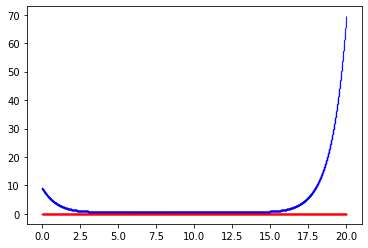

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_100000_1000_0.01_1.0_3.0_0.3_0.333_2022-03-30-15-40-48_1648655126.png


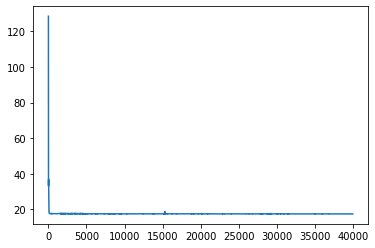

Epoch [41000/100000] Loss:17.502556 Loss_1:12.914441 Loss_2:4.263405 Loss_3: 0.324710 Lr:0.001961 Time:7.593451s (4.75min in total)
Epoch [42000/100000] Loss:17.499119 Loss_1:12.898540 Loss_2:4.280190 Loss_3: 0.320388 Lr:0.001923 Time:6.936670s (4.87min in total)
Epoch [43000/100000] Loss:17.499748 Loss_1:12.921863 Loss_2:4.254891 Loss_3: 0.322994 Lr:0.001887 Time:6.901010s (4.98min in total)
Epoch [44000/100000] Loss:17.500557 Loss_1:12.961291 Loss_2:4.214235 Loss_3: 0.325031 Lr:0.001852 Time:6.891848s (5.10min in total)
Epoch [45000/100000] Loss:17.496483 Loss_1:12.923131 Loss_2:4.252687 Loss_3: 0.320664 Lr:0.001818 Time:6.893824s (5.21min in total)
Epoch [46000/100000] Loss:17.497232 Loss_1:12.902085 Loss_2:4.275395 Loss_3: 0.319753 Lr:0.001786 Time:6.885040s (5.33min in total)
Epoch [47000/100000] Loss:17.498461 Loss_1:12.946623 Loss_2:4.229655 Loss_3: 0.322183 Lr:0.001754 Time:6.849231s (5.44min in total)
Epoch [48000/100000] Loss:17.495796 Loss_1:12.903470 Loss_2:4.273552 Loss_3:

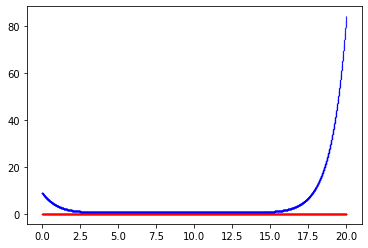

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_100000_1000_0.01_1.0_3.0_0.3_0.333_2022-03-30-15-40-48_1648655195.png


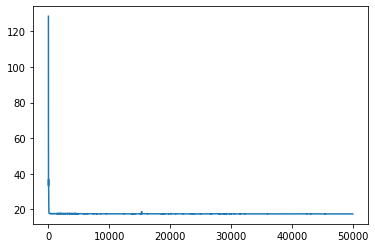

Epoch [51000/100000] Loss:17.495890 Loss_1:12.918125 Loss_2:4.256359 Loss_3: 0.321405 Lr:0.001639 Time:7.563462s (5.91min in total)
Epoch [52000/100000] Loss:17.494410 Loss_1:12.936608 Loss_2:4.237296 Loss_3: 0.320505 Lr:0.001613 Time:6.911273s (6.02min in total)
Epoch [53000/100000] Loss:17.497057 Loss_1:12.907649 Loss_2:4.268947 Loss_3: 0.320461 Lr:0.001587 Time:6.848027s (6.14min in total)
Epoch [54000/100000] Loss:17.494900 Loss_1:12.897575 Loss_2:4.278966 Loss_3: 0.318358 Lr:0.001563 Time:6.846498s (6.25min in total)
Epoch [55000/100000] Loss:17.492592 Loss_1:12.913752 Loss_2:4.261089 Loss_3: 0.317750 Lr:0.001538 Time:6.792320s (6.37min in total)
Epoch [56000/100000] Loss:17.494108 Loss_1:12.920048 Loss_2:4.254939 Loss_3: 0.319121 Lr:0.001515 Time:6.848044s (6.48min in total)
Epoch [57000/100000] Loss:17.506342 Loss_1:12.941336 Loss_2:4.245770 Loss_3: 0.319237 Lr:0.001493 Time:6.817330s (6.59min in total)
Epoch [58000/100000] Loss:17.492802 Loss_1:12.918983 Loss_2:4.257822 Loss_3:

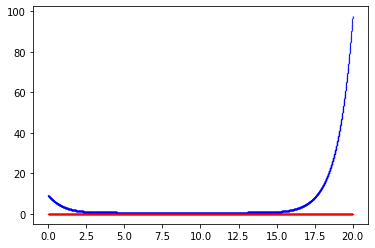

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_100000_1000_0.01_1.0_3.0_0.3_0.333_2022-03-30-15-40-48_1648655264.png


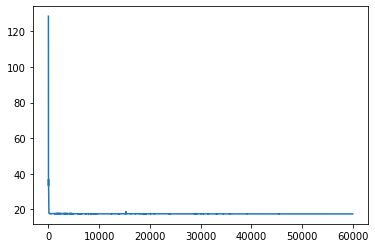

Epoch [61000/100000] Loss:17.489908 Loss_1:12.908847 Loss_2:4.265359 Loss_3: 0.315702 Lr:0.001408 Time:7.616278s (7.06min in total)
Epoch [62000/100000] Loss:17.490477 Loss_1:12.907197 Loss_2:4.268236 Loss_3: 0.315042 Lr:0.001389 Time:6.889543s (7.18min in total)
Epoch [63000/100000] Loss:17.490515 Loss_1:12.910649 Loss_2:4.264393 Loss_3: 0.315474 Lr:0.001370 Time:6.869415s (7.29min in total)
Epoch [64000/100000] Loss:17.490681 Loss_1:12.875214 Loss_2:4.303759 Loss_3: 0.311709 Lr:0.001351 Time:6.839577s (7.41min in total)
Epoch [65000/100000] Loss:17.489908 Loss_1:12.918975 Loss_2:4.254258 Loss_3: 0.316676 Lr:0.001333 Time:6.844191s (7.52min in total)
Epoch [66000/100000] Loss:17.487967 Loss_1:12.916300 Loss_2:4.256967 Loss_3: 0.314698 Lr:0.001316 Time:6.813918s (7.63min in total)
Epoch [67000/100000] Loss:17.489483 Loss_1:12.868118 Loss_2:4.310672 Loss_3: 0.310691 Lr:0.001299 Time:6.839857s (7.75min in total)
Epoch [68000/100000] Loss:17.487089 Loss_1:12.902203 Loss_2:4.271632 Loss_3:

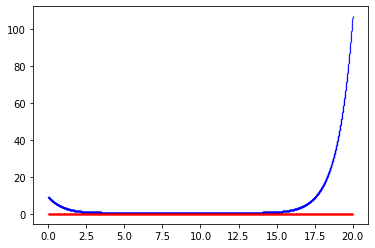

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_100000_1000_0.01_1.0_3.0_0.3_0.333_2022-03-30-15-40-48_1648655334.png


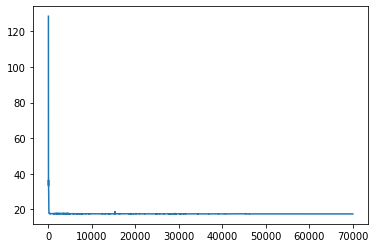

Epoch [71000/100000] Loss:17.500113 Loss_1:12.951018 Loss_2:4.227144 Loss_3: 0.321951 Lr:0.001235 Time:7.621911s (8.22min in total)
Epoch [72000/100000] Loss:17.488096 Loss_1:12.937820 Loss_2:4.234568 Loss_3: 0.315708 Lr:0.001220 Time:6.863049s (8.33min in total)
Epoch [73000/100000] Loss:17.486547 Loss_1:12.906786 Loss_2:4.266511 Loss_3: 0.313249 Lr:0.001205 Time:6.873920s (8.45min in total)
Epoch [74000/100000] Loss:17.485374 Loss_1:12.893975 Loss_2:4.279927 Loss_3: 0.311472 Lr:0.001190 Time:6.830224s (8.56min in total)
Epoch [75000/100000] Loss:17.489088 Loss_1:12.877662 Loss_2:4.299793 Loss_3: 0.311635 Lr:0.001176 Time:6.868766s (8.68min in total)
Epoch [76000/100000] Loss:17.486111 Loss_1:12.924829 Loss_2:4.248024 Loss_3: 0.313257 Lr:0.001163 Time:6.831836s (8.79min in total)
Epoch [77000/100000] Loss:17.485516 Loss_1:12.907300 Loss_2:4.265408 Loss_3: 0.312809 Lr:0.001149 Time:6.862843s (8.90min in total)
Epoch [78000/100000] Loss:17.488914 Loss_1:12.894768 Loss_2:4.280322 Loss_3:

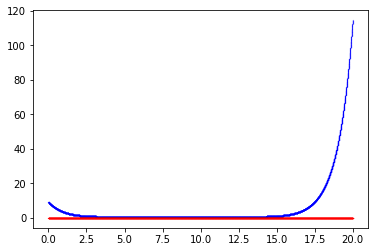

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_100000_1000_0.01_1.0_3.0_0.3_0.333_2022-03-30-15-40-48_1648655403.png


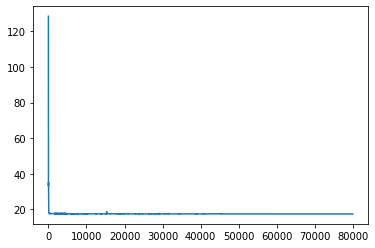

Epoch [81000/100000] Loss:17.488220 Loss_1:12.925821 Loss_2:4.248535 Loss_3: 0.313863 Lr:0.001099 Time:7.666890s (9.37min in total)
Epoch [82000/100000] Loss:17.483637 Loss_1:12.895039 Loss_2:4.278067 Loss_3: 0.310532 Lr:0.001087 Time:6.867927s (9.49min in total)
Epoch [83000/100000] Loss:17.483179 Loss_1:12.904519 Loss_2:4.268122 Loss_3: 0.310537 Lr:0.001075 Time:6.835861s (9.60min in total)
Epoch [84000/100000] Loss:17.483074 Loss_1:12.903430 Loss_2:4.269105 Loss_3: 0.310539 Lr:0.001064 Time:6.840724s (9.72min in total)
Epoch [85000/100000] Loss:17.483717 Loss_1:12.900405 Loss_2:4.273341 Loss_3: 0.309970 Lr:0.001053 Time:6.941828s (9.83min in total)
Epoch [86000/100000] Loss:17.483240 Loss_1:12.934063 Loss_2:4.236240 Loss_3: 0.312937 Lr:0.001042 Time:6.845102s (9.95min in total)
Epoch [87000/100000] Loss:17.489746 Loss_1:12.929128 Loss_2:4.244656 Loss_3: 0.315961 Lr:0.001031 Time:6.807204s (10.06min in total)
Epoch [88000/100000] Loss:17.483253 Loss_1:12.886500 Loss_2:4.287277 Loss_3

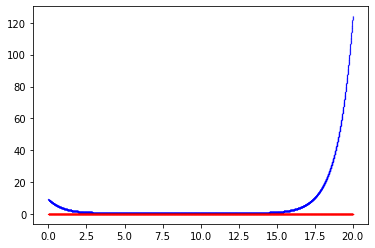

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_100000_1000_0.01_1.0_3.0_0.3_0.333_2022-03-30-15-40-48_1648655472.png


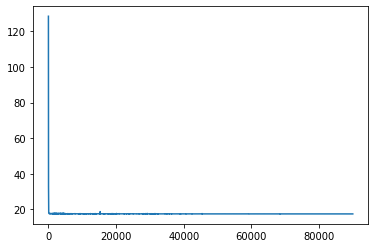

Epoch [91000/100000] Loss:17.482878 Loss_1:12.938386 Loss_2:4.232766 Loss_3: 0.311725 Lr:0.000990 Time:7.648164s (10.53min in total)
Epoch [92000/100000] Loss:17.481792 Loss_1:12.927202 Loss_2:4.243291 Loss_3: 0.311299 Lr:0.000980 Time:6.838668s (10.64min in total)
Epoch [93000/100000] Loss:17.481871 Loss_1:12.923079 Loss_2:4.246720 Loss_3: 0.312073 Lr:0.000971 Time:6.910075s (10.76min in total)
Epoch [94000/100000] Loss:17.480850 Loss_1:12.912471 Loss_2:4.258160 Loss_3: 0.310219 Lr:0.000962 Time:6.837430s (10.87min in total)
Epoch [95000/100000] Loss:17.480753 Loss_1:12.910986 Loss_2:4.260213 Loss_3: 0.309552 Lr:0.000952 Time:6.888030s (10.99min in total)
Epoch [96000/100000] Loss:17.480108 Loss_1:12.915179 Loss_2:4.255144 Loss_3: 0.309786 Lr:0.000943 Time:6.863534s (11.10min in total)
Epoch [97000/100000] Loss:17.480867 Loss_1:12.896029 Loss_2:4.276666 Loss_3: 0.308172 Lr:0.000935 Time:6.892902s (11.22min in total)
Epoch [98000/100000] Loss:17.482580 Loss_1:12.950338 Loss_2:4.220366 

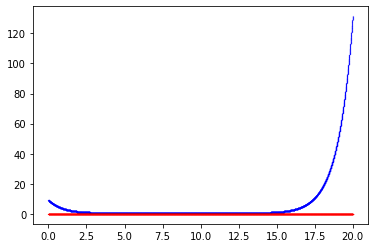

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_100000_1000_0.01_1.0_3.0_0.3_0.333_2022-03-30-15-40-48_1648655542.png


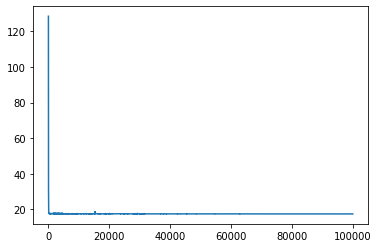

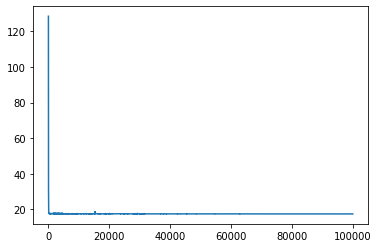


[Training Summary]
num_parameter: -1
best_loss: 17.4801082611084
time_cost: 11.559029511610667


<Figure size 432x288 with 0 Axes>

In [ ]:
# test here
main_path = "/content/drive/My Drive/Workspace/PINN"  # you may need to alter the path if it's not here
run_pp(main_path)

In [ ]:
# design (a) again 100000 / 1000 / 10000
main_path = "/content/drive/My Drive/Workspace/PINN"  # you may need to alter the path if it's not here
run_pp(main_path)

using cuda
epoch = 100000
epoch_step = 1000
model_name = SimpleNetworkPP
now_string = 2022-04-14-02-58-39
model_save_path_last = /content/drive/My Drive/Workspace/PINN/train/SimpleNetworkPP_100000_1000_0.01_1.0_3.0_0.3_0.333_2022-04-14-02-58-39_last.pt
model_save_path_best = /content/drive/My Drive/Workspace/PINN/train/SimpleNetworkPP_100000_1000_0.01_1.0_3.0_0.3_0.333_2022-04-14-02-58-39_best.pt
loss_save_path = /content/drive/My Drive/Workspace/PINN/loss/SimpleNetworkPP_100000_1000_0.01_1.0_3.0_0.3_0.333_2022-04-14-02-58-39_loss_100000.npy
args = {'epoch': 100000, 'epoch_step': 1000, 'lr': 0.01, 'main_path': '/content/drive/My Drive/Workspace/PINN', 'save_step': 10000}
config = {'T': 20.0, 'T_unit': 0.001, 'N': 20000, 'U_start': 10.0, 'V_start': 5.0, 'alpha': 1.0, 'beta': 3.0, 'gamma': 0.3, 'e': 0.333, 'ub': 20.0, 'lb': 0.0}


AttributeError: ignored

using cuda
epoch = 100000
epoch_step = 1000
model_name = SimpleNetworkPP
now_string = 2022-03-28-21-30-19
model_save_path_last = /content/drive/My Drive/Workspace/PINN/train/SimpleNetworkPP_100000_1000_0.01_1.0_3.0_0.3_0.333_2022-03-28-21-30-19_last.pt
model_save_path_best = /content/drive/My Drive/Workspace/PINN/train/SimpleNetworkPP_100000_1000_0.01_1.0_3.0_0.3_0.333_2022-03-28-21-30-19_best.pt
loss_save_path = /content/drive/My Drive/Workspace/PINN/loss/SimpleNetworkPP_100000_1000_0.01_1.0_3.0_0.3_0.333_2022-03-28-21-30-19_loss_100000.npy
Epoch [01000/100000] Loss:7.801477 Loss_1:0.552762 Loss_2:7.248715 Loss_3: 0.000000 Lr:0.009091 Time:9.643284s (0.16min in total)
Epoch [02000/100000] Loss:0.337281 Loss_1:0.017509 Loss_2:0.319772 Loss_3: 0.000000 Lr:0.008333 Time:9.697304s (0.32min in total)
Epoch [03000/100000] Loss:0.279065 Loss_1:0.003200 Loss_2:0.275866 Loss_3: 0.000000 Lr:0.007692 Time:9.664076s (0.48min in total)
Epoch [04000/100000] Loss:0.263280 Loss_1:0.002311 Loss_2:0.26

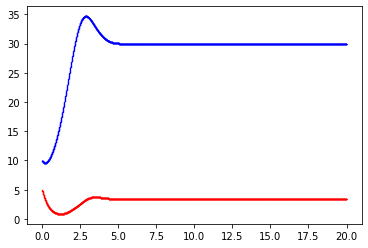

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_100000_1000_0.01_1.0_3.0_0.3_0.333_2022-03-28-21-30-19_1648503116.png


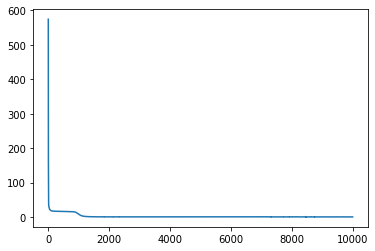

Epoch [11000/100000] Loss:0.149220 Loss_1:0.003798 Loss_2:0.145421 Loss_3: 0.000000 Lr:0.004762 Time:10.633691s (1.79min in total)
Epoch [12000/100000] Loss:0.141845 Loss_1:0.000844 Loss_2:0.141001 Loss_3: 0.000000 Lr:0.004545 Time:9.724431s (1.95min in total)
Epoch [13000/100000] Loss:0.141955 Loss_1:0.004587 Loss_2:0.137368 Loss_3: 0.000000 Lr:0.004348 Time:9.741995s (2.12min in total)
Epoch [14000/100000] Loss:0.133521 Loss_1:0.004952 Loss_2:0.128569 Loss_3: 0.000000 Lr:0.004167 Time:9.664678s (2.28min in total)
Epoch [15000/100000] Loss:0.113427 Loss_1:0.000369 Loss_2:0.113059 Loss_3: 0.000000 Lr:0.004000 Time:9.741054s (2.44min in total)
Epoch [16000/100000] Loss:0.108973 Loss_1:0.000275 Loss_2:0.108699 Loss_3: 0.000000 Lr:0.003846 Time:9.610251s (2.60min in total)
Epoch [17000/100000] Loss:0.123041 Loss_1:0.000076 Loss_2:0.122965 Loss_3: 0.000000 Lr:0.003704 Time:9.740464s (2.76min in total)
Epoch [18000/100000] Loss:0.095591 Loss_1:0.000090 Loss_2:0.095501 Loss_3: 0.000000 Lr:0.

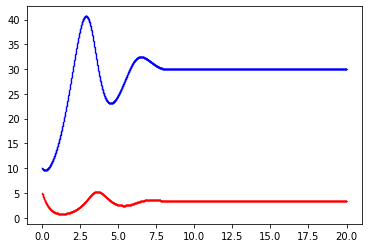

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_100000_1000_0.01_1.0_3.0_0.3_0.333_2022-03-28-21-30-19_1648503214.png


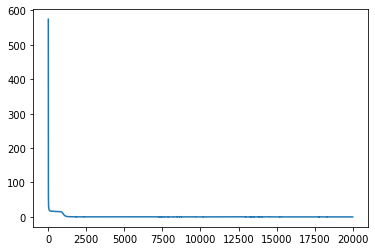

Epoch [21000/100000] Loss:0.114445 Loss_1:0.011517 Loss_2:0.102928 Loss_3: 0.000000 Lr:0.003226 Time:10.531184s (3.42min in total)
Epoch [22000/100000] Loss:0.103554 Loss_1:0.000273 Loss_2:0.103282 Loss_3: 0.000000 Lr:0.003125 Time:9.654479s (3.58min in total)
Epoch [23000/100000] Loss:0.075346 Loss_1:0.000660 Loss_2:0.074687 Loss_3: 0.000000 Lr:0.003030 Time:9.739709s (3.74min in total)
Epoch [24000/100000] Loss:0.071877 Loss_1:0.000021 Loss_2:0.071855 Loss_3: 0.000000 Lr:0.002941 Time:9.635400s (3.91min in total)
Epoch [25000/100000] Loss:0.105742 Loss_1:0.005609 Loss_2:0.100133 Loss_3: 0.000000 Lr:0.002857 Time:9.644377s (4.07min in total)
Epoch [26000/100000] Loss:0.065017 Loss_1:0.000694 Loss_2:0.064323 Loss_3: 0.000000 Lr:0.002778 Time:9.696073s (4.23min in total)
Epoch [27000/100000] Loss:0.106991 Loss_1:0.000655 Loss_2:0.106335 Loss_3: 0.000000 Lr:0.002703 Time:9.683154s (4.39min in total)
Epoch [28000/100000] Loss:0.069509 Loss_1:0.002359 Loss_2:0.067150 Loss_3: 0.000000 Lr:0.

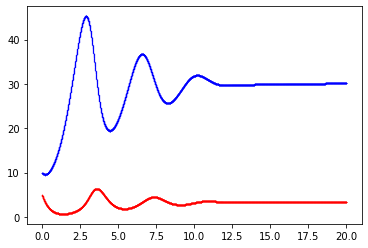

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_100000_1000_0.01_1.0_3.0_0.3_0.333_2022-03-28-21-30-19_1648503312.png


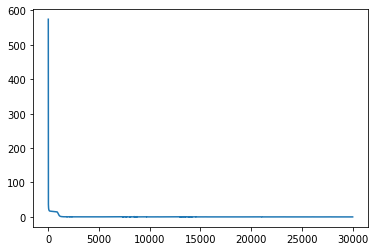

Epoch [31000/100000] Loss:0.060771 Loss_1:0.000052 Loss_2:0.060719 Loss_3: 0.000000 Lr:0.002439 Time:10.542675s (5.05min in total)
Epoch [32000/100000] Loss:0.059552 Loss_1:0.000198 Loss_2:0.059354 Loss_3: 0.000000 Lr:0.002381 Time:9.681328s (5.21min in total)
Epoch [33000/100000] Loss:0.071709 Loss_1:0.000153 Loss_2:0.071556 Loss_3: 0.000000 Lr:0.002326 Time:9.774257s (5.37min in total)
Epoch [34000/100000] Loss:0.054288 Loss_1:0.000021 Loss_2:0.054267 Loss_3: 0.000000 Lr:0.002273 Time:9.821264s (5.54min in total)
Epoch [35000/100000] Loss:0.054304 Loss_1:0.000388 Loss_2:0.053916 Loss_3: 0.000000 Lr:0.002222 Time:9.776319s (5.70min in total)
Epoch [36000/100000] Loss:0.055522 Loss_1:0.000041 Loss_2:0.055481 Loss_3: 0.000000 Lr:0.002174 Time:9.642901s (5.86min in total)
Epoch [37000/100000] Loss:0.074792 Loss_1:0.000670 Loss_2:0.074122 Loss_3: 0.000000 Lr:0.002128 Time:9.720194s (6.02min in total)
Epoch [38000/100000] Loss:0.051273 Loss_1:0.000131 Loss_2:0.051142 Loss_3: 0.000000 Lr:0.

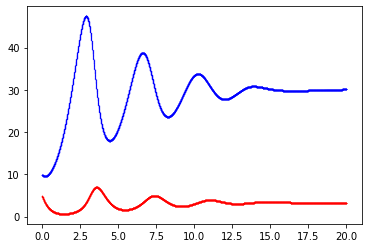

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_100000_1000_0.01_1.0_3.0_0.3_0.333_2022-03-28-21-30-19_1648503410.png


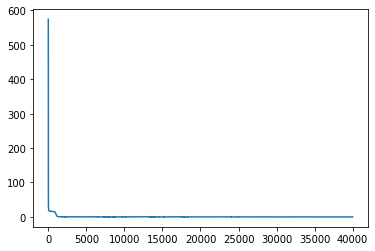

Epoch [41000/100000] Loss:0.047586 Loss_1:0.000211 Loss_2:0.047375 Loss_3: 0.000000 Lr:0.001961 Time:10.708040s (6.69min in total)
Epoch [42000/100000] Loss:0.046135 Loss_1:0.000013 Loss_2:0.046122 Loss_3: 0.000000 Lr:0.001923 Time:9.766278s (6.85min in total)
Epoch [43000/100000] Loss:0.047441 Loss_1:0.000243 Loss_2:0.047198 Loss_3: 0.000000 Lr:0.001887 Time:9.717261s (7.01min in total)
Epoch [44000/100000] Loss:0.044674 Loss_1:0.000008 Loss_2:0.044665 Loss_3: 0.000000 Lr:0.001852 Time:9.668915s (7.17min in total)
Epoch [45000/100000] Loss:0.051467 Loss_1:0.000998 Loss_2:0.050469 Loss_3: 0.000000 Lr:0.001818 Time:9.770069s (7.34min in total)
Epoch [46000/100000] Loss:0.043976 Loss_1:0.000044 Loss_2:0.043932 Loss_3: 0.000000 Lr:0.001786 Time:9.726548s (7.50min in total)
Epoch [47000/100000] Loss:0.044400 Loss_1:0.000014 Loss_2:0.044386 Loss_3: 0.000000 Lr:0.001754 Time:9.693443s (7.66min in total)
Epoch [48000/100000] Loss:0.050739 Loss_1:0.000645 Loss_2:0.050094 Loss_3: 0.000000 Lr:0.

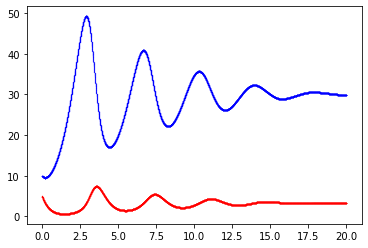

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_100000_1000_0.01_1.0_3.0_0.3_0.333_2022-03-28-21-30-19_1648503508.png


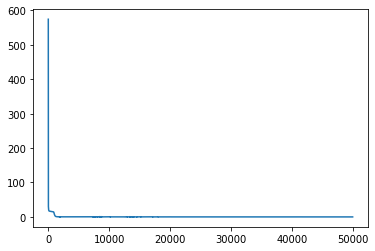

Epoch [51000/100000] Loss:0.041856 Loss_1:0.000076 Loss_2:0.041780 Loss_3: 0.000000 Lr:0.001639 Time:10.732309s (8.32min in total)
Epoch [52000/100000] Loss:0.042774 Loss_1:0.000005 Loss_2:0.042769 Loss_3: 0.000000 Lr:0.001613 Time:9.720727s (8.49min in total)
Epoch [53000/100000] Loss:0.044151 Loss_1:0.000543 Loss_2:0.043609 Loss_3: 0.000000 Lr:0.001587 Time:9.748286s (8.65min in total)
Epoch [54000/100000] Loss:0.042736 Loss_1:0.000101 Loss_2:0.042636 Loss_3: 0.000000 Lr:0.001563 Time:9.707079s (8.81min in total)
Epoch [55000/100000] Loss:0.038649 Loss_1:0.000001 Loss_2:0.038648 Loss_3: 0.000000 Lr:0.001538 Time:9.738590s (8.97min in total)
Epoch [56000/100000] Loss:0.042141 Loss_1:0.000075 Loss_2:0.042066 Loss_3: 0.000000 Lr:0.001515 Time:9.747638s (9.14min in total)
Epoch [57000/100000] Loss:0.040944 Loss_1:0.000044 Loss_2:0.040900 Loss_3: 0.000000 Lr:0.001493 Time:9.666657s (9.30min in total)
Epoch [58000/100000] Loss:0.039905 Loss_1:0.000219 Loss_2:0.039686 Loss_3: 0.000000 Lr:0.

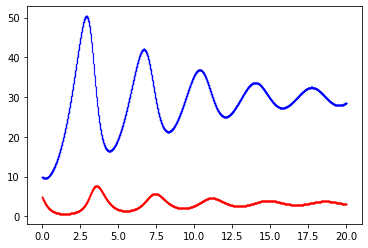

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_100000_1000_0.01_1.0_3.0_0.3_0.333_2022-03-28-21-30-19_1648503606.png


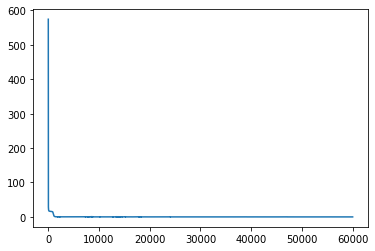

Epoch [61000/100000] Loss:0.033977 Loss_1:0.000009 Loss_2:0.033968 Loss_3: 0.000000 Lr:0.001408 Time:10.624789s (9.96min in total)
Epoch [62000/100000] Loss:0.034628 Loss_1:0.000001 Loss_2:0.034627 Loss_3: 0.000000 Lr:0.001389 Time:9.627933s (10.12min in total)
Epoch [63000/100000] Loss:0.032592 Loss_1:0.000008 Loss_2:0.032584 Loss_3: 0.000000 Lr:0.001370 Time:9.742707s (10.28min in total)
Epoch [64000/100000] Loss:0.041435 Loss_1:0.001096 Loss_2:0.040339 Loss_3: 0.000000 Lr:0.001351 Time:9.659058s (10.44min in total)
Epoch [65000/100000] Loss:0.046070 Loss_1:0.000044 Loss_2:0.046026 Loss_3: 0.000000 Lr:0.001333 Time:9.614318s (10.60min in total)
Epoch [66000/100000] Loss:0.053135 Loss_1:0.000533 Loss_2:0.052602 Loss_3: 0.000000 Lr:0.001316 Time:9.655042s (10.76min in total)
Epoch [67000/100000] Loss:0.029367 Loss_1:0.000004 Loss_2:0.029363 Loss_3: 0.000000 Lr:0.001299 Time:9.583911s (10.92min in total)
Epoch [68000/100000] Loss:0.092011 Loss_1:0.000849 Loss_2:0.091163 Loss_3: 0.000000

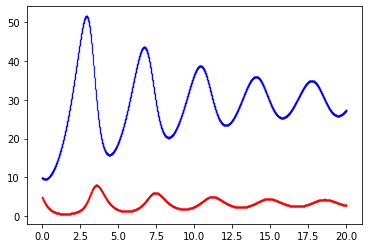

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_100000_1000_0.01_1.0_3.0_0.3_0.333_2022-03-28-21-30-19_1648503704.png


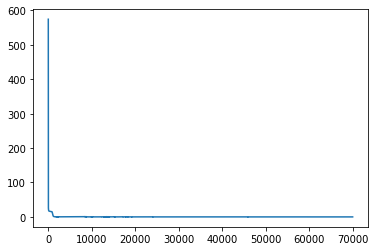

Epoch [71000/100000] Loss:0.026133 Loss_1:0.000007 Loss_2:0.026126 Loss_3: 0.000000 Lr:0.001235 Time:10.573830s (11.58min in total)
Epoch [72000/100000] Loss:0.025537 Loss_1:0.000009 Loss_2:0.025529 Loss_3: 0.000000 Lr:0.001220 Time:9.644458s (11.74min in total)
Epoch [73000/100000] Loss:0.026205 Loss_1:0.000329 Loss_2:0.025876 Loss_3: 0.000000 Lr:0.001205 Time:9.717840s (11.91min in total)
Epoch [74000/100000] Loss:0.024724 Loss_1:0.000019 Loss_2:0.024704 Loss_3: 0.000000 Lr:0.001190 Time:9.691896s (12.07min in total)
Epoch [75000/100000] Loss:0.027860 Loss_1:0.000549 Loss_2:0.027311 Loss_3: 0.000000 Lr:0.001176 Time:9.639607s (12.23min in total)
Epoch [76000/100000] Loss:0.022964 Loss_1:0.000004 Loss_2:0.022960 Loss_3: 0.000000 Lr:0.001163 Time:9.563969s (12.39min in total)
Epoch [77000/100000] Loss:0.022581 Loss_1:0.000049 Loss_2:0.022532 Loss_3: 0.000000 Lr:0.001149 Time:9.688232s (12.55min in total)
Epoch [78000/100000] Loss:0.042885 Loss_1:0.000052 Loss_2:0.042833 Loss_3: 0.00000

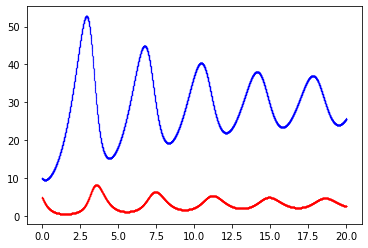

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_100000_1000_0.01_1.0_3.0_0.3_0.333_2022-03-28-21-30-19_1648503802.png


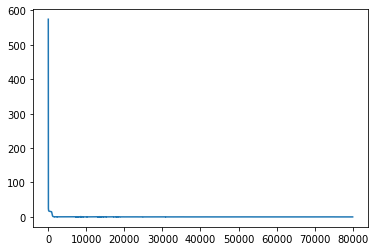

Epoch [81000/100000] Loss:0.022302 Loss_1:0.000082 Loss_2:0.022221 Loss_3: 0.000000 Lr:0.001099 Time:10.695560s (13.21min in total)
Epoch [82000/100000] Loss:0.020885 Loss_1:0.000003 Loss_2:0.020882 Loss_3: 0.000000 Lr:0.001087 Time:9.731869s (13.37min in total)
Epoch [83000/100000] Loss:0.063322 Loss_1:0.000833 Loss_2:0.062489 Loss_3: 0.000000 Lr:0.001075 Time:9.752207s (13.54min in total)
Epoch [84000/100000] Loss:0.024622 Loss_1:0.000080 Loss_2:0.024542 Loss_3: 0.000000 Lr:0.001064 Time:9.670373s (13.70min in total)
Epoch [85000/100000] Loss:0.022388 Loss_1:0.000009 Loss_2:0.022379 Loss_3: 0.000000 Lr:0.001053 Time:9.547974s (13.86min in total)
Epoch [86000/100000] Loss:0.020966 Loss_1:0.000060 Loss_2:0.020907 Loss_3: 0.000000 Lr:0.001042 Time:9.582334s (14.02min in total)
Epoch [87000/100000] Loss:0.018657 Loss_1:0.000003 Loss_2:0.018654 Loss_3: 0.000000 Lr:0.001031 Time:9.675485s (14.18min in total)
Epoch [88000/100000] Loss:0.017865 Loss_1:0.000005 Loss_2:0.017860 Loss_3: 0.00000

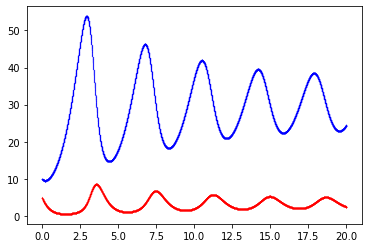

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_100000_1000_0.01_1.0_3.0_0.3_0.333_2022-03-28-21-30-19_1648503899.png


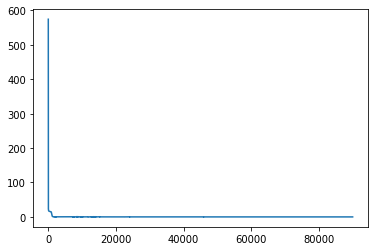

Epoch [91000/100000] Loss:0.017188 Loss_1:0.000060 Loss_2:0.017128 Loss_3: 0.000000 Lr:0.000990 Time:10.646674s (14.84min in total)
Epoch [92000/100000] Loss:0.017334 Loss_1:0.000008 Loss_2:0.017326 Loss_3: 0.000000 Lr:0.000980 Time:9.623270s (15.00min in total)
Epoch [93000/100000] Loss:0.016745 Loss_1:0.000200 Loss_2:0.016545 Loss_3: 0.000000 Lr:0.000971 Time:9.624942s (15.16min in total)
Epoch [94000/100000] Loss:0.019521 Loss_1:0.000012 Loss_2:0.019508 Loss_3: 0.000000 Lr:0.000962 Time:9.683490s (15.32min in total)
Epoch [95000/100000] Loss:0.020405 Loss_1:0.000052 Loss_2:0.020353 Loss_3: 0.000000 Lr:0.000952 Time:9.607680s (15.48min in total)
Epoch [96000/100000] Loss:0.015667 Loss_1:0.000048 Loss_2:0.015619 Loss_3: 0.000000 Lr:0.000943 Time:9.638442s (15.64min in total)
Epoch [97000/100000] Loss:0.015542 Loss_1:0.000010 Loss_2:0.015532 Loss_3: 0.000000 Lr:0.000935 Time:9.575492s (15.80min in total)
Epoch [98000/100000] Loss:0.015198 Loss_1:0.000013 Loss_2:0.015185 Loss_3: 0.00000

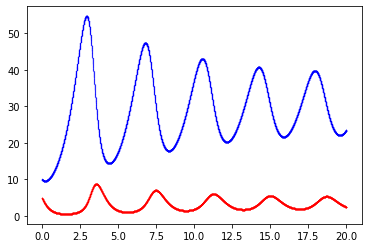

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_100000_1000_0.01_1.0_3.0_0.3_0.333_2022-03-28-21-30-19_1648503996.png


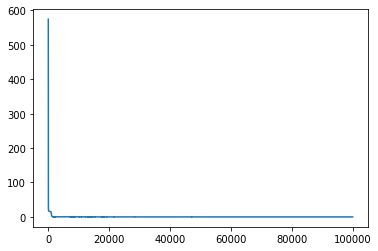

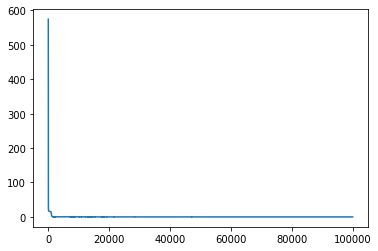


[Training Summary]
num_parameter: -1
best_loss: 0.015197915956377983
time_cost: 16.281749089558918


<Figure size 432x288 with 0 Axes>

In [ ]:
# design (b) 100000 / 1000 / 10000
main_path = "/content/drive/My Drive/Workspace/PINN"  # you may need to alter the path if it's not here
run_pp(main_path)

using cuda
epoch = 100000
epoch_step = 1000
model_name = SimpleNetworkPP
now_string = 2022-03-28-21-47-29
model_save_path_last = /content/drive/My Drive/Workspace/PINN/train/SimpleNetworkPP_100000_1000_0.01_1.0_3.0_0.3_0.333_2022-03-28-21-47-29_last.pt
model_save_path_best = /content/drive/My Drive/Workspace/PINN/train/SimpleNetworkPP_100000_1000_0.01_1.0_3.0_0.3_0.333_2022-03-28-21-47-29_best.pt
loss_save_path = /content/drive/My Drive/Workspace/PINN/loss/SimpleNetworkPP_100000_1000_0.01_1.0_3.0_0.3_0.333_2022-03-28-21-47-29_loss_100000.npy
Epoch [01000/100000] Loss:12.647819 Loss_1:3.451159 Loss_2:8.894968 Loss_3: 0.301692 Lr:0.009091 Time:10.133096s (0.17min in total)
Epoch [02000/100000] Loss:3.283460 Loss_1:0.357358 Loss_2:2.856539 Loss_3: 0.069564 Lr:0.008333 Time:10.065696s (0.34min in total)
Epoch [03000/100000] Loss:2.167285 Loss_1:0.054050 Loss_2:2.045537 Loss_3: 0.067698 Lr:0.007692 Time:10.082959s (0.50min in total)
Epoch [04000/100000] Loss:2.039903 Loss_1:0.056498 Loss_2:

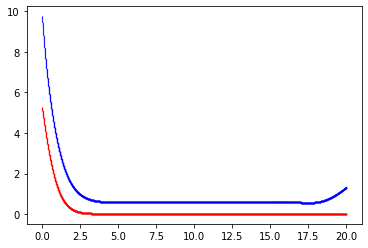

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_100000_1000_0.01_1.0_3.0_0.3_0.333_2022-03-28-21-47-29_1648504151.png


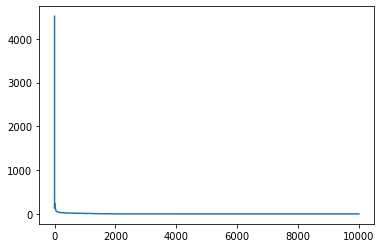

Epoch [11000/100000] Loss:2.006845 Loss_1:0.045877 Loss_2:1.896136 Loss_3: 0.064831 Lr:0.004762 Time:10.890976s (1.88min in total)
Epoch [12000/100000] Loss:2.004282 Loss_1:0.091262 Loss_2:1.846582 Loss_3: 0.066438 Lr:0.004545 Time:10.138504s (2.05min in total)
Epoch [13000/100000] Loss:2.000294 Loss_1:0.051167 Loss_2:1.885732 Loss_3: 0.063395 Lr:0.004348 Time:10.144264s (2.22min in total)
Epoch [14000/100000] Loss:2.042813 Loss_1:0.191488 Loss_2:1.778488 Loss_3: 0.072837 Lr:0.004167 Time:10.078541s (2.39min in total)
Epoch [15000/100000] Loss:1.992062 Loss_1:0.063678 Loss_2:1.865999 Loss_3: 0.062385 Lr:0.004000 Time:10.132396s (2.56min in total)
Epoch [16000/100000] Loss:285.391663 Loss_1:7.780676 Loss_2:277.610992 Loss_3: 0.000001 Lr:0.003846 Time:10.102947s (2.73min in total)
Epoch [17000/100000] Loss:17.717670 Loss_1:2.214212 Loss_2:15.503459 Loss_3: 0.000000 Lr:0.003704 Time:10.041155s (2.89min in total)
Epoch [18000/100000] Loss:4.898756 Loss_1:1.623999 Loss_2:3.274757 Loss_3: 0.

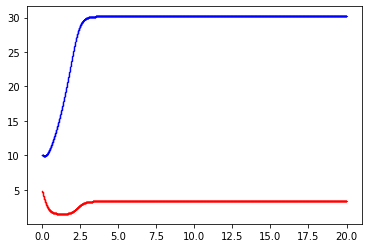

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_100000_1000_0.01_1.0_3.0_0.3_0.333_2022-03-28-21-47-29_1648504253.png


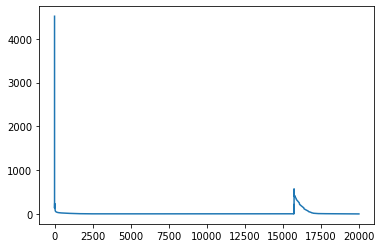

Epoch [21000/100000] Loss:0.219971 Loss_1:0.000556 Loss_2:0.219415 Loss_3: 0.000000 Lr:0.003226 Time:10.984570s (3.58min in total)
Epoch [22000/100000] Loss:0.220921 Loss_1:0.001233 Loss_2:0.219689 Loss_3: 0.000000 Lr:0.003125 Time:10.087168s (3.75min in total)
Epoch [23000/100000] Loss:0.180082 Loss_1:0.000216 Loss_2:0.179866 Loss_3: 0.000000 Lr:0.003030 Time:10.146070s (3.92min in total)
Epoch [24000/100000] Loss:0.160822 Loss_1:0.000177 Loss_2:0.160645 Loss_3: 0.000000 Lr:0.002941 Time:10.056114s (4.09min in total)
Epoch [25000/100000] Loss:0.149538 Loss_1:0.000144 Loss_2:0.149394 Loss_3: 0.000000 Lr:0.002857 Time:10.089640s (4.25min in total)
Epoch [26000/100000] Loss:0.156795 Loss_1:0.000931 Loss_2:0.155864 Loss_3: 0.000000 Lr:0.002778 Time:10.053199s (4.42min in total)
Epoch [27000/100000] Loss:0.145586 Loss_1:0.000262 Loss_2:0.145324 Loss_3: 0.000000 Lr:0.002703 Time:10.154245s (4.59min in total)
Epoch [28000/100000] Loss:0.134675 Loss_1:0.000434 Loss_2:0.134241 Loss_3: 0.000000

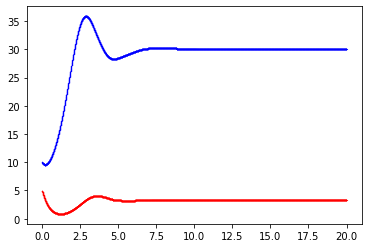

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_100000_1000_0.01_1.0_3.0_0.3_0.333_2022-03-28-21-47-29_1648504355.png


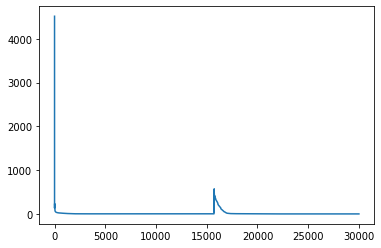

Epoch [31000/100000] Loss:0.115603 Loss_1:0.000008 Loss_2:0.115596 Loss_3: 0.000000 Lr:0.002439 Time:11.058381s (5.28min in total)
Epoch [32000/100000] Loss:0.102404 Loss_1:0.000118 Loss_2:0.102286 Loss_3: 0.000000 Lr:0.002381 Time:10.164409s (5.45min in total)
Epoch [33000/100000] Loss:0.191272 Loss_1:0.002318 Loss_2:0.188954 Loss_3: 0.000000 Lr:0.002326 Time:10.197202s (5.62min in total)
Epoch [34000/100000] Loss:0.087099 Loss_1:0.000036 Loss_2:0.087063 Loss_3: 0.000000 Lr:0.002273 Time:10.041837s (5.79min in total)
Epoch [35000/100000] Loss:0.083152 Loss_1:0.000253 Loss_2:0.082898 Loss_3: 0.000000 Lr:0.002222 Time:10.159113s (5.96min in total)
Epoch [36000/100000] Loss:0.076890 Loss_1:0.000009 Loss_2:0.076881 Loss_3: 0.000000 Lr:0.002174 Time:10.217413s (6.13min in total)
Epoch [37000/100000] Loss:0.072750 Loss_1:0.000017 Loss_2:0.072734 Loss_3: 0.000000 Lr:0.002128 Time:10.124392s (6.29min in total)
Epoch [38000/100000] Loss:0.069773 Loss_1:0.000011 Loss_2:0.069761 Loss_3: 0.000000

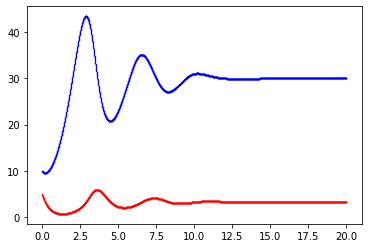

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_100000_1000_0.01_1.0_3.0_0.3_0.333_2022-03-28-21-47-29_1648504457.png


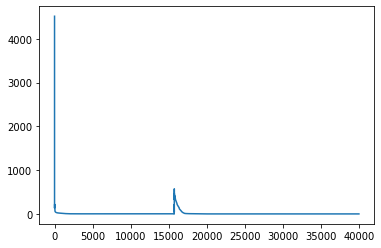

Epoch [41000/100000] Loss:0.063737 Loss_1:0.000006 Loss_2:0.063731 Loss_3: 0.000000 Lr:0.001961 Time:11.101240s (6.99min in total)
Epoch [42000/100000] Loss:0.062113 Loss_1:0.000009 Loss_2:0.062105 Loss_3: 0.000000 Lr:0.001923 Time:10.194566s (7.16min in total)
Epoch [43000/100000] Loss:0.066815 Loss_1:0.000146 Loss_2:0.066669 Loss_3: 0.000000 Lr:0.001887 Time:10.148552s (7.33min in total)
Epoch [44000/100000] Loss:0.059563 Loss_1:0.000007 Loss_2:0.059556 Loss_3: 0.000000 Lr:0.001852 Time:10.173908s (7.50min in total)
Epoch [45000/100000] Loss:0.061599 Loss_1:0.000070 Loss_2:0.061529 Loss_3: 0.000000 Lr:0.001818 Time:10.195074s (7.67min in total)
Epoch [46000/100000] Loss:0.092987 Loss_1:0.000460 Loss_2:0.092527 Loss_3: 0.000000 Lr:0.001786 Time:10.110126s (7.84min in total)
Epoch [47000/100000] Loss:0.057064 Loss_1:0.000001 Loss_2:0.057063 Loss_3: 0.000000 Lr:0.001754 Time:10.158253s (8.01min in total)
Epoch [48000/100000] Loss:0.063548 Loss_1:0.000060 Loss_2:0.063487 Loss_3: 0.000000

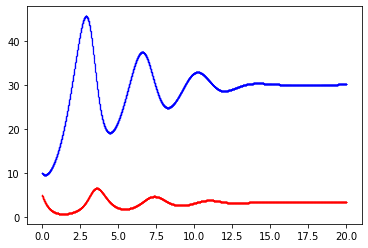

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_100000_1000_0.01_1.0_3.0_0.3_0.333_2022-03-28-21-47-29_1648504560.png


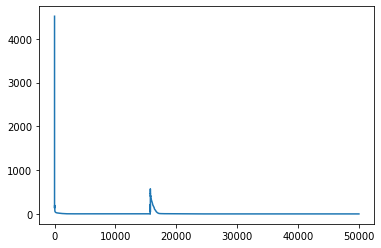

Epoch [51000/100000] Loss:0.052568 Loss_1:0.000009 Loss_2:0.052559 Loss_3: 0.000000 Lr:0.001639 Time:11.168660s (8.70min in total)
Epoch [52000/100000] Loss:0.051863 Loss_1:0.000008 Loss_2:0.051854 Loss_3: 0.000000 Lr:0.001613 Time:10.269629s (8.87min in total)
Epoch [53000/100000] Loss:0.074837 Loss_1:0.000325 Loss_2:0.074511 Loss_3: 0.000000 Lr:0.001587 Time:10.280981s (9.04min in total)
Epoch [54000/100000] Loss:0.050146 Loss_1:0.000008 Loss_2:0.050138 Loss_3: 0.000000 Lr:0.001563 Time:10.187258s (9.21min in total)
Epoch [55000/100000] Loss:0.089935 Loss_1:0.000190 Loss_2:0.089745 Loss_3: 0.000000 Lr:0.001538 Time:10.276690s (9.39min in total)
Epoch [56000/100000] Loss:0.048702 Loss_1:0.000008 Loss_2:0.048694 Loss_3: 0.000000 Lr:0.001515 Time:10.192368s (9.56min in total)
Epoch [57000/100000] Loss:0.065149 Loss_1:0.000408 Loss_2:0.064741 Loss_3: 0.000000 Lr:0.001493 Time:10.265237s (9.73min in total)
Epoch [58000/100000] Loss:0.047416 Loss_1:0.000008 Loss_2:0.047409 Loss_3: 0.000000

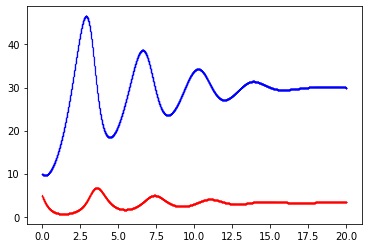

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_100000_1000_0.01_1.0_3.0_0.3_0.333_2022-03-28-21-47-29_1648504663.png


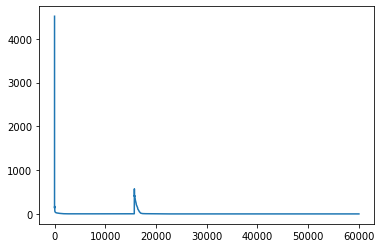

Epoch [61000/100000] Loss:0.046051 Loss_1:0.000004 Loss_2:0.046047 Loss_3: 0.000000 Lr:0.001408 Time:11.154112s (10.42min in total)
Epoch [62000/100000] Loss:0.045609 Loss_1:0.000008 Loss_2:0.045601 Loss_3: 0.000000 Lr:0.001389 Time:10.241296s (10.59min in total)
Epoch [63000/100000] Loss:0.045309 Loss_1:0.000008 Loss_2:0.045301 Loss_3: 0.000000 Lr:0.001370 Time:10.258426s (10.76min in total)
Epoch [64000/100000] Loss:0.044810 Loss_1:0.000007 Loss_2:0.044803 Loss_3: 0.000000 Lr:0.001351 Time:10.193082s (10.93min in total)
Epoch [65000/100000] Loss:0.044379 Loss_1:0.000007 Loss_2:0.044372 Loss_3: 0.000000 Lr:0.001333 Time:10.345670s (11.11min in total)
Epoch [66000/100000] Loss:0.044045 Loss_1:0.000005 Loss_2:0.044039 Loss_3: 0.000000 Lr:0.001316 Time:10.294688s (11.28min in total)
Epoch [67000/100000] Loss:0.043518 Loss_1:0.000005 Loss_2:0.043513 Loss_3: 0.000000 Lr:0.001299 Time:10.252245s (11.45min in total)
Epoch [68000/100000] Loss:0.043136 Loss_1:0.000006 Loss_2:0.043131 Loss_3: 0

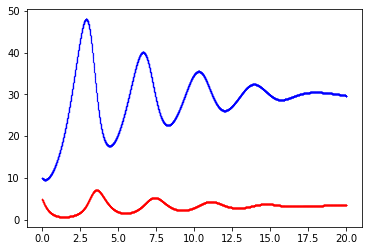

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_100000_1000_0.01_1.0_3.0_0.3_0.333_2022-03-28-21-47-29_1648504767.png


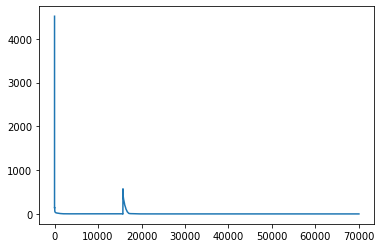

Epoch [71000/100000] Loss:0.042242 Loss_1:0.000009 Loss_2:0.042233 Loss_3: 0.000000 Lr:0.001235 Time:11.175034s (12.15min in total)
Epoch [72000/100000] Loss:0.045526 Loss_1:0.000044 Loss_2:0.045482 Loss_3: 0.000000 Lr:0.001220 Time:10.354206s (12.32min in total)
Epoch [73000/100000] Loss:0.041455 Loss_1:0.000006 Loss_2:0.041449 Loss_3: 0.000000 Lr:0.001205 Time:10.149659s (12.49min in total)
Epoch [74000/100000] Loss:0.041247 Loss_1:0.000011 Loss_2:0.041236 Loss_3: 0.000000 Lr:0.001190 Time:10.258676s (12.66min in total)
Epoch [75000/100000] Loss:0.040546 Loss_1:0.000005 Loss_2:0.040540 Loss_3: 0.000000 Lr:0.001176 Time:10.237232s (12.83min in total)
Epoch [76000/100000] Loss:0.040367 Loss_1:0.000002 Loss_2:0.040365 Loss_3: 0.000000 Lr:0.001163 Time:10.310181s (13.00min in total)
Epoch [77000/100000] Loss:0.041090 Loss_1:0.000014 Loss_2:0.041076 Loss_3: 0.000000 Lr:0.001149 Time:10.197999s (13.17min in total)
Epoch [78000/100000] Loss:0.039838 Loss_1:0.000013 Loss_2:0.039826 Loss_3: 0

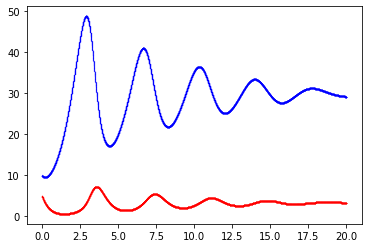

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_100000_1000_0.01_1.0_3.0_0.3_0.333_2022-03-28-21-47-29_1648504870.png


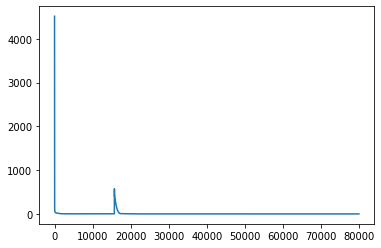

Epoch [81000/100000] Loss:0.038528 Loss_1:0.000005 Loss_2:0.038523 Loss_3: 0.000000 Lr:0.001099 Time:11.254851s (13.87min in total)
Epoch [82000/100000] Loss:0.038302 Loss_1:0.000005 Loss_2:0.038298 Loss_3: 0.000000 Lr:0.001087 Time:10.256518s (14.04min in total)
Epoch [83000/100000] Loss:0.038118 Loss_1:0.000004 Loss_2:0.038114 Loss_3: 0.000000 Lr:0.001075 Time:10.311075s (14.22min in total)
Epoch [84000/100000] Loss:0.038023 Loss_1:0.000007 Loss_2:0.038016 Loss_3: 0.000000 Lr:0.001064 Time:10.323434s (14.39min in total)
Epoch [85000/100000] Loss:0.039095 Loss_1:0.000025 Loss_2:0.039070 Loss_3: 0.000000 Lr:0.001053 Time:10.290005s (14.56min in total)
Epoch [86000/100000] Loss:0.037316 Loss_1:0.000005 Loss_2:0.037311 Loss_3: 0.000000 Lr:0.001042 Time:10.217103s (14.73min in total)
Epoch [87000/100000] Loss:0.037096 Loss_1:0.000004 Loss_2:0.037091 Loss_3: 0.000000 Lr:0.001031 Time:10.263329s (14.90min in total)
Epoch [88000/100000] Loss:0.036742 Loss_1:0.000003 Loss_2:0.036739 Loss_3: 0

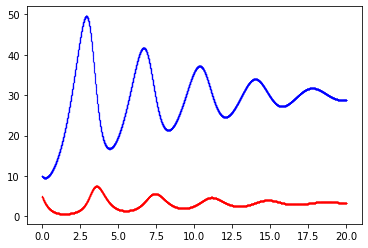

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_100000_1000_0.01_1.0_3.0_0.3_0.333_2022-03-28-21-47-29_1648504974.png


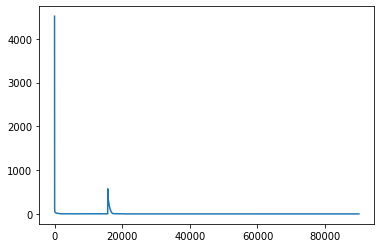

Epoch [91000/100000] Loss:0.035708 Loss_1:0.000004 Loss_2:0.035704 Loss_3: 0.000000 Lr:0.000990 Time:11.264336s (15.60min in total)
Epoch [92000/100000] Loss:0.035478 Loss_1:0.000003 Loss_2:0.035475 Loss_3: 0.000000 Lr:0.000980 Time:10.070790s (15.77min in total)
Epoch [93000/100000] Loss:0.035174 Loss_1:0.000003 Loss_2:0.035170 Loss_3: 0.000000 Lr:0.000971 Time:10.305108s (15.94min in total)
Epoch [94000/100000] Loss:0.034760 Loss_1:0.000004 Loss_2:0.034756 Loss_3: 0.000000 Lr:0.000962 Time:10.172677s (16.11min in total)
Epoch [95000/100000] Loss:0.034480 Loss_1:0.000004 Loss_2:0.034476 Loss_3: 0.000000 Lr:0.000952 Time:10.155367s (16.28min in total)
Epoch [96000/100000] Loss:0.039759 Loss_1:0.000052 Loss_2:0.039707 Loss_3: 0.000000 Lr:0.000943 Time:10.344781s (16.45min in total)
Epoch [97000/100000] Loss:0.103962 Loss_1:0.000275 Loss_2:0.103687 Loss_3: 0.000000 Lr:0.000935 Time:10.151649s (16.62min in total)
Epoch [98000/100000] Loss:0.033338 Loss_1:0.000003 Loss_2:0.033334 Loss_3: 0

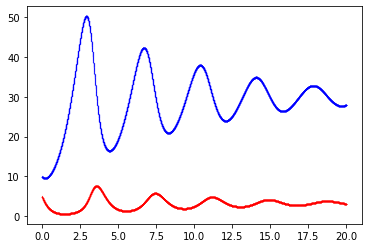

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_100000_1000_0.01_1.0_3.0_0.3_0.333_2022-03-28-21-47-29_1648505077.png


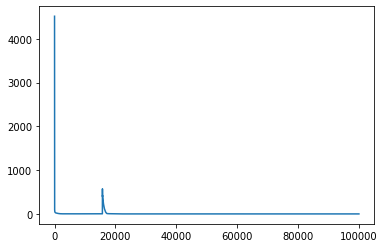

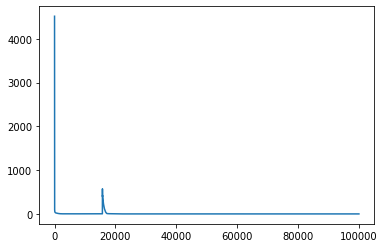


[Training Summary]
num_parameter: -1
best_loss: 0.03333751857280731
time_cost: 17.132551709810894


<Figure size 432x288 with 0 Axes>

In [ ]:
# design (a) 100000 / 1000 / 10000
main_path = "/content/drive/My Drive/Workspace/PINN"  # you may need to alter the path if it's not here
run_pp(main_path)

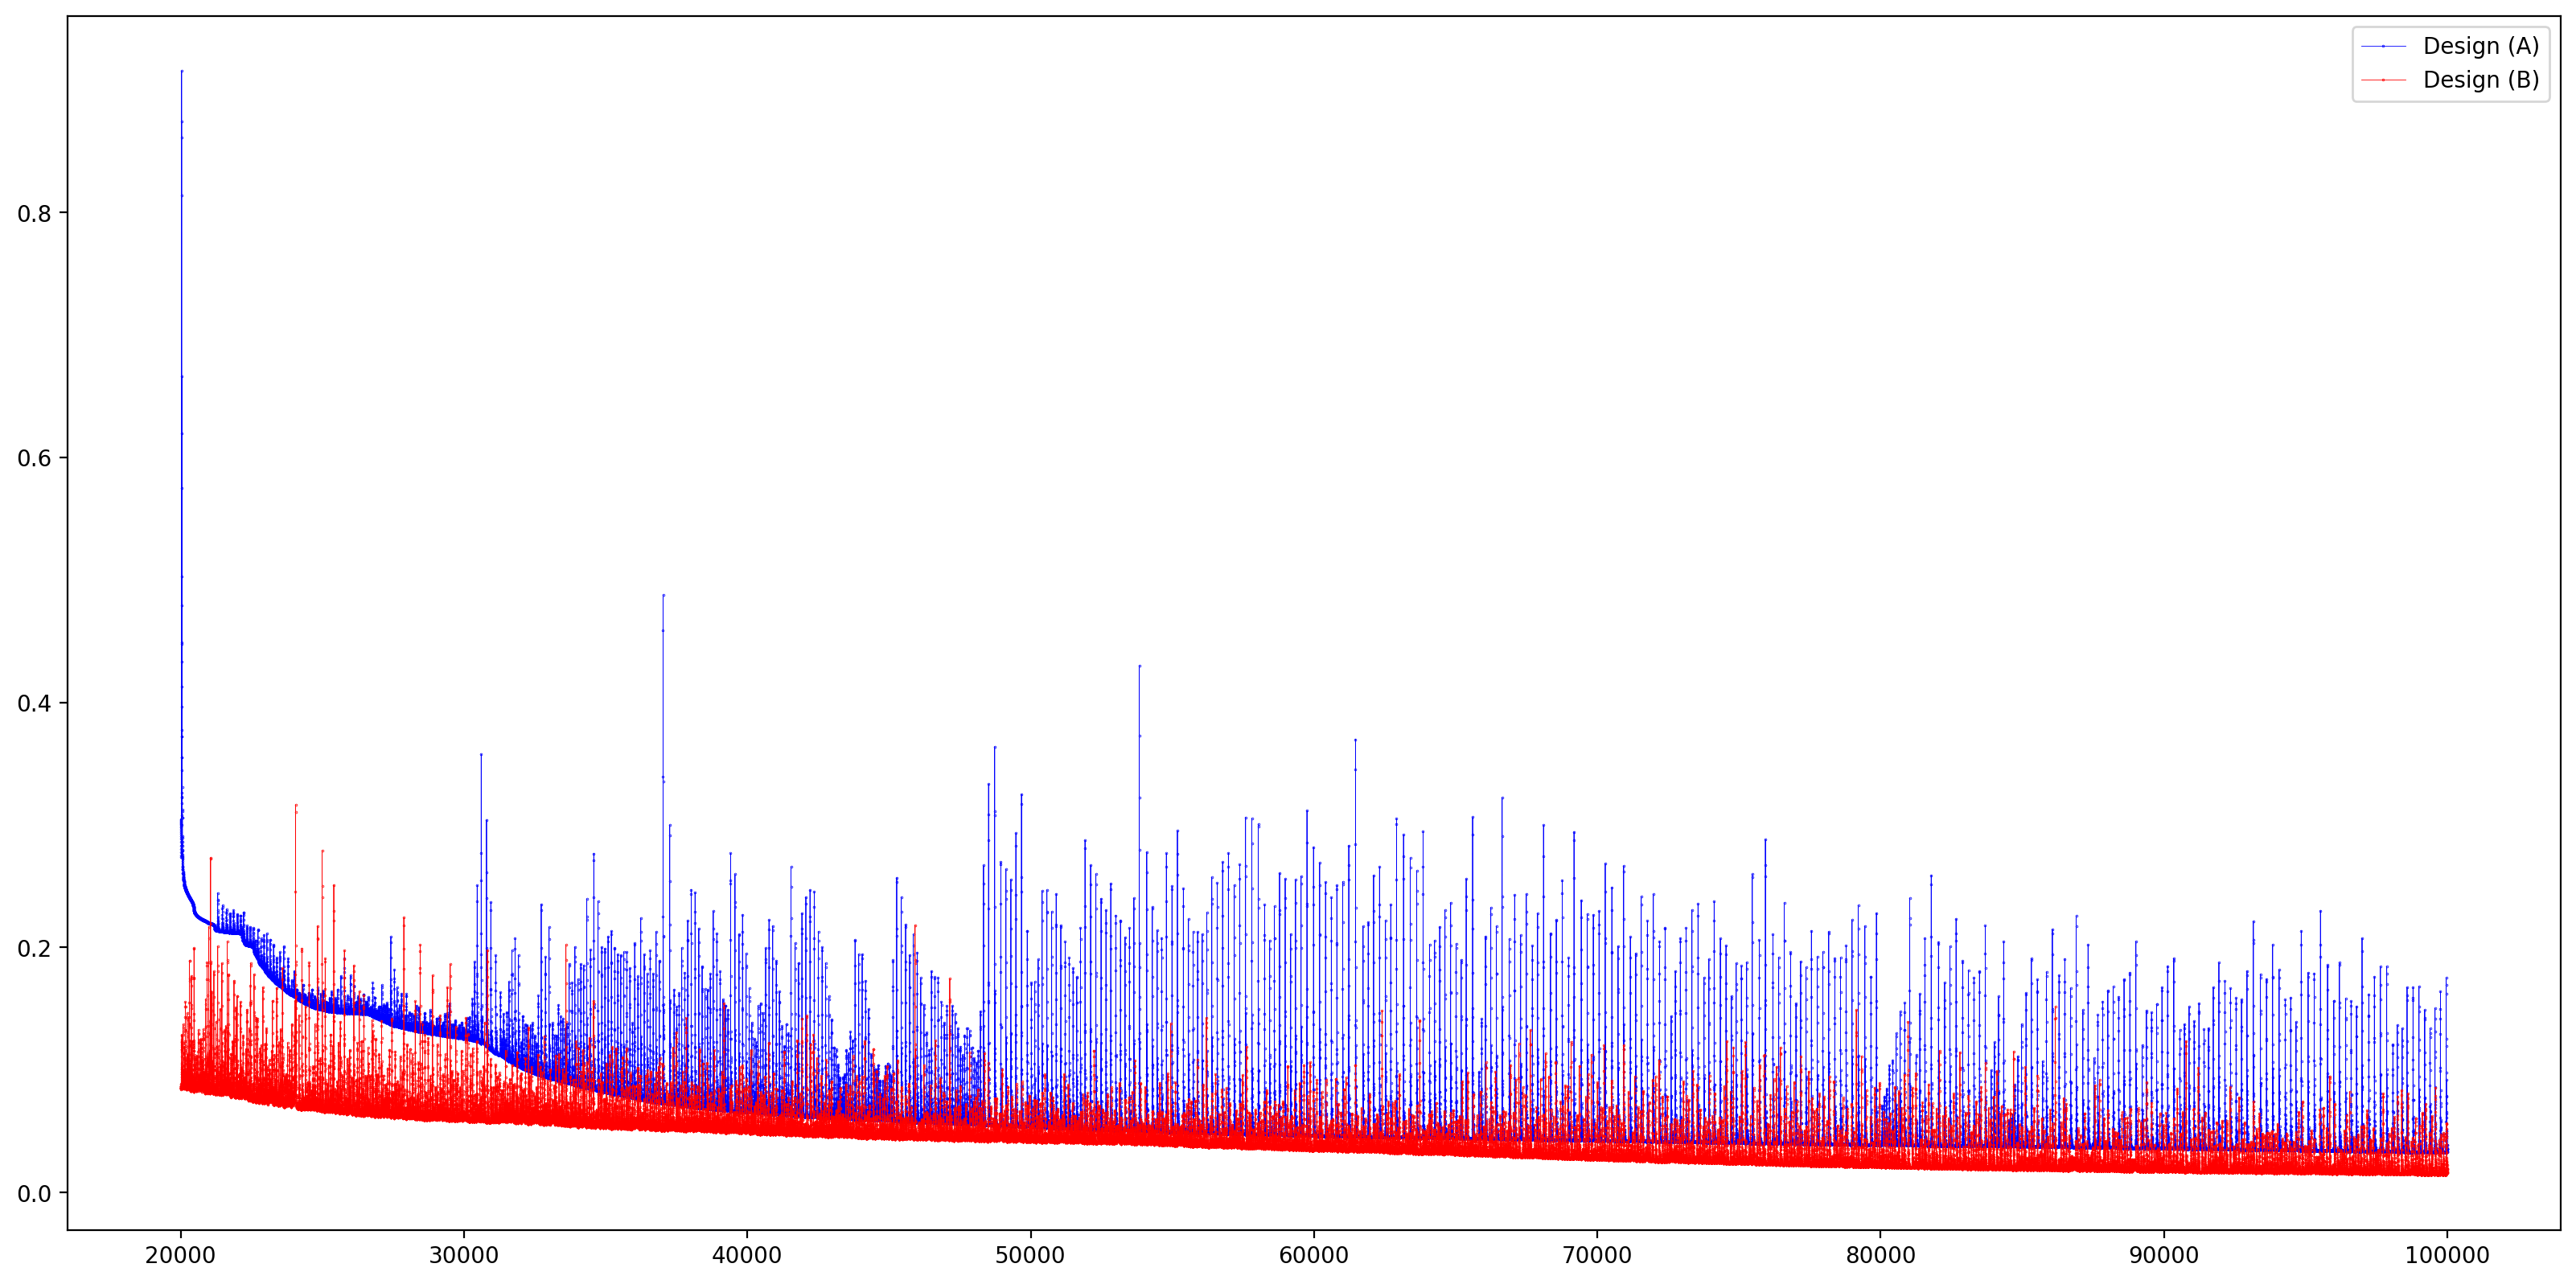

<Figure size 432x288 with 0 Axes>

In [ ]:
# loss
loss_a = np.load("/content/drive/My Drive/Workspace/PINN/loss/SimpleNetworkPP_100000_1000_0.01_1.0_3.0_0.3_0.333_2022-03-28-21-47-29_loss_100000.npy")
loss_b = np.load("/content/drive/My Drive/Workspace/PINN/loss/SimpleNetworkPP_100000_1000_0.01_1.0_3.0_0.3_0.333_2022-03-28-21-30-19_loss_100000.npy")

start = 20000
end = len(loss_a)
x = range(start + 1, end + 1)
plt.figure(dpi=200, figsize=[20,10])
plt.plot(x, loss_a[start:], marker='.', markersize=0.5, linewidth=0.3, c="b")
plt.plot(x, loss_b[start:], marker='.', markersize=0.5, linewidth=0.3, c="r")
plt.legend(["Design (A)","Design (B)"])
plt.show()
plt.clf()

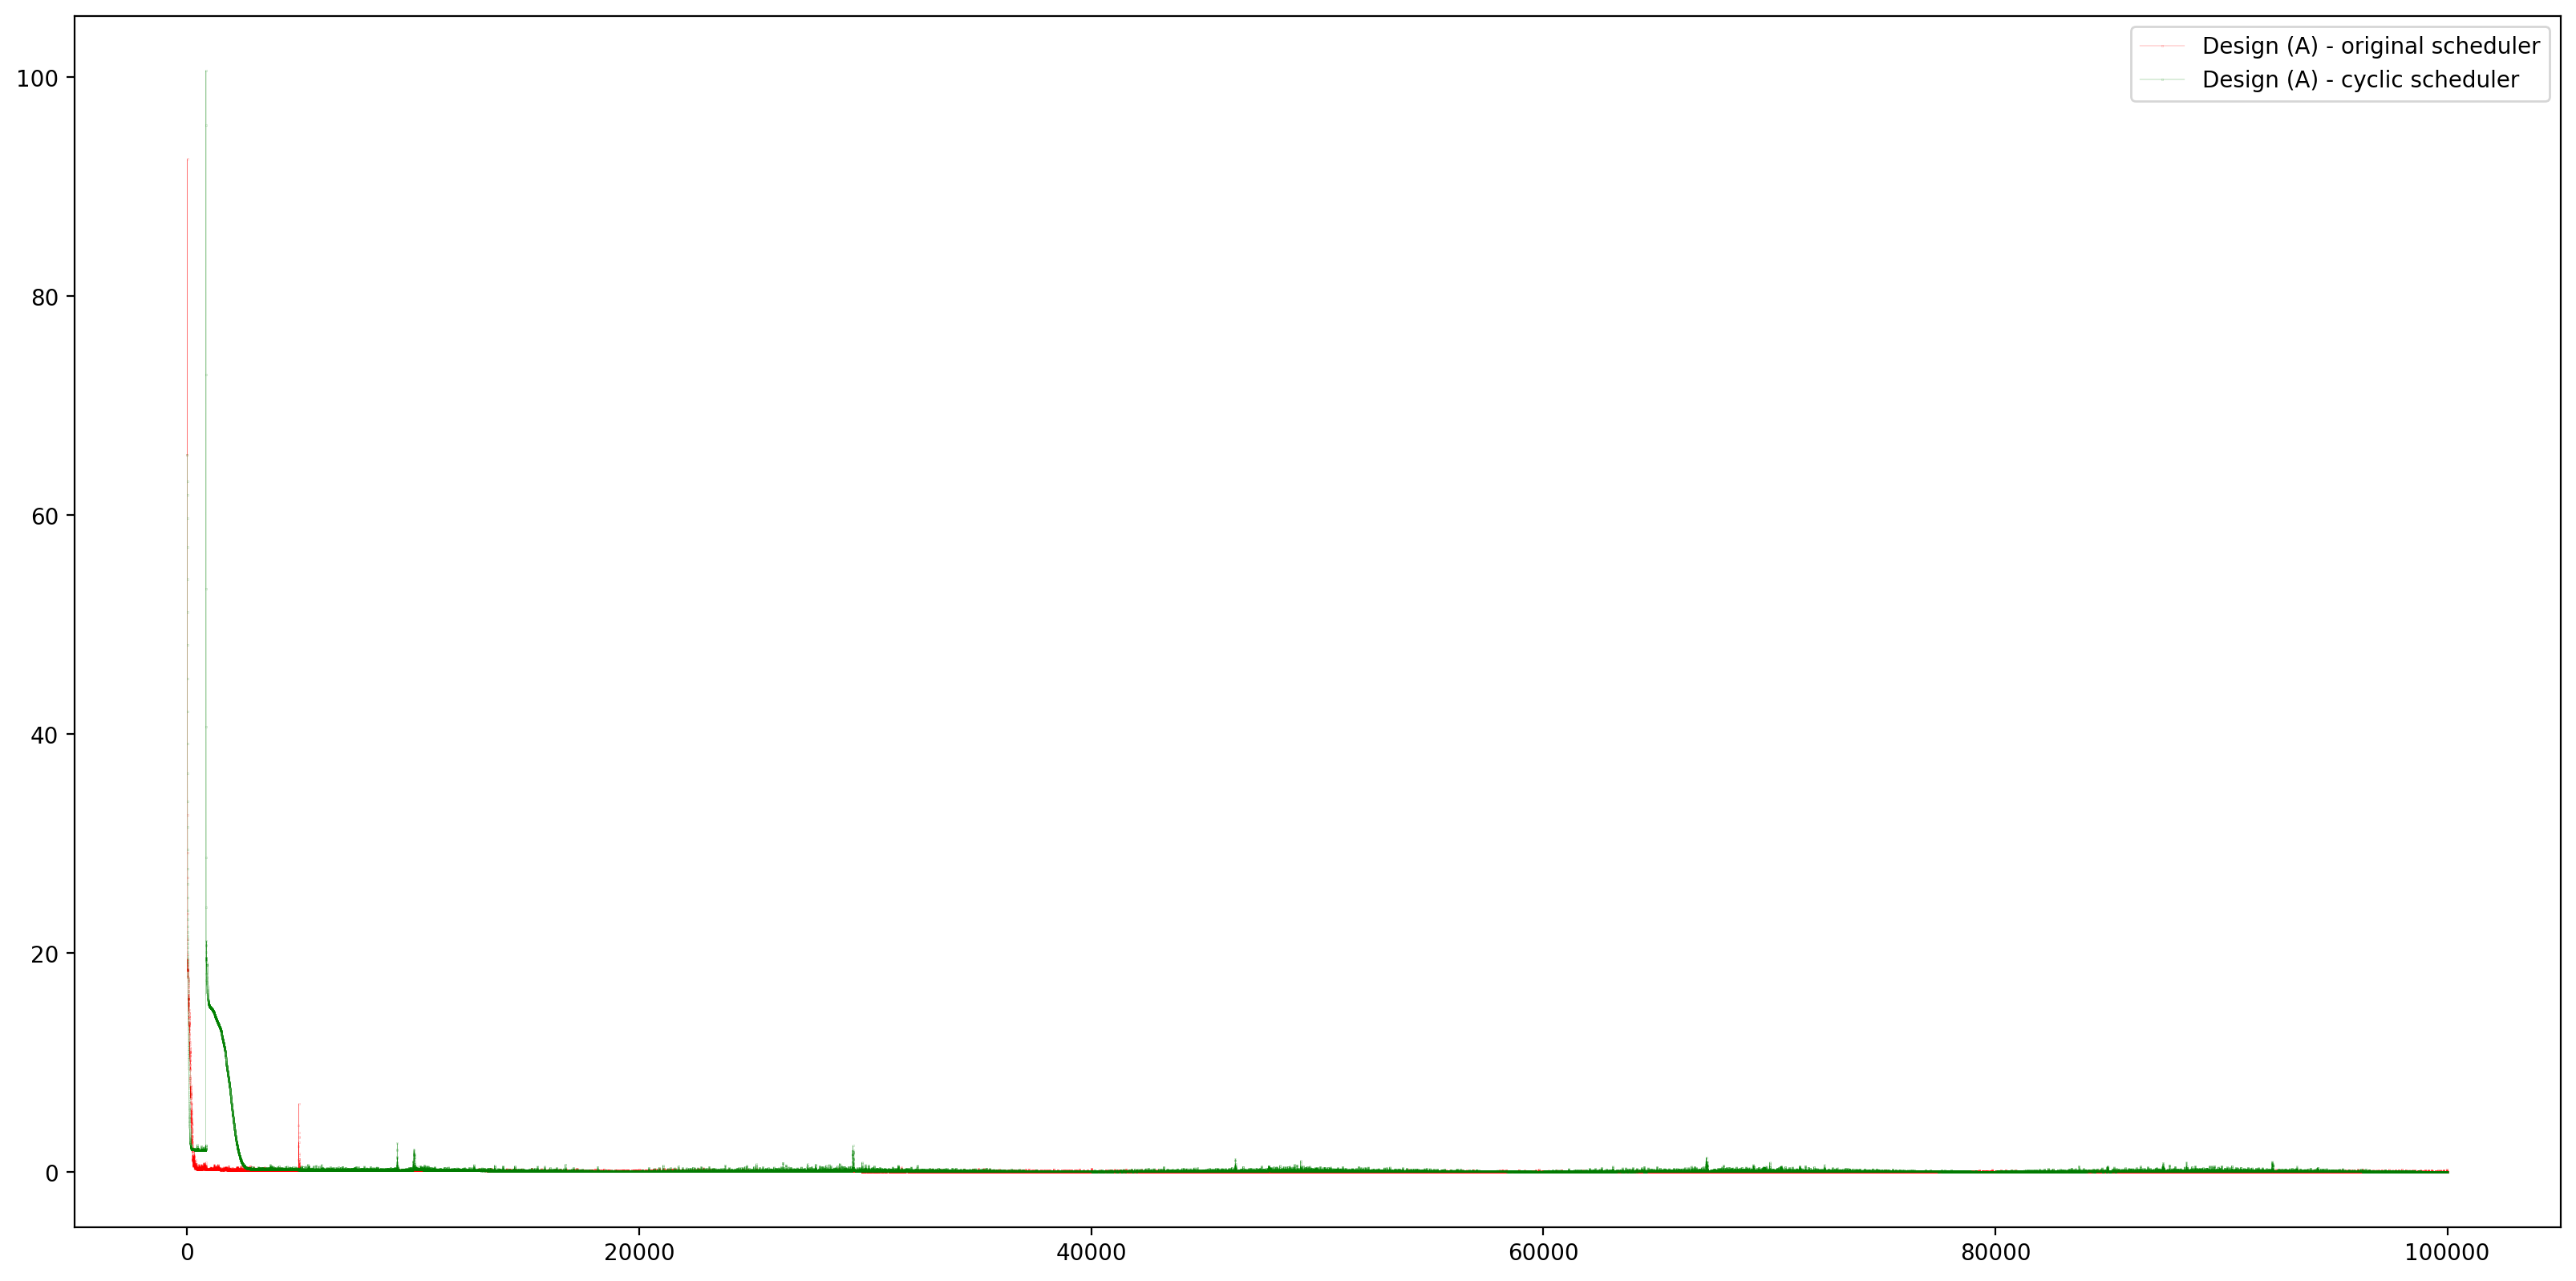

<Figure size 432x288 with 0 Axes>

In [58]:
# loss
loss_a = np.load("/content/drive/My Drive/Workspace/PINN/loss/SimpleNetworkPP_100000_1000_0.01_1.0_3.0_0.3_0.333_2022-04-22-00-38-13_loss_100000.npy")
loss_a_cycle = np.load("/content/drive/My Drive/Workspace/PINN/loss/SimpleNetworkPP_100000_1000_0.01_1.0_3.0_0.3_0.333_2022-04-22-01-07-17_loss_100000.npy")

start = 0000
end = len(loss_a)
x = range(start + 1, end + 1)
plt.figure(dpi=200, figsize=[20,10])
plt.plot(x, loss_a[start:], marker='.', markersize=0.1, linewidth=0.1, c="r")
plt.plot(x, loss_a_cycle[start:], marker='.', markersize=0.1, linewidth=0.1, c="g")
plt.legend(["Design (A) - original scheduler", "Design (A) - cyclic scheduler"])
plt.show()
plt.clf()

In [ ]:
import torch


In [ ]:
main_path = "/content/drive/My Drive/Workspace/PINN"  # you may need to alter the path if it's not here
run_pp(main_path)

Output hidden; open in https://colab.research.google.com to view.

using cuda
epoch = 50000
epoch_step = 100
model_name = SimpleNetworkPP
now_string = 2022-03-26-23-41-36
model_save_path_last = /content/drive/My Drive/Workspace/PINN/train/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_last.pt
model_save_path_best = /content/drive/My Drive/Workspace/PINN/train/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_best.pt
Epoch [00100/50000] Loss:51.838360 Loss_1:0.253591 Loss_2:47.437141 Lr:0.009091 Time:0.796831s
Epoch [00200/50000] Loss:49.782753 Loss_1:0.195372 Loss_2:45.317219 Lr:0.008333 Time:0.792318s
Epoch [00300/50000] Loss:48.915333 Loss_1:0.266340 Loss_2:45.732475 Lr:0.007692 Time:0.803477s
Epoch [00400/50000] Loss:0.641632 Loss_1:0.132566 Loss_2:0.509065 Lr:0.007143 Time:0.791494s
Epoch [00500/50000] Loss:0.198274 Loss_1:0.003468 Loss_2:0.194806 Lr:0.006667 Time:0.791440s
Testing & drawing...
u= [10.045646, 10.05103, 10.056431, 10.061854, 10.067299, 10.072764, 10.078247, 10.083754, 10.08928, 10.094821] ..

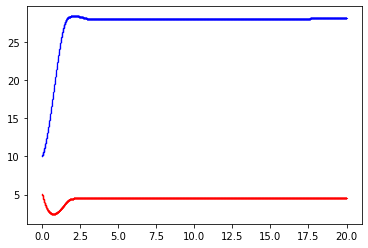

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338100.png
Epoch [00600/50000] Loss:0.187327 Loss_1:0.000958 Loss_2:0.186369 Lr:0.006250 Time:1.288194s
Epoch [00700/50000] Loss:0.187999 Loss_1:0.004394 Loss_2:0.183605 Lr:0.005882 Time:0.791157s
Epoch [00800/50000] Loss:0.191862 Loss_1:0.008849 Loss_2:0.183013 Lr:0.005556 Time:0.791351s
Epoch [00900/50000] Loss:0.171719 Loss_1:0.004310 Loss_2:0.167409 Lr:0.005263 Time:0.795263s
Epoch [01000/50000] Loss:0.175206 Loss_1:0.015682 Loss_2:0.159524 Lr:0.005000 Time:0.790680s
Testing & drawing...
u= [9.94303, 9.947569, 9.952129, 9.956718, 9.961331, 9.965972, 9.970632, 9.975322, 9.980037, 9.984772] ... [27.919569, 27.919569, 27.919569, 27.919569, 27.919569, 27.919569, 27.919569, 27.919569, 27.919569, 27.919569]
v= [4.8680067, 4.8600926, 4.852166, 4.8442173, 4.836254, 4.828275, 4.8202877, 4.8122835, 4.804266, 4.7962446] ... [4.535506, 4.535506, 4.5355053, 4.535505, 4

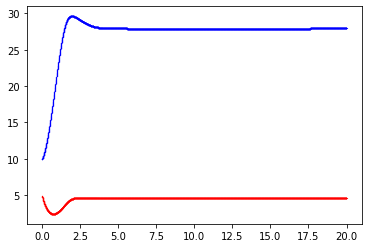

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338104.png
Epoch [01100/50000] Loss:0.156296 Loss_1:0.005931 Loss_2:0.150366 Lr:0.004762 Time:1.334906s
Epoch [01200/50000] Loss:0.193348 Loss_1:0.034154 Loss_2:0.159193 Lr:0.004545 Time:0.811385s
Epoch [01300/50000] Loss:0.114809 Loss_1:0.000194 Loss_2:0.114616 Lr:0.004348 Time:0.791262s
Epoch [01400/50000] Loss:0.108993 Loss_1:0.000892 Loss_2:0.108101 Lr:0.004167 Time:0.791589s
Epoch [01500/50000] Loss:0.129042 Loss_1:0.012475 Loss_2:0.116568 Lr:0.004000 Time:0.794257s
Testing & drawing...
u= [9.946232, 9.950512, 9.954815, 9.959156, 9.963524, 9.967922, 9.972351, 9.97681, 9.9813, 9.985821] ... [27.839674, 27.839674, 27.839674, 27.839672, 27.839672, 27.839674, 27.839674, 27.839672, 27.839672, 27.839674]
v= [4.8850784, 4.877113, 4.8691325, 4.861131, 4.853115, 4.845084, 4.8370447, 4.828988, 4.8209214, 4.8128505] ... [4.53908, 4.539079, 4.5390787, 4.539078, 4.539

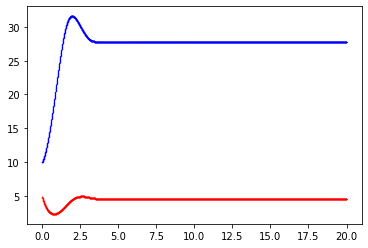

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338109.png
Epoch [01600/50000] Loss:0.100763 Loss_1:0.002216 Loss_2:0.098548 Lr:0.003846 Time:1.302704s
Epoch [01700/50000] Loss:0.096308 Loss_1:0.000760 Loss_2:0.095548 Lr:0.003704 Time:0.791449s
Epoch [01800/50000] Loss:0.132574 Loss_1:0.012359 Loss_2:0.120215 Lr:0.003571 Time:0.791396s
Epoch [01900/50000] Loss:0.103549 Loss_1:0.006831 Loss_2:0.096718 Lr:0.003448 Time:0.790960s
Epoch [02000/50000] Loss:0.094973 Loss_1:0.004413 Loss_2:0.090560 Lr:0.003333 Time:0.791331s
Testing & drawing...
u= [9.982896, 9.987462, 9.992061, 9.996693, 10.001361, 10.006057, 10.010787, 10.0155525, 10.02035, 10.02518] ... [27.829563, 27.829563, 27.829561, 27.829561, 27.829561, 27.829556, 27.829556, 27.829552, 27.829552, 27.829552]
v= [4.9540997, 4.94608, 4.9380426, 4.9299817, 4.9219036, 4.913807, 4.9057007, 4.8975744, 4.8894362, 4.8812914] ... [4.5341887, 4.5341887, 4.534188, 4.5

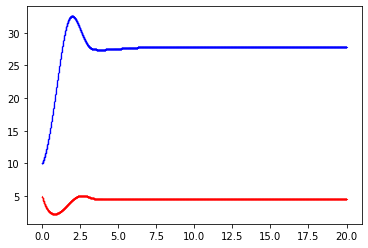

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338113.png
Epoch [02100/50000] Loss:0.083862 Loss_1:0.001681 Loss_2:0.082181 Lr:0.003226 Time:1.337145s
Epoch [02200/50000] Loss:0.079583 Loss_1:0.000989 Loss_2:0.078594 Lr:0.003125 Time:0.791753s
Epoch [02300/50000] Loss:0.075382 Loss_1:0.000511 Loss_2:0.074871 Lr:0.003030 Time:0.791821s
Epoch [02400/50000] Loss:0.109719 Loss_1:0.009165 Loss_2:0.100555 Lr:0.002941 Time:0.792368s
Epoch [02500/50000] Loss:0.121972 Loss_1:0.012907 Loss_2:0.109065 Lr:0.002857 Time:0.791067s
Testing & drawing...
u= [10.098196, 10.103518, 10.108869, 10.114259, 10.11968, 10.1251335, 10.130618, 10.136136, 10.141689, 10.147269] ... [27.828283, 27.828281, 27.828281, 27.828281, 27.82828, 27.828278, 27.828276, 27.828276, 27.828276, 27.828276]
v= [5.153359, 5.1460285, 5.1386547, 5.131229, 5.1237564, 5.116239, 5.1086802, 5.1010733, 5.0934234, 5.0857353] ... [4.516388, 4.5163875, 4.516387, 

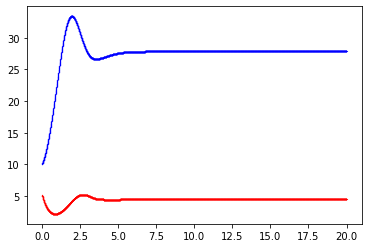

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338118.png
Epoch [02600/50000] Loss:0.067146 Loss_1:0.000030 Loss_2:0.067116 Lr:0.002778 Time:1.294525s
Epoch [02700/50000] Loss:0.068398 Loss_1:0.001321 Loss_2:0.067076 Lr:0.002703 Time:0.792456s
Epoch [02800/50000] Loss:0.082498 Loss_1:0.003776 Loss_2:0.078723 Lr:0.002632 Time:0.792296s
Epoch [02900/50000] Loss:0.061250 Loss_1:0.000071 Loss_2:0.061179 Lr:0.002564 Time:0.813035s
Epoch [03000/50000] Loss:0.060565 Loss_1:0.000696 Loss_2:0.059869 Lr:0.002500 Time:0.791159s
Testing & drawing...
u= [9.974003, 9.97827, 9.982571, 9.98691, 9.991289, 9.995704, 10.000154, 10.0046425, 10.009169, 10.013729] ... [27.820423, 27.82042, 27.82042, 27.820415, 27.820415, 27.820414, 27.820412, 27.82041, 27.820408, 27.820406]
v= [4.95298, 4.9449663, 4.936934, 4.9288745, 4.920793, 4.912693, 4.9045787, 4.896443, 4.8882904, 4.88013] ... [4.536765, 4.5367646, 4.5367637, 4.5367637, 4.

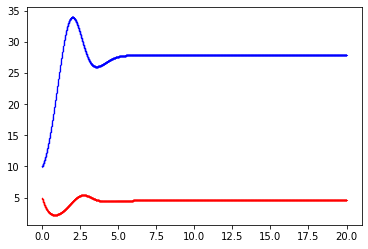

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338122.png
Epoch [03100/50000] Loss:0.056093 Loss_1:0.000023 Loss_2:0.056071 Lr:0.002439 Time:1.295051s
Epoch [03200/50000] Loss:0.056208 Loss_1:0.000540 Loss_2:0.055668 Lr:0.002381 Time:0.795257s
Epoch [03300/50000] Loss:0.052290 Loss_1:0.000860 Loss_2:0.051430 Lr:0.002326 Time:0.791635s
Epoch [03400/50000] Loss:0.057802 Loss_1:0.001973 Loss_2:0.055829 Lr:0.002273 Time:0.791535s
Epoch [03500/50000] Loss:0.054781 Loss_1:0.002683 Loss_2:0.052097 Lr:0.002222 Time:0.793013s
Testing & drawing...
u= [9.992528, 9.997019, 10.001543, 10.006109, 10.010711, 10.015353, 10.020026, 10.024741, 10.029495, 10.034283] ... [27.820124, 27.820124, 27.820124, 27.820124, 27.820124, 27.820124, 27.820124, 27.820124, 27.82012, 27.82012]
v= [4.9767284, 4.9684987, 4.960258, 4.9519987, 4.943727, 4.9354453, 4.9271574, 4.918858, 4.9105496, 4.9022408] ... [4.531429, 4.531429, 4.5314283, 4.5

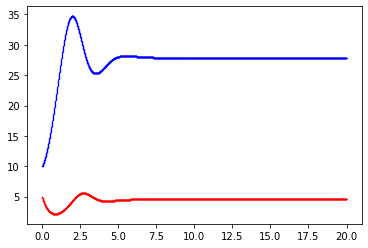

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338127.png
Epoch [03600/50000] Loss:0.056935 Loss_1:0.001983 Loss_2:0.054951 Lr:0.002174 Time:1.344917s
Epoch [03700/50000] Loss:0.057604 Loss_1:0.003739 Loss_2:0.053865 Lr:0.002128 Time:0.815700s
Epoch [03800/50000] Loss:0.041269 Loss_1:0.000146 Loss_2:0.041123 Lr:0.002083 Time:0.794589s
Epoch [03900/50000] Loss:0.053804 Loss_1:0.002038 Loss_2:0.051766 Lr:0.002041 Time:0.796459s
Epoch [04000/50000] Loss:0.050288 Loss_1:0.002652 Loss_2:0.047636 Lr:0.002000 Time:0.791785s
Testing & drawing...
u= [9.951191, 9.95509, 9.95902, 9.962987, 9.9669895, 9.971026, 9.975095, 9.979204, 9.983344, 9.987519] ... [27.857353, 27.857353, 27.857353, 27.857353, 27.85735, 27.857346, 27.857346, 27.857346, 27.857346, 27.857346]
v= [4.920088, 4.9119024, 4.903717, 4.8955226, 4.8873253, 4.8791275, 4.870933, 4.8627353, 4.85454, 4.8463516] ... [4.5449643, 4.5449634, 4.5449624, 4.544962, 4

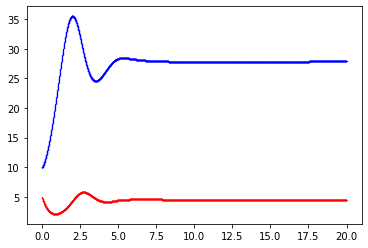

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338131.png
Epoch [04100/50000] Loss:0.036086 Loss_1:0.000437 Loss_2:0.035649 Lr:0.001961 Time:1.299294s
Epoch [04200/50000] Loss:0.036591 Loss_1:0.000591 Loss_2:0.036000 Lr:0.001923 Time:0.796023s
Epoch [04300/50000] Loss:0.033583 Loss_1:0.000729 Loss_2:0.032855 Lr:0.001887 Time:0.791466s
Epoch [04400/50000] Loss:0.029233 Loss_1:0.000041 Loss_2:0.029192 Lr:0.001852 Time:0.791724s
Epoch [04500/50000] Loss:0.028338 Loss_1:0.000200 Loss_2:0.028139 Lr:0.001818 Time:0.791633s
Testing & drawing...
u= [9.993987, 9.998792, 10.003628, 10.008495, 10.013393, 10.018326, 10.023279, 10.028273, 10.033294, 10.038344] ... [27.829409, 27.829405, 27.829405, 27.829405, 27.829405, 27.829403, 27.829403, 27.829403, 27.8294, 27.8294]
v= [4.988567, 4.980091, 4.9716067, 4.9631057, 4.9545927, 4.9460707, 4.9375453, 4.9290075, 4.920464, 4.911921] ... [4.5339766, 4.5339756, 4.5339746, 4.53

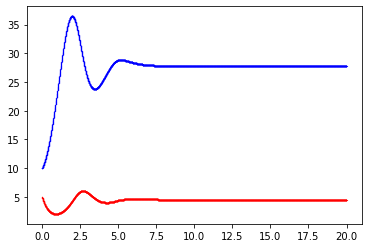

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338136.png
Epoch [04600/50000] Loss:0.028230 Loss_1:0.000254 Loss_2:0.027976 Lr:0.001786 Time:1.306351s
Epoch [04700/50000] Loss:0.040579 Loss_1:0.002796 Loss_2:0.037783 Lr:0.001754 Time:0.791524s
Epoch [04800/50000] Loss:0.031208 Loss_1:0.001389 Loss_2:0.029818 Lr:0.001724 Time:0.793563s
Epoch [04900/50000] Loss:0.037303 Loss_1:0.002690 Loss_2:0.034612 Lr:0.001695 Time:0.791177s
Epoch [05000/50000] Loss:0.022867 Loss_1:0.000017 Loss_2:0.022851 Lr:0.001667 Time:0.791338s
Testing & drawing...
u= [10.012272, 10.017234, 10.02222, 10.027239, 10.0322895, 10.037367, 10.04247, 10.047607, 10.052772, 10.057962] ... [27.821196, 27.821196, 27.821194, 27.821194, 27.821192, 27.821192, 27.821192, 27.821192, 27.82119, 27.82119]
v= [5.0110826, 5.002495, 4.9939013, 4.9852924, 4.9766755, 4.968051, 4.9594254, 4.9507895, 4.942151, 4.9335136] ... [4.5291753, 4.529174, 4.529174, 4.

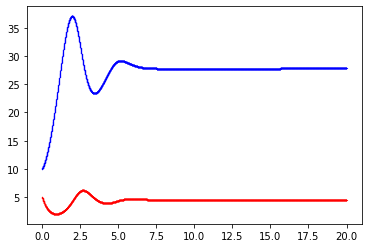

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338140.png
Epoch [05100/50000] Loss:0.022033 Loss_1:0.000003 Loss_2:0.022031 Lr:0.001639 Time:1.381593s
Epoch [05200/50000] Loss:0.021316 Loss_1:0.000029 Loss_2:0.021287 Lr:0.001613 Time:0.791447s
Epoch [05300/50000] Loss:0.041778 Loss_1:0.003839 Loss_2:0.037939 Lr:0.001587 Time:0.791872s
Epoch [05400/50000] Loss:0.055049 Loss_1:0.005837 Loss_2:0.049213 Lr:0.001563 Time:0.812339s
Epoch [05500/50000] Loss:0.019113 Loss_1:0.000067 Loss_2:0.019046 Lr:0.001538 Time:0.791189s
Testing & drawing...
u= [9.998629, 10.003531, 10.008456, 10.013415, 10.018401, 10.0234165, 10.028459, 10.033531, 10.038633, 10.04376] ... [27.825287, 27.825287, 27.825285, 27.825285, 27.825285, 27.825285, 27.825283, 27.825283, 27.825283, 27.825283]
v= [4.995308, 4.9867163, 4.978122, 4.9695144, 4.960901, 4.9522815, 4.943662, 4.9350357, 4.926407, 4.9177823] ... [4.5305285, 4.5305285, 4.530528, 4

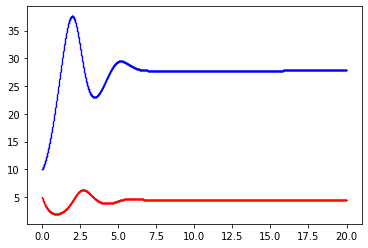

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338145.png
Epoch [05600/50000] Loss:0.018320 Loss_1:0.000002 Loss_2:0.018318 Lr:0.001515 Time:1.284778s
Epoch [05700/50000] Loss:0.017735 Loss_1:0.000005 Loss_2:0.017730 Lr:0.001493 Time:0.792643s
Epoch [05800/50000] Loss:0.017537 Loss_1:0.000020 Loss_2:0.017517 Lr:0.001471 Time:0.792630s
Epoch [05900/50000] Loss:0.052062 Loss_1:0.005404 Loss_2:0.046658 Lr:0.001449 Time:0.790988s
Epoch [06000/50000] Loss:0.015877 Loss_1:0.000009 Loss_2:0.015868 Lr:0.001429 Time:0.791672s
Testing & drawing...
u= [10.003014, 10.007954, 10.012919, 10.017915, 10.022938, 10.027988, 10.033063, 10.038168, 10.043301, 10.048459] ... [27.831442, 27.831442, 27.831442, 27.831438, 27.831438, 27.831438, 27.831438, 27.831438, 27.831438, 27.831438]
v= [5.0009856, 4.9923353, 4.9836826, 4.9750195, 4.9663515, 4.9576807, 4.9490113, 4.9403367, 4.931662, 4.922993] ... [4.529926, 4.5299253, 4.529925

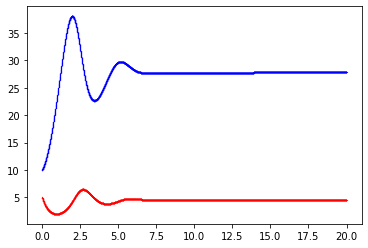

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338149.png
Epoch [06100/50000] Loss:0.017282 Loss_1:0.000203 Loss_2:0.017080 Lr:0.001408 Time:1.269592s
Epoch [06200/50000] Loss:0.015111 Loss_1:0.000006 Loss_2:0.015105 Lr:0.001389 Time:0.813025s
Epoch [06300/50000] Loss:0.022442 Loss_1:0.000717 Loss_2:0.021724 Lr:0.001370 Time:0.791460s
Epoch [06400/50000] Loss:0.013950 Loss_1:0.000010 Loss_2:0.013941 Lr:0.001351 Time:0.791490s
Epoch [06500/50000] Loss:0.013660 Loss_1:0.000033 Loss_2:0.013627 Lr:0.001333 Time:0.798805s
Testing & drawing...
u= [10.0046625, 10.009589, 10.014539, 10.019519, 10.024527, 10.029558, 10.034618, 10.039706, 10.044822, 10.04996] ... [27.839386, 27.839388, 27.839388, 27.839388, 27.839388, 27.839388, 27.839388, 27.839388, 27.839386, 27.839384]
v= [5.002825, 4.9941955, 4.9855638, 4.9769206, 4.968273, 4.959622, 4.9509726, 4.942317, 4.9336596, 4.9250083] ... [4.52912, 4.529119, 4.529119, 4.

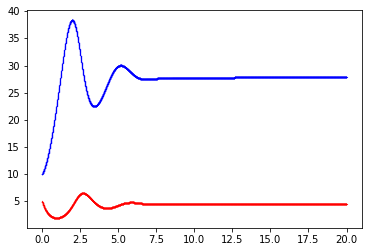

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338154.png
Epoch [06600/50000] Loss:0.012747 Loss_1:0.000001 Loss_2:0.012746 Lr:0.001316 Time:1.348218s
Epoch [06700/50000] Loss:0.012474 Loss_1:0.000018 Loss_2:0.012456 Lr:0.001299 Time:0.792209s
Epoch [06800/50000] Loss:0.027369 Loss_1:0.002531 Loss_2:0.024838 Lr:0.001282 Time:0.795316s
Epoch [06900/50000] Loss:0.011435 Loss_1:0.000013 Loss_2:0.011423 Lr:0.001266 Time:0.791505s
Epoch [07000/50000] Loss:0.012955 Loss_1:0.000011 Loss_2:0.012944 Lr:0.001250 Time:0.794480s
Testing & drawing...
u= [10.024511, 10.029565, 10.034642, 10.039745, 10.044877, 10.050034, 10.055213, 10.060421, 10.065657, 10.070912] ... [27.822632, 27.822628, 27.822628, 27.822628, 27.822628, 27.822624, 27.822624, 27.822624, 27.822624, 27.822624]
v= [5.0317287, 5.0231705, 5.014608, 5.006033, 4.9974527, 4.988867, 4.980283, 4.9716907, 4.963095, 4.954505] ... [4.5265965, 4.5265965, 4.526596, 4

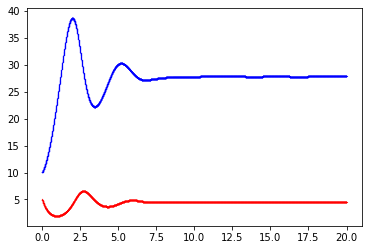

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338158.png
Epoch [07100/50000] Loss:0.010600 Loss_1:0.000003 Loss_2:0.010598 Lr:0.001235 Time:1.305730s
Epoch [07200/50000] Loss:0.011312 Loss_1:0.000128 Loss_2:0.011184 Lr:0.001220 Time:0.793795s
Epoch [07300/50000] Loss:0.009948 Loss_1:0.000003 Loss_2:0.009946 Lr:0.001205 Time:0.791421s
Epoch [07400/50000] Loss:0.010218 Loss_1:0.000037 Loss_2:0.010181 Lr:0.001190 Time:0.791172s
Epoch [07500/50000] Loss:0.021966 Loss_1:0.001700 Loss_2:0.020266 Lr:0.001176 Time:0.791496s
Testing & drawing...
u= [10.055562, 10.060716, 10.065891, 10.071095, 10.076325, 10.081581, 10.08686, 10.092164, 10.097492, 10.102847] ... [27.806894, 27.806894, 27.806894, 27.80689, 27.80689, 27.806887, 27.806887, 27.806883, 27.806879, 27.806879]
v= [5.053914, 5.04519, 5.0364623, 5.0277214, 5.0189734, 5.0102196, 5.001466, 4.992703, 4.9839396, 4.9751787] ... [4.526027, 4.526027, 4.5260267, 4.52

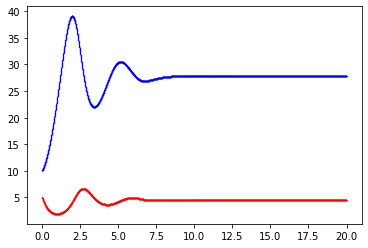

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338163.png
Epoch [07600/50000] Loss:0.009141 Loss_1:0.000001 Loss_2:0.009140 Lr:0.001163 Time:1.354447s
Epoch [07700/50000] Loss:0.010431 Loss_1:0.000258 Loss_2:0.010173 Lr:0.001149 Time:0.791463s
Epoch [07800/50000] Loss:0.009375 Loss_1:0.000092 Loss_2:0.009283 Lr:0.001136 Time:0.791219s
Epoch [07900/50000] Loss:0.008375 Loss_1:0.000005 Loss_2:0.008370 Lr:0.001124 Time:0.818942s
Epoch [08000/50000] Loss:0.010111 Loss_1:0.000215 Loss_2:0.009895 Lr:0.001111 Time:0.791309s
Testing & drawing...
u= [10.021721, 10.026792, 10.031881, 10.037002, 10.042144, 10.047312, 10.052503, 10.057718, 10.062963, 10.068226] ... [27.813864, 27.81386, 27.813856, 27.813856, 27.813856, 27.813856, 27.813852, 27.813852, 27.813848, 27.813848]
v= [5.0200686, 5.011418, 5.0027666, 4.9941044, 4.9854383, 4.9767714, 4.968107, 4.959438, 4.9507685, 4.9421053] ... [4.530986, 4.530986, 4.530986, 4

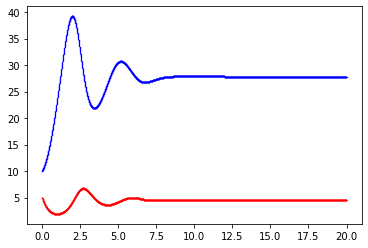

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338167.png
Epoch [08100/50000] Loss:0.007900 Loss_1:0.000041 Loss_2:0.007860 Lr:0.001099 Time:1.286080s
Epoch [08200/50000] Loss:0.007597 Loss_1:0.000011 Loss_2:0.007585 Lr:0.001087 Time:0.792007s
Epoch [08300/50000] Loss:0.023297 Loss_1:0.001652 Loss_2:0.021646 Lr:0.001075 Time:0.795254s
Epoch [08400/50000] Loss:0.007008 Loss_1:0.000003 Loss_2:0.007005 Lr:0.001064 Time:0.792062s
Epoch [08500/50000] Loss:0.006946 Loss_1:0.000003 Loss_2:0.006943 Lr:0.001053 Time:0.791025s
Testing & drawing...
u= [10.005764, 10.0107765, 10.015811, 10.020874, 10.025959, 10.031065, 10.0362, 10.041356, 10.046537, 10.051741] ... [27.795935, 27.79593, 27.79593, 27.79593, 27.795927, 27.795927, 27.795927, 27.795927, 27.795923, 27.79592]
v= [5.0056353, 4.996911, 4.98819, 4.9794617, 4.970733, 4.9620047, 4.9532824, 4.944558, 4.935837, 4.9271255] ... [4.532319, 4.5323186, 4.532318, 4.53231

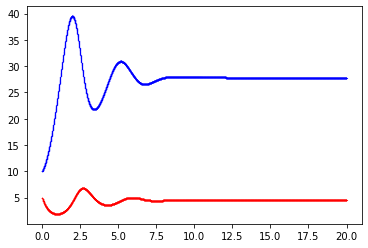

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338172.png
Epoch [08600/50000] Loss:0.044505 Loss_1:0.004952 Loss_2:0.039554 Lr:0.001042 Time:1.296196s
Epoch [08700/50000] Loss:0.006461 Loss_1:0.000000 Loss_2:0.006461 Lr:0.001031 Time:0.810170s
Epoch [08800/50000] Loss:0.011996 Loss_1:0.000802 Loss_2:0.011194 Lr:0.001020 Time:0.792048s
Epoch [08900/50000] Loss:0.006095 Loss_1:0.000001 Loss_2:0.006094 Lr:0.001010 Time:0.791235s
Epoch [09000/50000] Loss:0.008021 Loss_1:0.000315 Loss_2:0.007706 Lr:0.001000 Time:0.791324s
Testing & drawing...
u= [9.988234, 9.99316, 9.998111, 10.003086, 10.008085, 10.013105, 10.018147, 10.023214, 10.02831, 10.033423] ... [27.800112, 27.80011, 27.800108, 27.800108, 27.800106, 27.800104, 27.800104, 27.800104, 27.800102, 27.800102]
v= [4.9938974, 4.9851956, 4.9765015, 4.967805, 4.9591107, 4.9504204, 4.9417405, 4.93306, 4.924388, 4.9157267] ... [4.529417, 4.5294166, 4.529415, 4.5294

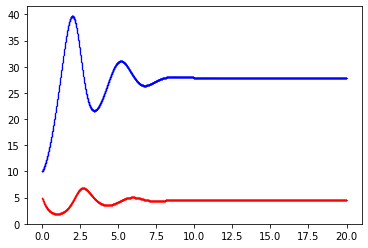

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338176.png
Epoch [09100/50000] Loss:0.005753 Loss_1:0.000001 Loss_2:0.005752 Lr:0.000990 Time:1.381522s
Epoch [09200/50000] Loss:0.005796 Loss_1:0.000000 Loss_2:0.005796 Lr:0.000980 Time:0.791833s
Epoch [09300/50000] Loss:0.005487 Loss_1:0.000002 Loss_2:0.005485 Lr:0.000971 Time:0.793758s
Epoch [09400/50000] Loss:0.005622 Loss_1:0.000029 Loss_2:0.005592 Lr:0.000962 Time:0.791400s
Epoch [09500/50000] Loss:0.005208 Loss_1:0.000000 Loss_2:0.005208 Lr:0.000952 Time:0.792327s
Testing & drawing...
u= [10.002169, 10.007201, 10.012249, 10.0173235, 10.022421, 10.02754, 10.03268, 10.037846, 10.043033, 10.04824] ... [27.825516, 27.825516, 27.825516, 27.825512, 27.825512, 27.825508, 27.825508, 27.825508, 27.825508, 27.825508]
v= [5.001641, 4.9928274, 4.98402, 4.9752107, 4.9664063, 4.9576054, 4.948817, 4.940029, 4.9312496, 4.922483] ... [4.5278273, 4.527827, 4.527825, 4.52

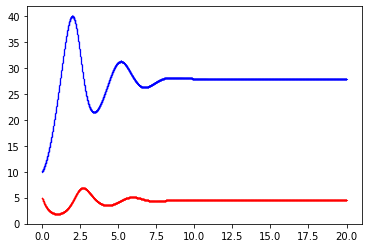

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338181.png
Epoch [09600/50000] Loss:0.005265 Loss_1:0.000010 Loss_2:0.005255 Lr:0.000943 Time:1.284698s
Epoch [09700/50000] Loss:0.005010 Loss_1:0.000001 Loss_2:0.005009 Lr:0.000935 Time:0.791455s
Epoch [09800/50000] Loss:0.005214 Loss_1:0.000031 Loss_2:0.005183 Lr:0.000926 Time:0.791359s
Epoch [09900/50000] Loss:0.004859 Loss_1:0.000001 Loss_2:0.004858 Lr:0.000917 Time:0.797155s
Epoch [10000/50000] Loss:0.006663 Loss_1:0.000206 Loss_2:0.006457 Lr:0.000909 Time:0.791193s
Testing & drawing...
u= [10.006164, 10.0112505, 10.016356, 10.021487, 10.026639, 10.031815, 10.037009, 10.042228, 10.047472, 10.052736] ... [27.837193, 27.83719, 27.83719, 27.83719, 27.83719, 27.83719, 27.83719, 27.83719, 27.83719, 27.83719]
v= [5.0083456, 4.999571, 4.990805, 4.9820356, 4.973271, 4.9645104, 4.9557614, 4.947012, 4.9382706, 4.9295416] ... [4.5300784, 4.5300775, 4.530077, 4.53007

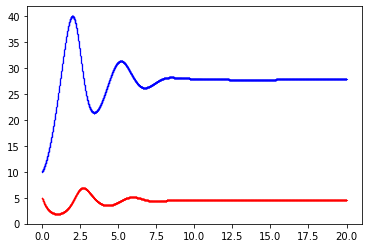

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338185.png
Epoch [10100/50000] Loss:0.004666 Loss_1:0.000001 Loss_2:0.004665 Lr:0.000901 Time:1.301622s
Epoch [10200/50000] Loss:0.006099 Loss_1:0.000151 Loss_2:0.005947 Lr:0.000893 Time:0.796868s
Epoch [10300/50000] Loss:0.004536 Loss_1:0.000001 Loss_2:0.004535 Lr:0.000885 Time:0.791447s
Epoch [10400/50000] Loss:0.008646 Loss_1:0.000167 Loss_2:0.008479 Lr:0.000877 Time:0.808042s
Epoch [10500/50000] Loss:0.004386 Loss_1:0.000001 Loss_2:0.004385 Lr:0.000870 Time:0.791037s
Testing & drawing...
u= [10.000974, 10.006009, 10.0110655, 10.016142, 10.021243, 10.026366, 10.031507, 10.036676, 10.041865, 10.047074] ... [27.843235, 27.843235, 27.843235, 27.843235, 27.843235, 27.843235, 27.843235, 27.843235, 27.843235, 27.843235]
v= [5.0003304, 4.9914975, 4.9826727, 4.9738474, 4.965028, 4.9562154, 4.947415, 4.9386163, 4.929828, 4.9210544] ... [4.528322, 4.5283213, 4.528320

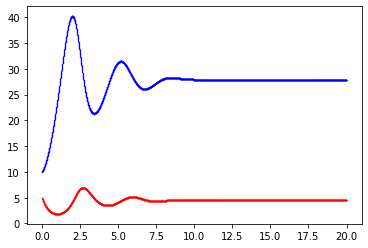

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338190.png
Epoch [10600/50000] Loss:0.004834 Loss_1:0.000036 Loss_2:0.004798 Lr:0.000862 Time:1.348404s
Epoch [10700/50000] Loss:0.004251 Loss_1:0.000001 Loss_2:0.004250 Lr:0.000855 Time:0.791402s
Epoch [10800/50000] Loss:0.004880 Loss_1:0.000050 Loss_2:0.004830 Lr:0.000847 Time:0.790658s
Epoch [10900/50000] Loss:0.004159 Loss_1:0.000001 Loss_2:0.004159 Lr:0.000840 Time:0.791296s
Epoch [11000/50000] Loss:0.040996 Loss_1:0.003495 Loss_2:0.037501 Lr:0.000833 Time:0.792121s
Testing & drawing...
u= [10.079293, 10.084325, 10.089376, 10.094455, 10.099557, 10.104682, 10.109825, 10.114997, 10.120191, 10.125405] ... [27.819807, 27.819807, 27.819805, 27.819805, 27.819805, 27.819805, 27.819805, 27.819805, 27.819807, 27.819807]
v= [5.0741158, 5.0654874, 5.0568633, 5.0482354, 5.039608, 5.030983, 5.022367, 5.013749, 5.0051365, 4.9965343] ... [4.5206614, 4.5206614, 4.5206614

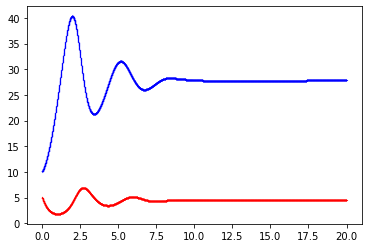

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338194.png
Epoch [11100/50000] Loss:0.004074 Loss_1:0.000000 Loss_2:0.004074 Lr:0.000826 Time:1.297274s
Epoch [11200/50000] Loss:0.003941 Loss_1:0.000001 Loss_2:0.003939 Lr:0.000820 Time:0.792469s
Epoch [11300/50000] Loss:0.003992 Loss_1:0.000003 Loss_2:0.003989 Lr:0.000813 Time:0.798554s
Epoch [11400/50000] Loss:0.003849 Loss_1:0.000000 Loss_2:0.003849 Lr:0.000806 Time:0.791591s
Epoch [11500/50000] Loss:0.003933 Loss_1:0.000004 Loss_2:0.003930 Lr:0.000800 Time:0.791029s
Testing & drawing...
u= [10.002539, 10.007578, 10.012635, 10.01772, 10.022822, 10.027949, 10.033096, 10.038268, 10.043461, 10.048675] ... [27.844816, 27.844816, 27.844816, 27.844816, 27.844816, 27.844816, 27.844816, 27.844816, 27.844816, 27.844816]
v= [5.0022774, 4.993448, 4.984627, 4.975806, 4.966992, 4.958185, 4.9493904, 4.9405985, 4.9318166, 4.92305] ... [4.528715, 4.528715, 4.528715, 4.528

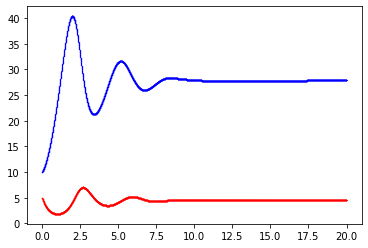

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338199.png
Epoch [11600/50000] Loss:0.003756 Loss_1:0.000001 Loss_2:0.003755 Lr:0.000794 Time:1.304356s
Epoch [11700/50000] Loss:0.003896 Loss_1:0.000019 Loss_2:0.003877 Lr:0.000787 Time:0.791933s
Epoch [11800/50000] Loss:0.003662 Loss_1:0.000001 Loss_2:0.003662 Lr:0.000781 Time:0.791226s
Epoch [11900/50000] Loss:0.003750 Loss_1:0.000000 Loss_2:0.003750 Lr:0.000775 Time:0.791554s
Epoch [12000/50000] Loss:0.003599 Loss_1:0.000001 Loss_2:0.003598 Lr:0.000769 Time:0.808076s
Testing & drawing...
u= [10.000872, 10.005912, 10.01097, 10.016053, 10.02116, 10.026289, 10.031436, 10.036606, 10.041801, 10.047015] ... [27.843222, 27.843222, 27.843222, 27.843222, 27.843224, 27.843224, 27.843224, 27.843224, 27.843224, 27.843224]
v= [5.000354, 4.9914985, 4.9826536, 4.9738097, 4.964973, 4.956144, 4.9473286, 4.938517, 4.929716, 4.9209313] ... [4.52993, 4.52993, 4.52993, 4.52993

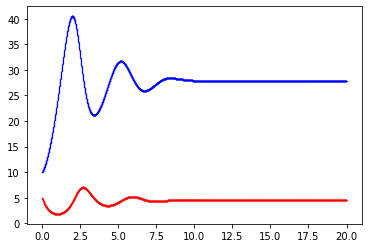

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338203.png
Epoch [12100/50000] Loss:0.023456 Loss_1:0.002666 Loss_2:0.020789 Lr:0.000763 Time:1.362645s
Epoch [12200/50000] Loss:0.003526 Loss_1:0.000000 Loss_2:0.003526 Lr:0.000758 Time:0.790669s
Epoch [12300/50000] Loss:0.003594 Loss_1:0.000012 Loss_2:0.003582 Lr:0.000752 Time:0.790933s
Epoch [12400/50000] Loss:0.003474 Loss_1:0.000001 Loss_2:0.003474 Lr:0.000746 Time:0.791269s
Epoch [12500/50000] Loss:0.003357 Loss_1:0.000000 Loss_2:0.003356 Lr:0.000741 Time:0.801680s
Testing & drawing...
u= [10.00082, 10.005861, 10.010924, 10.016009, 10.021118, 10.026248, 10.031398, 10.0365715, 10.041766, 10.046982] ... [27.835299, 27.835299, 27.835299, 27.835299, 27.835299, 27.835295, 27.835295, 27.835295, 27.835295, 27.835295]
v= [5.0003223, 4.9914575, 4.982603, 4.973751, 4.964906, 4.95607, 4.9472485, 4.9384313, 4.929624, 4.920835] ... [4.5318985, 4.531899, 4.5318995, 4.

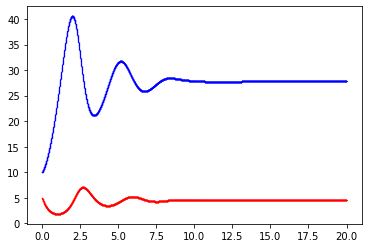

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338208.png
Epoch [12600/50000] Loss:0.003570 Loss_1:0.000036 Loss_2:0.003535 Lr:0.000735 Time:1.294718s
Epoch [12700/50000] Loss:0.003271 Loss_1:0.000000 Loss_2:0.003271 Lr:0.000730 Time:0.791171s
Epoch [12800/50000] Loss:0.003402 Loss_1:0.000018 Loss_2:0.003383 Lr:0.000725 Time:0.814262s
Epoch [12900/50000] Loss:0.003204 Loss_1:0.000000 Loss_2:0.003203 Lr:0.000719 Time:0.791255s
Epoch [13000/50000] Loss:0.003736 Loss_1:0.000075 Loss_2:0.003662 Lr:0.000714 Time:0.791352s
Testing & drawing...
u= [10.003614, 10.00865, 10.013705, 10.0187845, 10.023888, 10.029011, 10.034155, 10.039322, 10.044514, 10.049725] ... [27.826214, 27.826214, 27.826212, 27.82621, 27.826208, 27.826208, 27.826206, 27.826206, 27.826204, 27.826204]
v= [5.0073886, 4.9985504, 4.9897246, 4.9808984, 4.972081, 4.9632716, 4.9544754, 4.945684, 4.936903, 4.9281387] ... [4.5330725, 4.533073, 4.533073, 

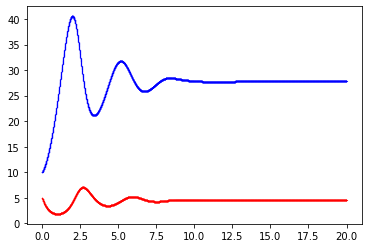

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338212.png
Epoch [13100/50000] Loss:0.003121 Loss_1:0.000000 Loss_2:0.003121 Lr:0.000709 Time:1.329275s
Epoch [13200/50000] Loss:0.003384 Loss_1:0.000021 Loss_2:0.003362 Lr:0.000704 Time:0.791472s
Epoch [13300/50000] Loss:0.003056 Loss_1:0.000000 Loss_2:0.003055 Lr:0.000699 Time:0.791667s
Epoch [13400/50000] Loss:0.003128 Loss_1:0.000013 Loss_2:0.003116 Lr:0.000694 Time:0.793029s
Epoch [13500/50000] Loss:0.002977 Loss_1:0.000000 Loss_2:0.002977 Lr:0.000690 Time:0.791219s
Testing & drawing...
u= [10.000913, 10.005957, 10.011019, 10.016107, 10.021217, 10.026349, 10.031498, 10.036673, 10.041869, 10.047086] ... [27.810606, 27.810602, 27.810598, 27.810598, 27.810595, 27.81059, 27.81059, 27.810587, 27.810587, 27.810587]
v= [5.000599, 4.9917207, 4.9828544, 4.973991, 4.965136, 4.9562893, 4.9474587, 4.9386344, 4.92982, 4.9210234] ... [4.534215, 4.534216, 4.5342164, 4.5

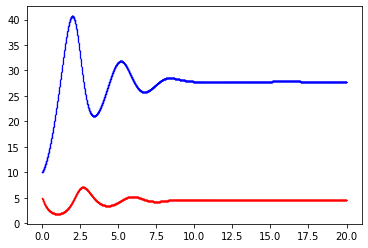

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338217.png
Epoch [13600/50000] Loss:0.003048 Loss_1:0.000012 Loss_2:0.003036 Lr:0.000685 Time:1.315826s
Epoch [13700/50000] Loss:0.002900 Loss_1:0.000000 Loss_2:0.002900 Lr:0.000680 Time:0.793377s
Epoch [13800/50000] Loss:0.002957 Loss_1:0.000005 Loss_2:0.002952 Lr:0.000676 Time:0.791439s
Epoch [13900/50000] Loss:0.002840 Loss_1:0.000000 Loss_2:0.002840 Lr:0.000671 Time:0.791392s
Epoch [14000/50000] Loss:0.002919 Loss_1:0.000015 Loss_2:0.002905 Lr:0.000667 Time:0.791694s
Testing & drawing...
u= [9.999624, 10.004654, 10.009701, 10.014774, 10.019869, 10.024988, 10.030123, 10.035286, 10.040468, 10.045673] ... [27.804277, 27.804272, 27.804266, 27.804264, 27.804258, 27.804258, 27.804255, 27.80425, 27.804247, 27.804245]
v= [5.00021, 4.9913507, 4.9825025, 4.973657, 4.9648204, 4.9559927, 4.9471807, 4.9383736, 4.9295783, 4.9208] ... [4.5343356, 4.534336, 4.534336, 4.53

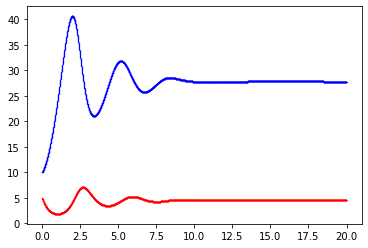

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338221.png
Epoch [14100/50000] Loss:0.002781 Loss_1:0.000000 Loss_2:0.002781 Lr:0.000662 Time:1.282402s
Epoch [14200/50000] Loss:0.002922 Loss_1:0.000017 Loss_2:0.002905 Lr:0.000658 Time:0.791345s
Epoch [14300/50000] Loss:0.002729 Loss_1:0.000000 Loss_2:0.002728 Lr:0.000654 Time:0.790993s
Epoch [14400/50000] Loss:0.003049 Loss_1:0.000025 Loss_2:0.003024 Lr:0.000649 Time:0.791795s
Epoch [14500/50000] Loss:0.002669 Loss_1:0.000000 Loss_2:0.002669 Lr:0.000645 Time:0.813387s
Testing & drawing...
u= [10.000535, 10.005577, 10.010637, 10.015725, 10.020832, 10.025963, 10.03111, 10.036284, 10.041481, 10.046695] ... [27.798323, 27.798315, 27.798311, 27.798307, 27.798304, 27.7983, 27.798296, 27.798292, 27.798288, 27.798285]
v= [5.0001626, 4.9912763, 4.9824014, 4.973531, 4.9646688, 4.955816, 4.94698, 4.93815, 4.9293327, 4.9205327] ... [4.534344, 4.534344, 4.534344, 4.5343

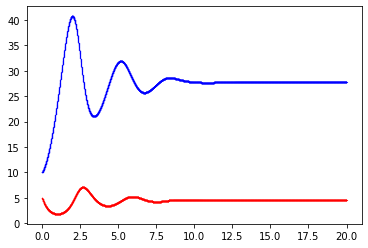

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338225.png
Epoch [14600/50000] Loss:0.002743 Loss_1:0.000015 Loss_2:0.002728 Lr:0.000641 Time:1.364963s
Epoch [14700/50000] Loss:0.002612 Loss_1:0.000000 Loss_2:0.002612 Lr:0.000637 Time:0.790588s
Epoch [14800/50000] Loss:0.002648 Loss_1:0.000003 Loss_2:0.002645 Lr:0.000633 Time:0.791389s
Epoch [14900/50000] Loss:0.002571 Loss_1:0.000001 Loss_2:0.002571 Lr:0.000629 Time:0.791233s
Epoch [15000/50000] Loss:0.002567 Loss_1:0.000001 Loss_2:0.002566 Lr:0.000625 Time:0.791480s
Testing & drawing...
u= [10.000929, 10.005969, 10.011028, 10.01611, 10.021215, 10.026341, 10.031488, 10.036659, 10.041854, 10.047067] ... [27.804216, 27.804209, 27.804209, 27.804209, 27.804201, 27.804201, 27.804197, 27.804197, 27.804193, 27.80419]
v= [5.0007715, 4.991886, 4.9830146, 4.974146, 4.965287, 4.9564376, 4.947605, 4.9387784, 4.9299636, 4.9211664] ... [4.53352, 4.5335197, 4.5335197, 4.

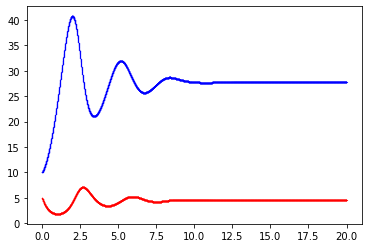

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338230.png
Epoch [15100/50000] Loss:0.002505 Loss_1:0.000000 Loss_2:0.002505 Lr:0.000621 Time:1.284602s
Epoch [15200/50000] Loss:0.002666 Loss_1:0.000016 Loss_2:0.002650 Lr:0.000617 Time:0.791281s
Epoch [15300/50000] Loss:0.002466 Loss_1:0.000000 Loss_2:0.002466 Lr:0.000613 Time:0.808644s
Epoch [15400/50000] Loss:0.030850 Loss_1:0.003099 Loss_2:0.027751 Lr:0.000610 Time:0.790990s
Epoch [15500/50000] Loss:0.002432 Loss_1:0.000001 Loss_2:0.002431 Lr:0.000606 Time:0.790955s
Testing & drawing...
u= [10.000431, 10.00547, 10.010528, 10.015612, 10.020714, 10.025843, 10.030988, 10.0361595, 10.041352, 10.046565] ... [27.806147, 27.806147, 27.80614, 27.80614, 27.806137, 27.806137, 27.806133, 27.806131, 27.80613, 27.80613]
v= [5.0000143, 4.991122, 4.9822435, 4.973367, 4.9645014, 4.955646, 4.9468074, 4.937975, 4.9291563, 4.9203544] ... [4.5322328, 4.5322323, 4.532231, 4.5

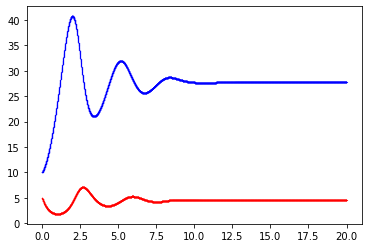

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338234.png
Epoch [15600/50000] Loss:0.002375 Loss_1:0.000000 Loss_2:0.002374 Lr:0.000602 Time:1.292668s
Epoch [15700/50000] Loss:0.012106 Loss_1:0.000584 Loss_2:0.011521 Lr:0.000599 Time:0.791098s
Epoch [15800/50000] Loss:0.002385 Loss_1:0.000000 Loss_2:0.002385 Lr:0.000595 Time:0.798671s
Epoch [15900/50000] Loss:0.002330 Loss_1:0.000000 Loss_2:0.002329 Lr:0.000592 Time:0.793260s
Epoch [16000/50000] Loss:0.002281 Loss_1:0.000000 Loss_2:0.002281 Lr:0.000588 Time:0.791768s
Testing & drawing...
u= [10.000601, 10.005643, 10.010702, 10.015785, 10.020893, 10.02602, 10.031168, 10.036341, 10.041534, 10.046749] ... [27.805143, 27.805138, 27.805136, 27.805136, 27.805134, 27.805132, 27.805132, 27.80513, 27.805126, 27.805126]
v= [5.000381, 4.991473, 4.982581, 4.973693, 4.9648156, 4.95595, 4.947103, 4.9382615, 4.9294343, 4.9206257] ... [4.530795, 4.5307927, 4.530791, 4.530

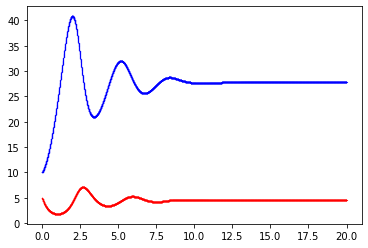

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338239.png
Epoch [16100/50000] Loss:0.002843 Loss_1:0.000074 Loss_2:0.002769 Lr:0.000585 Time:1.367635s
Epoch [16200/50000] Loss:0.002244 Loss_1:0.000000 Loss_2:0.002243 Lr:0.000581 Time:0.792175s
Epoch [16300/50000] Loss:0.059917 Loss_1:0.004985 Loss_2:0.054931 Lr:0.000578 Time:0.790752s
Epoch [16400/50000] Loss:0.002206 Loss_1:0.000001 Loss_2:0.002205 Lr:0.000575 Time:0.791279s
Epoch [16500/50000] Loss:0.002159 Loss_1:0.000000 Loss_2:0.002159 Lr:0.000571 Time:0.793439s
Testing & drawing...
u= [10.000567, 10.005609, 10.010667, 10.015755, 10.020861, 10.0259905, 10.03114, 10.036313, 10.04151, 10.046724] ... [27.803839, 27.803837, 27.803837, 27.803833, 27.803831, 27.803831, 27.80383, 27.803827, 27.803825, 27.803825]
v= [5.000277, 4.991369, 4.9824724, 4.973583, 4.964704, 4.9558363, 4.946987, 4.938144, 4.9293165, 4.920507] ... [4.5299535, 4.529951, 4.5299487, 4.52

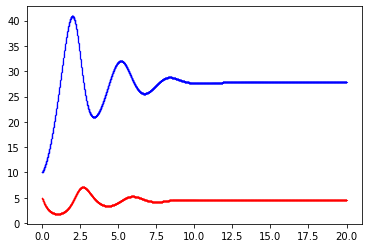

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338243.png
Epoch [16600/50000] Loss:0.002194 Loss_1:0.000001 Loss_2:0.002193 Lr:0.000568 Time:1.289695s
Epoch [16700/50000] Loss:0.002129 Loss_1:0.000000 Loss_2:0.002129 Lr:0.000565 Time:0.791596s
Epoch [16800/50000] Loss:0.010776 Loss_1:0.001128 Loss_2:0.009648 Lr:0.000562 Time:0.791586s
Epoch [16900/50000] Loss:0.002091 Loss_1:0.000000 Loss_2:0.002091 Lr:0.000559 Time:0.793670s
Epoch [17000/50000] Loss:0.004314 Loss_1:0.000155 Loss_2:0.004159 Lr:0.000556 Time:0.794012s
Testing & drawing...
u= [9.987809, 9.992807, 9.997826, 10.002867, 10.007931, 10.013016, 10.018122, 10.0232525, 10.028404, 10.033575] ... [27.81813, 27.818129, 27.818127, 27.818125, 27.818125, 27.818123, 27.818123, 27.818123, 27.818115, 27.818111]
v= [4.982896, 4.974013, 4.965146, 4.9562883, 4.9474416, 4.9386086, 4.9297943, 4.9209886, 4.912199, 4.903429] ... [4.535564, 4.535562, 4.53556, 4.5355

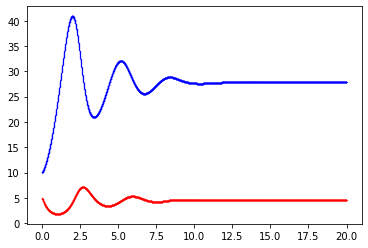

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338248.png
Epoch [17100/50000] Loss:0.002050 Loss_1:0.000000 Loss_2:0.002050 Lr:0.000552 Time:1.308952s
Epoch [17200/50000] Loss:0.002481 Loss_1:0.000032 Loss_2:0.002449 Lr:0.000549 Time:0.791676s
Epoch [17300/50000] Loss:0.002013 Loss_1:0.000001 Loss_2:0.002013 Lr:0.000546 Time:0.791695s
Epoch [17400/50000] Loss:0.001970 Loss_1:0.000000 Loss_2:0.001970 Lr:0.000543 Time:0.791870s
Epoch [17500/50000] Loss:0.002054 Loss_1:0.000016 Loss_2:0.002038 Lr:0.000541 Time:0.793153s
Testing & drawing...
u= [9.998797, 10.003828, 10.008875, 10.013947, 10.019044, 10.02416, 10.029297, 10.034461, 10.039644, 10.044849] ... [27.803625, 27.803625, 27.803625, 27.803621, 27.803621, 27.803616, 27.803616, 27.803612, 27.803612, 27.803612]
v= [4.9984803, 4.9895935, 4.980723, 4.971857, 4.963003, 4.954161, 4.9453363, 4.936519, 4.927716, 4.918932] ... [4.529092, 4.52909, 4.529088, 4.52908

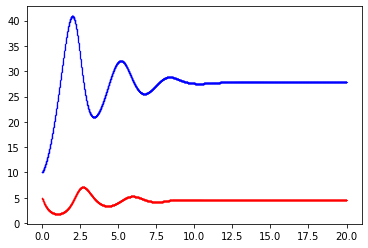

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338252.png
Epoch [17600/50000] Loss:0.001929 Loss_1:0.000000 Loss_2:0.001929 Lr:0.000538 Time:1.366944s
Epoch [17700/50000] Loss:0.002240 Loss_1:0.000007 Loss_2:0.002233 Lr:0.000535 Time:0.791166s
Epoch [17800/50000] Loss:0.001888 Loss_1:0.000000 Loss_2:0.001888 Lr:0.000532 Time:0.811748s
Epoch [17900/50000] Loss:0.003767 Loss_1:0.000232 Loss_2:0.003534 Lr:0.000529 Time:0.791549s
Epoch [18000/50000] Loss:0.001847 Loss_1:0.000000 Loss_2:0.001847 Lr:0.000526 Time:0.791000s
Testing & drawing...
u= [10.000404, 10.005445, 10.010501, 10.015585, 10.02069, 10.025819, 10.030964, 10.036135, 10.041328, 10.046542] ... [27.804647, 27.804646, 27.804646, 27.804644, 27.804644, 27.804642, 27.804642, 27.80464, 27.80464, 27.804638]
v= [5.000176, 4.9912615, 4.9823623, 4.9734683, 4.9645844, 4.955714, 4.946862, 4.938017, 4.9291863, 4.920375] ... [4.5299344, 4.529933, 4.5299306, 4.5

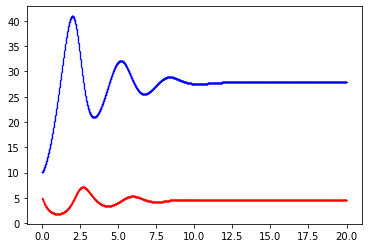

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338257.png
Epoch [18100/50000] Loss:0.012102 Loss_1:0.001387 Loss_2:0.010716 Lr:0.000524 Time:1.286849s
Epoch [18200/50000] Loss:0.001809 Loss_1:0.000000 Loss_2:0.001809 Lr:0.000521 Time:0.791593s
Epoch [18300/50000] Loss:0.001887 Loss_1:0.000004 Loss_2:0.001883 Lr:0.000518 Time:0.791125s
Epoch [18400/50000] Loss:0.001775 Loss_1:0.000000 Loss_2:0.001775 Lr:0.000515 Time:0.791377s
Epoch [18500/50000] Loss:0.001735 Loss_1:0.000000 Loss_2:0.001734 Lr:0.000513 Time:0.791698s
Testing & drawing...
u= [10.000689, 10.00573, 10.01079, 10.015875, 10.020981, 10.026108, 10.031258, 10.03643, 10.041624, 10.046839] ... [27.804155, 27.804155, 27.804153, 27.804152, 27.804152, 27.804148, 27.804148, 27.804146, 27.804146, 27.804146]
v= [5.00057, 4.99165, 4.9827466, 4.9738483, 4.964961, 4.9560876, 4.947231, 4.938383, 4.9295497, 4.920736] ... [4.529843, 4.52984, 4.5298386, 4.529836

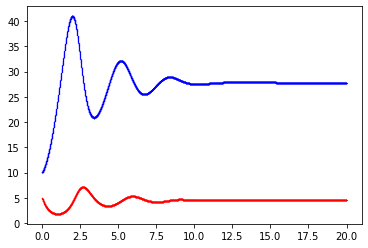

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338261.png
Epoch [18600/50000] Loss:0.001757 Loss_1:0.000002 Loss_2:0.001755 Lr:0.000510 Time:1.361886s
Epoch [18700/50000] Loss:0.001693 Loss_1:0.000001 Loss_2:0.001692 Lr:0.000508 Time:0.796423s
Epoch [18800/50000] Loss:0.001694 Loss_1:0.000001 Loss_2:0.001692 Lr:0.000505 Time:0.792920s
Epoch [18900/50000] Loss:0.001653 Loss_1:0.000000 Loss_2:0.001653 Lr:0.000503 Time:0.791248s
Epoch [19000/50000] Loss:0.001654 Loss_1:0.000000 Loss_2:0.001654 Lr:0.000500 Time:0.791661s
Testing & drawing...
u= [9.999051, 10.004082, 10.009133, 10.01421, 10.019308, 10.024427, 10.029567, 10.034734, 10.039918, 10.045125] ... [27.806185, 27.806183, 27.806181, 27.80618, 27.80618, 27.80618, 27.80618, 27.806177, 27.806177, 27.806177]
v= [4.999043, 4.9901314, 4.981235, 4.972345, 4.9634666, 4.954601, 4.9457526, 4.9369125, 4.9280887, 4.9192843] ... [4.530382, 4.5303802, 4.530379, 4.5303

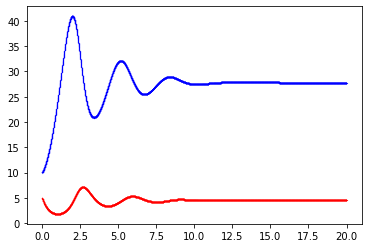

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338266.png
Epoch [19100/50000] Loss:0.001618 Loss_1:0.000001 Loss_2:0.001617 Lr:0.000498 Time:1.340961s
Epoch [19200/50000] Loss:0.001615 Loss_1:0.000002 Loss_2:0.001613 Lr:0.000495 Time:0.792103s
Epoch [19300/50000] Loss:0.001573 Loss_1:0.000000 Loss_2:0.001573 Lr:0.000493 Time:0.792907s
Epoch [19400/50000] Loss:0.001567 Loss_1:0.000000 Loss_2:0.001567 Lr:0.000490 Time:0.796223s
Epoch [19500/50000] Loss:0.001532 Loss_1:0.000000 Loss_2:0.001532 Lr:0.000488 Time:0.814615s
Testing & drawing...
u= [10.0005455, 10.005586, 10.010646, 10.015729, 10.020837, 10.025964, 10.031111, 10.036284, 10.041478, 10.046694] ... [27.804714, 27.804712, 27.804712, 27.80471, 27.804708, 27.804708, 27.804707, 27.804707, 27.804707, 27.804707]
v= [5.0004883, 4.9915633, 4.9826555, 4.973754, 4.9648647, 4.955986, 4.947128, 4.938277, 4.9294415, 4.920626] ... [4.529927, 4.5299253, 4.5299244, 

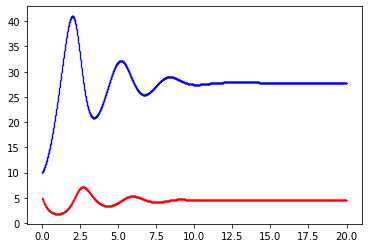

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338271.png
Epoch [19600/50000] Loss:0.001542 Loss_1:0.000002 Loss_2:0.001539 Lr:0.000485 Time:1.301114s
Epoch [19700/50000] Loss:0.001499 Loss_1:0.000000 Loss_2:0.001499 Lr:0.000483 Time:0.791193s
Epoch [19800/50000] Loss:0.002309 Loss_1:0.000018 Loss_2:0.002292 Lr:0.000481 Time:0.790829s
Epoch [19900/50000] Loss:0.001462 Loss_1:0.000000 Loss_2:0.001462 Lr:0.000478 Time:0.791409s
Epoch [20000/50000] Loss:0.001511 Loss_1:0.000001 Loss_2:0.001510 Lr:0.000476 Time:0.791324s
Testing & drawing...
u= [9.996802, 10.001829, 10.006876, 10.011947, 10.017041, 10.022158, 10.02729, 10.03245, 10.037635, 10.042835] ... [27.806139, 27.806137, 27.806137, 27.806135, 27.806135, 27.806135, 27.806135, 27.806133, 27.806133, 27.806131]
v= [4.9963875, 4.9874945, 4.9786177, 4.969747, 4.9608893, 4.952044, 4.9432178, 4.9344, 4.925597, 4.9168143] ... [4.5301776, 4.530177, 4.530175, 4.530

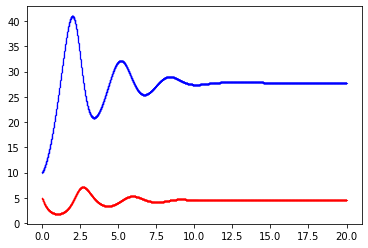

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338275.png
Epoch [20100/50000] Loss:0.001424 Loss_1:0.000000 Loss_2:0.001424 Lr:0.000474 Time:1.372161s
Epoch [20200/50000] Loss:0.001622 Loss_1:0.000013 Loss_2:0.001609 Lr:0.000472 Time:0.792336s
Epoch [20300/50000] Loss:0.001387 Loss_1:0.000000 Loss_2:0.001387 Lr:0.000469 Time:0.810061s
Epoch [20400/50000] Loss:0.001614 Loss_1:0.000011 Loss_2:0.001603 Lr:0.000467 Time:0.792803s
Epoch [20500/50000] Loss:0.001357 Loss_1:0.000000 Loss_2:0.001357 Lr:0.000465 Time:0.791077s
Testing & drawing...
u= [10.000464, 10.005504, 10.01056, 10.015642, 10.020746, 10.025874, 10.03102, 10.036189, 10.041384, 10.046597] ... [27.806122, 27.80612, 27.80612, 27.80612, 27.806118, 27.806118, 27.806118, 27.806118, 27.806118, 27.806118]
v= [5.000222, 4.9912953, 4.9823856, 4.9734807, 4.9645886, 4.95571, 4.94685, 4.937999, 4.929163, 4.9203467] ... [4.5302286, 4.530227, 4.5302267, 4.53022

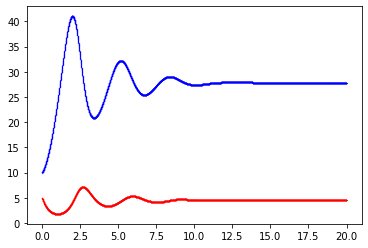

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338280.png
Epoch [20600/50000] Loss:0.010779 Loss_1:0.000935 Loss_2:0.009844 Lr:0.000463 Time:1.297710s
Epoch [20700/50000] Loss:0.001322 Loss_1:0.000000 Loss_2:0.001322 Lr:0.000461 Time:0.791432s
Epoch [20800/50000] Loss:0.008513 Loss_1:0.000863 Loss_2:0.007650 Lr:0.000459 Time:0.790510s
Epoch [20900/50000] Loss:0.001290 Loss_1:0.000000 Loss_2:0.001289 Lr:0.000457 Time:0.791070s
Epoch [21000/50000] Loss:0.003154 Loss_1:0.000071 Loss_2:0.003083 Lr:0.000455 Time:0.792482s
Testing & drawing...
u= [10.009042, 10.0141115, 10.019201, 10.024315, 10.029452, 10.034611, 10.039791, 10.044995, 10.0502205, 10.055466] ... [27.787853, 27.787853, 27.787853, 27.787853, 27.787851, 27.787851, 27.787848, 27.787848, 27.787846, 27.787846]
v= [5.0139403, 5.0049877, 4.996049, 4.987116, 4.9781966, 4.9692883, 4.9603977, 4.951517, 4.9426494, 4.933802] ... [4.5238843, 4.5238833, 4.52388

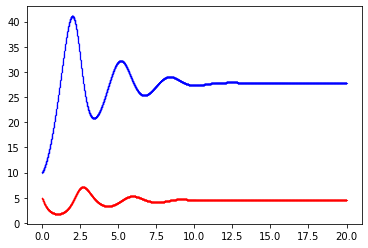

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338284.png
Epoch [21100/50000] Loss:0.001268 Loss_1:0.000000 Loss_2:0.001268 Lr:0.000452 Time:1.312329s
Epoch [21200/50000] Loss:0.001239 Loss_1:0.000000 Loss_2:0.001239 Lr:0.000450 Time:0.791729s
Epoch [21300/50000] Loss:0.002962 Loss_1:0.000232 Loss_2:0.002730 Lr:0.000448 Time:0.790740s
Epoch [21400/50000] Loss:0.001211 Loss_1:0.000000 Loss_2:0.001211 Lr:0.000446 Time:0.791179s
Epoch [21500/50000] Loss:0.004618 Loss_1:0.000482 Loss_2:0.004137 Lr:0.000444 Time:0.800050s
Testing & drawing...
u= [9.996002, 10.000983, 10.005986, 10.011013, 10.016061, 10.0211315, 10.026223, 10.031337, 10.036476, 10.041632] ... [27.788013, 27.788013, 27.788013, 27.788013, 27.78801, 27.78801, 27.78801, 27.78801, 27.78801, 27.78801]
v= [5.0056853, 4.9968414, 4.988016, 4.979196, 4.9703894, 4.9615946, 4.9528203, 4.944054, 4.9353037, 4.9265723] ... [4.5249777, 4.524977, 4.524976, 4.524

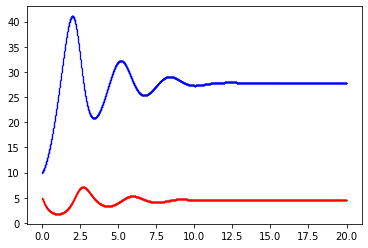

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338289.png
Epoch [21600/50000] Loss:0.001183 Loss_1:0.000000 Loss_2:0.001183 Lr:0.000442 Time:1.364587s
Epoch [21700/50000] Loss:0.001328 Loss_1:0.000007 Loss_2:0.001321 Lr:0.000441 Time:0.791327s
Epoch [21800/50000] Loss:0.001157 Loss_1:0.000000 Loss_2:0.001157 Lr:0.000439 Time:0.791657s
Epoch [21900/50000] Loss:0.001133 Loss_1:0.000000 Loss_2:0.001133 Lr:0.000437 Time:0.791728s
Epoch [22000/50000] Loss:0.001141 Loss_1:0.000001 Loss_2:0.001140 Lr:0.000435 Time:0.806951s
Testing & drawing...
u= [10.001418, 10.006462, 10.011523, 10.016611, 10.021717, 10.026848, 10.031999, 10.037173, 10.042371, 10.047588] ... [27.806747, 27.806747, 27.806747, 27.806746, 27.806746, 27.806746, 27.806746, 27.806746, 27.806746, 27.806746]
v= [5.001681, 4.992746, 4.9838276, 4.974916, 4.9660187, 4.9571342, 4.94827, 4.9394135, 4.9305725, 4.921752] ... [4.530252, 4.530251, 4.5302505, 4.

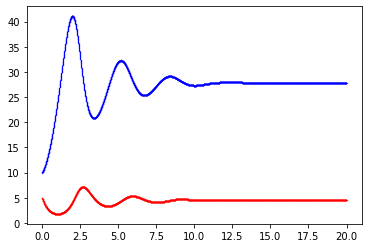

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338293.png
Epoch [22100/50000] Loss:0.001106 Loss_1:0.000000 Loss_2:0.001106 Lr:0.000433 Time:1.301219s
Epoch [22200/50000] Loss:0.001117 Loss_1:0.000000 Loss_2:0.001117 Lr:0.000431 Time:0.795207s
Epoch [22300/50000] Loss:0.001082 Loss_1:0.000000 Loss_2:0.001082 Lr:0.000429 Time:0.792497s
Epoch [22400/50000] Loss:0.001122 Loss_1:0.000003 Loss_2:0.001119 Lr:0.000427 Time:0.793270s
Epoch [22500/50000] Loss:0.001057 Loss_1:0.000000 Loss_2:0.001057 Lr:0.000426 Time:0.791883s
Testing & drawing...
u= [10.0003195, 10.00536, 10.010418, 10.015498, 10.020603, 10.025732, 10.030877, 10.036049, 10.041242, 10.046457] ... [27.807173, 27.807173, 27.807173, 27.80717, 27.807169, 27.807169, 27.807169, 27.807169, 27.807167, 27.807167]
v= [5.0001283, 4.9911914, 4.982272, 4.97336, 4.964461, 4.955576, 4.9467106, 4.9378552, 4.929015, 4.9201946] ... [4.530486, 4.530485, 4.5304847, 4.5

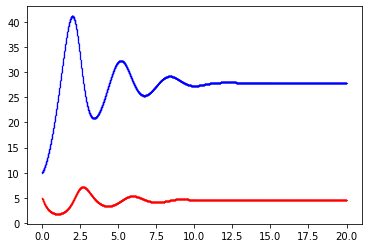

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338298.png
Epoch [22600/50000] Loss:0.001081 Loss_1:0.000002 Loss_2:0.001079 Lr:0.000424 Time:1.295270s
Epoch [22700/50000] Loss:0.001034 Loss_1:0.000000 Loss_2:0.001034 Lr:0.000422 Time:0.791214s
Epoch [22800/50000] Loss:0.001372 Loss_1:0.000030 Loss_2:0.001342 Lr:0.000420 Time:0.816058s
Epoch [22900/50000] Loss:0.001012 Loss_1:0.000000 Loss_2:0.001012 Lr:0.000418 Time:0.792358s
Epoch [23000/50000] Loss:0.001724 Loss_1:0.000102 Loss_2:0.001622 Lr:0.000417 Time:0.791630s
Testing & drawing...
u= [9.981701, 9.986663, 9.991646, 9.996653, 10.00168, 10.006731, 10.0118, 10.016895, 10.022014, 10.027151] ... [27.809143, 27.809143, 27.809143, 27.809143, 27.809143, 27.809143, 27.809143, 27.809143, 27.809143, 27.809143]
v= [4.9830637, 4.9741983, 4.9653506, 4.956511, 4.947685, 4.9388742, 4.930083, 4.921302, 4.912537, 4.903793] ... [4.5309854, 4.530985, 4.530984, 4.5309834

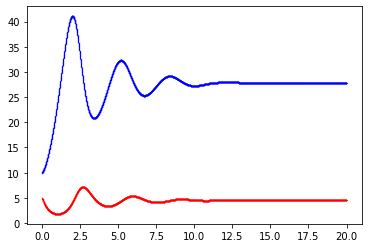

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338302.png
Epoch [23100/50000] Loss:0.000994 Loss_1:0.000000 Loss_2:0.000994 Lr:0.000415 Time:1.345480s
Epoch [23200/50000] Loss:0.001019 Loss_1:0.000002 Loss_2:0.001017 Lr:0.000413 Time:0.791497s
Epoch [23300/50000] Loss:0.000975 Loss_1:0.000000 Loss_2:0.000975 Lr:0.000412 Time:0.791147s
Epoch [23400/50000] Loss:0.027431 Loss_1:0.002194 Loss_2:0.025237 Lr:0.000410 Time:0.793244s
Epoch [23500/50000] Loss:0.000953 Loss_1:0.000000 Loss_2:0.000953 Lr:0.000408 Time:0.791054s
Testing & drawing...
u= [10.000579, 10.005619, 10.010676, 10.0157585, 10.020865, 10.025993, 10.03114, 10.036311, 10.041508, 10.046722] ... [27.807306, 27.807302, 27.807302, 27.807302, 27.807302, 27.807302, 27.807302, 27.807302, 27.807302, 27.807302]
v= [5.0004683, 4.991528, 4.982605, 4.9736905, 4.964789, 4.955901, 4.9470334, 4.9381757, 4.9293337, 4.9205136] ... [4.530588, 4.530587, 4.5305867, 

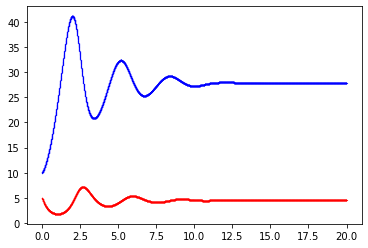

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338307.png
Epoch [23600/50000] Loss:0.002140 Loss_1:0.000046 Loss_2:0.002094 Lr:0.000407 Time:1.352600s
Epoch [23700/50000] Loss:0.000930 Loss_1:0.000000 Loss_2:0.000930 Lr:0.000405 Time:0.791182s
Epoch [23800/50000] Loss:0.001136 Loss_1:0.000009 Loss_2:0.001126 Lr:0.000403 Time:0.790862s
Epoch [23900/50000] Loss:0.000911 Loss_1:0.000000 Loss_2:0.000911 Lr:0.000402 Time:0.791228s
Epoch [24000/50000] Loss:0.000918 Loss_1:0.000000 Loss_2:0.000918 Lr:0.000400 Time:0.790608s
Testing & drawing...
u= [10.0004635, 10.005503, 10.010563, 10.015646, 10.020752, 10.025882, 10.031027, 10.036201, 10.041399, 10.046612] ... [27.805904, 27.805904, 27.8059, 27.8059, 27.8059, 27.8059, 27.8059, 27.8059, 27.8059, 27.8059]
v= [5.000718, 4.991777, 4.982853, 4.973936, 4.9650335, 4.956145, 4.947277, 4.938418, 4.9295764, 4.920755] ... [4.5302243, 4.5302243, 4.5302243, 4.5302234, 4.5302

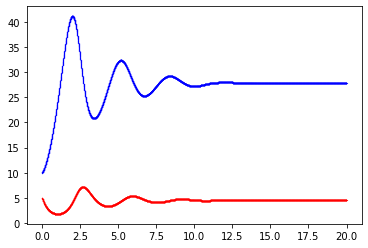

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338311.png
Epoch [24100/50000] Loss:0.018103 Loss_1:0.001756 Loss_2:0.016347 Lr:0.000398 Time:1.343340s
Epoch [24200/50000] Loss:0.000887 Loss_1:0.000000 Loss_2:0.000887 Lr:0.000397 Time:0.790421s
Epoch [24300/50000] Loss:0.001810 Loss_1:0.000135 Loss_2:0.001675 Lr:0.000395 Time:0.792778s
Epoch [24400/50000] Loss:0.000873 Loss_1:0.000000 Loss_2:0.000873 Lr:0.000394 Time:0.791498s
Epoch [24500/50000] Loss:0.001370 Loss_1:0.000019 Loss_2:0.001351 Lr:0.000392 Time:0.816938s
Testing & drawing...
u= [10.0045185, 10.009576, 10.014647, 10.019747, 10.024868, 10.030007, 10.035172, 10.040359, 10.045569, 10.050798] ... [27.797384, 27.797384, 27.797384, 27.797384, 27.797384, 27.797384, 27.797384, 27.797384, 27.797382, 27.797382]
v= [5.007105, 4.9981484, 4.989209, 4.980278, 4.97136, 4.9624567, 4.9535723, 4.9446993, 4.93584, 4.927003] ... [4.5276794, 4.5276785, 4.5276785, 4

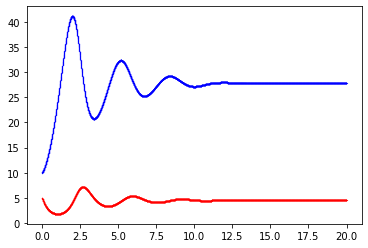

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338316.png
Epoch [24600/50000] Loss:0.000861 Loss_1:0.000001 Loss_2:0.000860 Lr:0.000391 Time:1.301752s
Epoch [24700/50000] Loss:0.001928 Loss_1:0.000057 Loss_2:0.001872 Lr:0.000389 Time:0.791180s
Epoch [24800/50000] Loss:0.000844 Loss_1:0.000000 Loss_2:0.000844 Lr:0.000388 Time:0.790891s
Epoch [24900/50000] Loss:0.006029 Loss_1:0.000559 Loss_2:0.005470 Lr:0.000386 Time:0.791420s
Epoch [25000/50000] Loss:0.000830 Loss_1:0.000000 Loss_2:0.000830 Lr:0.000385 Time:0.790955s
Testing & drawing...
u= [10.000396, 10.005435, 10.010494, 10.015578, 10.020683, 10.02581, 10.030957, 10.036129, 10.041324, 10.046537] ... [27.806978, 27.806978, 27.806978, 27.806978, 27.806978, 27.806978, 27.806978, 27.806974, 27.806974, 27.806974]
v= [5.0001845, 4.991241, 4.982316, 4.9733973, 4.9644933, 4.955605, 4.9467354, 4.9378777, 4.9290347, 4.9202137] ... [4.530771, 4.5307703, 4.5307703,

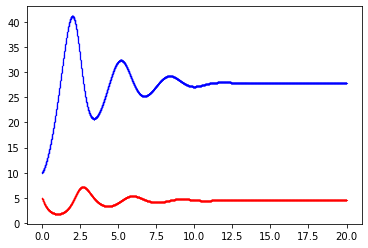

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338320.png
Epoch [25100/50000] Loss:0.021930 Loss_1:0.002081 Loss_2:0.019848 Lr:0.000383 Time:1.296709s
Epoch [25200/50000] Loss:0.000818 Loss_1:0.000000 Loss_2:0.000818 Lr:0.000382 Time:0.794093s
Epoch [25300/50000] Loss:0.005757 Loss_1:0.000257 Loss_2:0.005500 Lr:0.000380 Time:0.811205s
Epoch [25400/50000] Loss:0.000806 Loss_1:0.000000 Loss_2:0.000806 Lr:0.000379 Time:0.799314s
Epoch [25500/50000] Loss:0.001013 Loss_1:0.000011 Loss_2:0.001002 Lr:0.000377 Time:0.791558s
Testing & drawing...
u= [9.997101, 10.0021305, 10.007177, 10.012249, 10.017346, 10.022462, 10.027599, 10.032759, 10.037942, 10.043144] ... [27.81271, 27.81271, 27.81271, 27.81271, 27.812708, 27.812708, 27.812708, 27.812708, 27.812708, 27.812708]
v= [4.995446, 4.986509, 4.97759, 4.9686804, 4.9597855, 4.950905, 4.942045, 4.933196, 4.924363, 4.915553] ... [4.5327063, 4.532706, 4.532706, 4.5327053

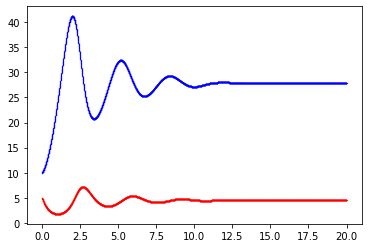

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338325.png
Epoch [25600/50000] Loss:0.000798 Loss_1:0.000000 Loss_2:0.000798 Lr:0.000376 Time:1.369369s
Epoch [25700/50000] Loss:0.000787 Loss_1:0.000000 Loss_2:0.000787 Lr:0.000375 Time:0.793936s
Epoch [25800/50000] Loss:0.000789 Loss_1:0.000000 Loss_2:0.000788 Lr:0.000373 Time:0.791510s
Epoch [25900/50000] Loss:0.000775 Loss_1:0.000000 Loss_2:0.000775 Lr:0.000372 Time:0.792176s
Epoch [26000/50000] Loss:0.000789 Loss_1:0.000000 Loss_2:0.000789 Lr:0.000370 Time:0.793487s
Testing & drawing...
u= [10.0005455, 10.005586, 10.010645, 10.015731, 10.020837, 10.025967, 10.031115, 10.036286, 10.041483, 10.046698] ... [27.80538, 27.805378, 27.805378, 27.805378, 27.805378, 27.805378, 27.805378, 27.805378, 27.805378, 27.805378]
v= [5.0006604, 4.991713, 4.9827847, 4.9738636, 4.964957, 4.956065, 4.9471946, 4.938334, 4.9294896, 4.9206657] ... [4.530413, 4.530413, 4.530412, 4

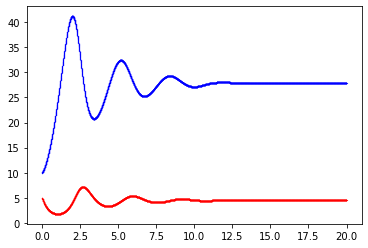

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338329.png
Epoch [26100/50000] Loss:0.000772 Loss_1:0.000001 Loss_2:0.000771 Lr:0.000369 Time:1.309920s
Epoch [26200/50000] Loss:0.000768 Loss_1:0.000000 Loss_2:0.000768 Lr:0.000368 Time:0.792892s
Epoch [26300/50000] Loss:0.000804 Loss_1:0.000002 Loss_2:0.000802 Lr:0.000366 Time:0.791925s
Epoch [26400/50000] Loss:0.000758 Loss_1:0.000000 Loss_2:0.000758 Lr:0.000365 Time:0.791385s
Epoch [26500/50000] Loss:0.000747 Loss_1:0.000000 Loss_2:0.000747 Lr:0.000364 Time:0.791260s
Testing & drawing...
u= [10.000269, 10.005308, 10.0103655, 10.0154505, 10.020558, 10.025683, 10.030831, 10.036004, 10.041199, 10.046412] ... [27.80624, 27.80624, 27.80624, 27.80624, 27.80624, 27.806238, 27.806238, 27.806238, 27.806236, 27.806236]
v= [5.0002155, 4.9912667, 4.982338, 4.9734173, 4.9645095, 4.9556174, 4.946746, 4.9378853, 4.929041, 4.9202185] ... [4.53079, 4.5307894, 4.530789, 4.5

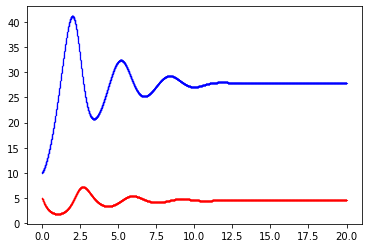

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338334.png
Epoch [26600/50000] Loss:0.000748 Loss_1:0.000000 Loss_2:0.000748 Lr:0.000362 Time:1.301319s
Epoch [26700/50000] Loss:0.000788 Loss_1:0.000002 Loss_2:0.000786 Lr:0.000361 Time:0.794823s
Epoch [26800/50000] Loss:0.000740 Loss_1:0.000000 Loss_2:0.000740 Lr:0.000360 Time:0.793193s
Epoch [26900/50000] Loss:0.006013 Loss_1:0.000275 Loss_2:0.005738 Lr:0.000358 Time:0.793677s
Epoch [27000/50000] Loss:0.000731 Loss_1:0.000000 Loss_2:0.000731 Lr:0.000357 Time:0.812843s
Testing & drawing...
u= [9.999936, 10.004974, 10.010032, 10.015112, 10.020218, 10.025343, 10.030487, 10.035659, 10.040853, 10.046064] ... [27.806843, 27.806843, 27.806843, 27.806843, 27.806843, 27.806839, 27.806839, 27.806839, 27.806839, 27.806839]
v= [4.9999657, 4.9910192, 4.9820905, 4.973169, 4.964263, 4.955372, 4.9465017, 4.937642, 4.9287996, 4.919977] ... [4.530979, 4.5309787, 4.5309787, 4

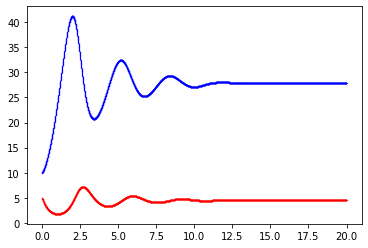

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338338.png
Epoch [27100/50000] Loss:0.000723 Loss_1:0.000000 Loss_2:0.000723 Lr:0.000356 Time:1.351411s
Epoch [27200/50000] Loss:0.000734 Loss_1:0.000000 Loss_2:0.000733 Lr:0.000355 Time:0.791441s
Epoch [27300/50000] Loss:0.006481 Loss_1:0.000312 Loss_2:0.006169 Lr:0.000353 Time:0.790349s
Epoch [27400/50000] Loss:0.000714 Loss_1:0.000000 Loss_2:0.000714 Lr:0.000352 Time:0.791333s
Epoch [27500/50000] Loss:0.003226 Loss_1:0.000326 Loss_2:0.002899 Lr:0.000351 Time:0.790934s
Testing & drawing...
u= [10.010711, 10.015761, 10.020833, 10.025927, 10.031044, 10.036184, 10.041344, 10.04653, 10.051737, 10.056963] ... [27.808437, 27.808437, 27.808437, 27.808437, 27.808437, 27.808437, 27.808437, 27.808435, 27.808435, 27.808435]
v= [5.013828, 5.004888, 4.9959664, 4.987052, 4.9781504, 4.9692636, 4.9603972, 4.9515386, 4.942696, 4.9338737] ... [4.5314317, 4.531431, 4.531431, 4

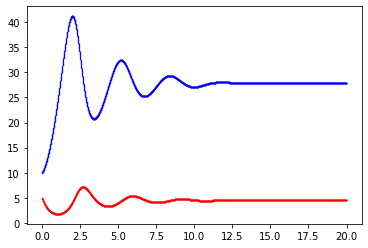

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338343.png
Epoch [27600/50000] Loss:0.000707 Loss_1:0.000000 Loss_2:0.000707 Lr:0.000350 Time:1.315441s
Epoch [27700/50000] Loss:0.001000 Loss_1:0.000011 Loss_2:0.000988 Lr:0.000348 Time:0.790513s
Epoch [27800/50000] Loss:0.000701 Loss_1:0.000000 Loss_2:0.000701 Lr:0.000347 Time:0.814687s
Epoch [27900/50000] Loss:0.004346 Loss_1:0.000466 Loss_2:0.003880 Lr:0.000346 Time:0.792023s
Epoch [28000/50000] Loss:0.000695 Loss_1:0.000000 Loss_2:0.000695 Lr:0.000345 Time:0.798437s
Testing & drawing...
u= [10.00039, 10.005428, 10.010488, 10.015573, 10.020678, 10.025806, 10.030952, 10.036126, 10.04132, 10.046535] ... [27.80647, 27.80647, 27.80647, 27.80647, 27.80647, 27.80647, 27.80647, 27.80647, 27.80647, 27.80647]
v= [5.000297, 4.991348, 4.9824157, 4.973494, 4.9645863, 4.9556937, 4.9468217, 4.9379597, 4.9291153, 4.9202924] ... [4.5310097, 4.53101, 4.531009, 4.531009, 4.

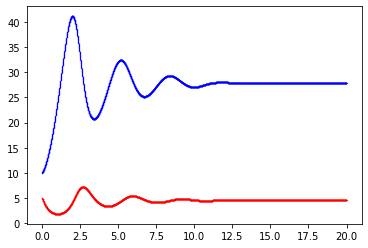

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338347.png
Epoch [28100/50000] Loss:0.000698 Loss_1:0.000000 Loss_2:0.000698 Lr:0.000344 Time:1.286515s
Epoch [28200/50000] Loss:0.000689 Loss_1:0.000000 Loss_2:0.000689 Lr:0.000342 Time:0.791315s
Epoch [28300/50000] Loss:0.002898 Loss_1:0.000118 Loss_2:0.002780 Lr:0.000341 Time:0.791409s
Epoch [28400/50000] Loss:0.000682 Loss_1:0.000000 Loss_2:0.000682 Lr:0.000340 Time:0.791194s
Epoch [28500/50000] Loss:0.000678 Loss_1:0.000000 Loss_2:0.000678 Lr:0.000339 Time:0.794695s
Testing & drawing...
u= [9.999726, 10.004767, 10.009825, 10.014908, 10.020011, 10.025138, 10.030284, 10.035455, 10.040649, 10.04586] ... [27.807104, 27.807104, 27.807104, 27.807104, 27.807104, 27.807104, 27.807104, 27.807104, 27.807104, 27.807104]
v= [4.9994874, 4.9905376, 4.981606, 4.972684, 4.9637766, 4.954884, 4.946013, 4.937152, 4.9283085, 4.919485] ... [4.5313096, 4.5313096, 4.5313096, 4.

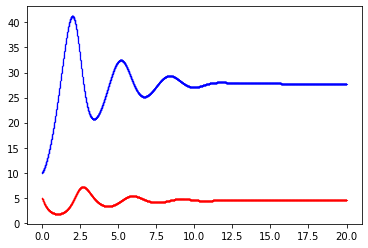

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338352.png
Epoch [28600/50000] Loss:0.000677 Loss_1:0.000000 Loss_2:0.000677 Lr:0.000338 Time:1.373445s
Epoch [28700/50000] Loss:0.000670 Loss_1:0.000000 Loss_2:0.000670 Lr:0.000337 Time:0.791163s
Epoch [28800/50000] Loss:0.000724 Loss_1:0.000001 Loss_2:0.000723 Lr:0.000336 Time:0.791607s
Epoch [28900/50000] Loss:0.000665 Loss_1:0.000000 Loss_2:0.000665 Lr:0.000334 Time:0.791543s
Epoch [29000/50000] Loss:0.000762 Loss_1:0.000003 Loss_2:0.000759 Lr:0.000333 Time:0.791690s
Testing & drawing...
u= [9.9987545, 10.003791, 10.008844, 10.013925, 10.019027, 10.024149, 10.029294, 10.034462, 10.039653, 10.044863] ... [27.804188, 27.804188, 27.804188, 27.804188, 27.804188, 27.804188, 27.804188, 27.804188, 27.804188, 27.804188]
v= [4.997306, 4.9883757, 4.9794655, 4.9705634, 4.9616756, 4.952804, 4.943952, 4.9351115, 4.9262867, 4.917485] ... [4.5304575, 4.5304575, 4.5304575

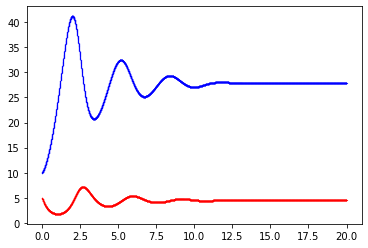

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338356.png
Epoch [29100/50000] Loss:0.000662 Loss_1:0.000000 Loss_2:0.000662 Lr:0.000332 Time:1.298656s
Epoch [29200/50000] Loss:0.000661 Loss_1:0.000000 Loss_2:0.000661 Lr:0.000331 Time:0.791622s
Epoch [29300/50000] Loss:0.000658 Loss_1:0.000000 Loss_2:0.000658 Lr:0.000330 Time:0.793639s
Epoch [29400/50000] Loss:0.002175 Loss_1:0.000079 Loss_2:0.002095 Lr:0.000329 Time:0.792155s
Epoch [29500/50000] Loss:0.000652 Loss_1:0.000000 Loss_2:0.000651 Lr:0.000328 Time:0.815389s
Testing & drawing...
u= [10.000069, 10.005106, 10.010162, 10.015247, 10.020351, 10.025478, 10.030624, 10.035795, 10.040991, 10.046204] ... [27.806793, 27.806793, 27.806793, 27.806793, 27.806791, 27.806791, 27.806791, 27.806791, 27.806791, 27.806791]
v= [4.9999475, 4.990997, 4.9820633, 4.97314, 4.964231, 4.955339, 4.9464655, 4.937604, 4.928759, 4.9199367] ... [4.531348, 4.531348, 4.531348, 4.53

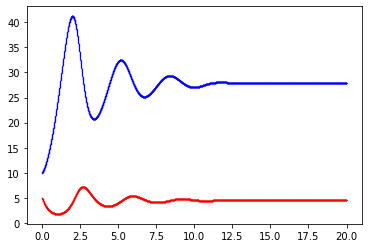

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338361.png
Epoch [29600/50000] Loss:0.000671 Loss_1:0.000001 Loss_2:0.000670 Lr:0.000327 Time:1.359958s
Epoch [29700/50000] Loss:0.000649 Loss_1:0.000000 Loss_2:0.000649 Lr:0.000326 Time:0.794799s
Epoch [29800/50000] Loss:0.000641 Loss_1:0.000000 Loss_2:0.000641 Lr:0.000325 Time:0.792078s
Epoch [29900/50000] Loss:0.000669 Loss_1:0.000001 Loss_2:0.000668 Lr:0.000324 Time:0.792771s
Epoch [30000/50000] Loss:0.000637 Loss_1:0.000000 Loss_2:0.000637 Lr:0.000323 Time:0.792719s
Testing & drawing...
u= [10.0002365, 10.005276, 10.010335, 10.01542, 10.020524, 10.025651, 10.030799, 10.035971, 10.041166, 10.046382] ... [27.806686, 27.806686, 27.806686, 27.806686, 27.806686, 27.806686, 27.806686, 27.806686, 27.806686, 27.806686]
v= [5.0001445, 4.991192, 4.9822583, 4.9733334, 4.9644237, 4.955529, 4.946656, 4.9377937, 4.928947, 4.9201245] ... [4.5314264, 4.5314264, 4.5314264

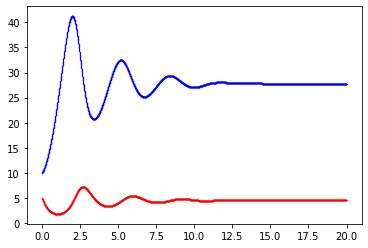

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338365.png
Epoch [30100/50000] Loss:0.001557 Loss_1:0.000091 Loss_2:0.001466 Lr:0.000322 Time:1.299760s
Epoch [30200/50000] Loss:0.000635 Loss_1:0.000000 Loss_2:0.000635 Lr:0.000321 Time:0.794675s
Epoch [30300/50000] Loss:0.000630 Loss_1:0.000000 Loss_2:0.000630 Lr:0.000319 Time:0.812077s
Epoch [30400/50000] Loss:0.000660 Loss_1:0.000003 Loss_2:0.000657 Lr:0.000318 Time:0.791811s
Epoch [30500/50000] Loss:0.000626 Loss_1:0.000000 Loss_2:0.000626 Lr:0.000317 Time:0.796167s
Testing & drawing...
u= [10.000199, 10.005239, 10.0103, 10.015381, 10.020488, 10.025615, 10.030761, 10.035934, 10.04113, 10.046343] ... [27.80668, 27.80668, 27.80668, 27.80668, 27.80668, 27.80668, 27.80668, 27.80668, 27.80668, 27.80668]
v= [5.000102, 4.9911494, 4.982216, 4.973291, 4.9643817, 4.955486, 4.946613, 4.93775, 4.9289036, 4.9200797] ... [4.531531, 4.531531, 4.531531, 4.531531, 4.53153

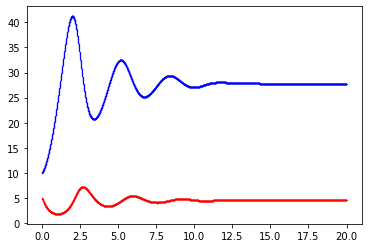

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338370.png
Epoch [30600/50000] Loss:0.001084 Loss_1:0.000013 Loss_2:0.001071 Lr:0.000316 Time:1.304347s
Epoch [30700/50000] Loss:0.000621 Loss_1:0.000000 Loss_2:0.000621 Lr:0.000315 Time:0.791324s
Epoch [30800/50000] Loss:0.003821 Loss_1:0.000411 Loss_2:0.003410 Lr:0.000314 Time:0.792212s
Epoch [30900/50000] Loss:0.000619 Loss_1:0.000000 Loss_2:0.000619 Lr:0.000313 Time:0.791826s
Epoch [31000/50000] Loss:0.000614 Loss_1:0.000000 Loss_2:0.000614 Lr:0.000313 Time:0.791085s
Testing & drawing...
u= [10.00019, 10.00523, 10.010288, 10.015373, 10.020477, 10.025606, 10.030752, 10.035924, 10.041121, 10.046332] ... [27.806755, 27.806755, 27.806755, 27.806755, 27.806755, 27.806755, 27.806755, 27.806755, 27.806755, 27.806755]
v= [5.000066, 4.991112, 4.9821773, 4.9732523, 4.9643426, 4.955447, 4.9465723, 4.93771, 4.9288626, 4.9200377] ... [4.5316663, 4.5316668, 4.5316668, 4

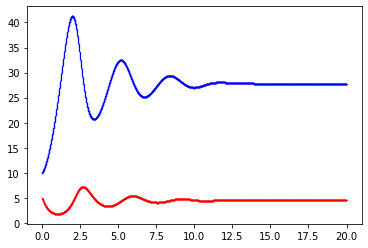

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338374.png
Epoch [31100/50000] Loss:0.000627 Loss_1:0.000002 Loss_2:0.000625 Lr:0.000312 Time:1.387385s
Epoch [31200/50000] Loss:0.000610 Loss_1:0.000000 Loss_2:0.000610 Lr:0.000311 Time:0.791405s
Epoch [31300/50000] Loss:0.000615 Loss_1:0.000000 Loss_2:0.000615 Lr:0.000310 Time:0.791432s
Epoch [31400/50000] Loss:0.000606 Loss_1:0.000000 Loss_2:0.000606 Lr:0.000309 Time:0.790603s
Epoch [31500/50000] Loss:0.000606 Loss_1:0.000000 Loss_2:0.000606 Lr:0.000308 Time:0.791372s
Testing & drawing...
u= [10.000046, 10.005087, 10.010143, 10.015227, 10.020333, 10.025461, 10.030608, 10.03578, 10.040976, 10.046187] ... [27.807308, 27.807308, 27.807308, 27.807308, 27.807308, 27.807308, 27.807308, 27.807308, 27.807308, 27.807308]
v= [5.000064, 4.9911103, 4.982176, 4.9732513, 4.96434, 4.9554462, 4.9465723, 4.937711, 4.9288635, 4.9200397] ... [4.531925, 4.531926, 4.531926, 4.5

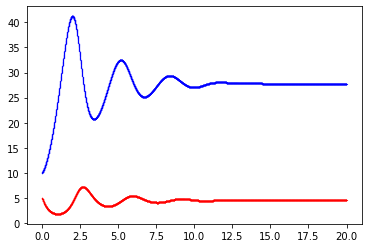

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338379.png
Epoch [31600/50000] Loss:0.000601 Loss_1:0.000000 Loss_2:0.000601 Lr:0.000307 Time:1.303401s
Epoch [31700/50000] Loss:0.000603 Loss_1:0.000000 Loss_2:0.000603 Lr:0.000306 Time:0.792571s
Epoch [31800/50000] Loss:0.000597 Loss_1:0.000000 Loss_2:0.000597 Lr:0.000305 Time:0.791564s
Epoch [31900/50000] Loss:0.000605 Loss_1:0.000000 Loss_2:0.000605 Lr:0.000304 Time:0.791419s
Epoch [32000/50000] Loss:0.000594 Loss_1:0.000000 Loss_2:0.000594 Lr:0.000303 Time:0.805050s
Testing & drawing...
u= [10.000183, 10.005222, 10.0102825, 10.015367, 10.020471, 10.025598, 10.0307455, 10.035918, 10.041112, 10.046328] ... [27.806705, 27.806705, 27.806705, 27.806705, 27.806705, 27.806705, 27.806705, 27.806705, 27.806705, 27.806705]
v= [5.000127, 4.9911723, 4.982237, 4.9733095, 4.964398, 4.9555025, 4.946627, 4.937763, 4.928917, 4.920092] ... [4.5319223, 4.531923, 4.531923, 4

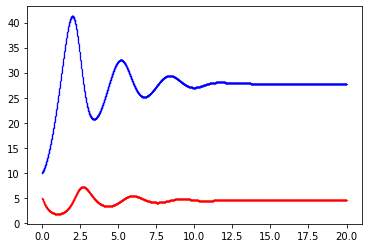

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338383.png
Epoch [32100/50000] Loss:0.000626 Loss_1:0.000000 Loss_2:0.000626 Lr:0.000302 Time:1.284127s
Epoch [32200/50000] Loss:0.000590 Loss_1:0.000000 Loss_2:0.000590 Lr:0.000301 Time:0.790537s
Epoch [32300/50000] Loss:0.000650 Loss_1:0.000002 Loss_2:0.000648 Lr:0.000300 Time:0.791306s
Epoch [32400/50000] Loss:0.000586 Loss_1:0.000000 Loss_2:0.000586 Lr:0.000299 Time:0.791149s
Epoch [32500/50000] Loss:0.000828 Loss_1:0.000030 Loss_2:0.000797 Lr:0.000299 Time:0.791145s
Testing & drawing...
u= [10.004554, 10.009607, 10.014682, 10.01978, 10.024901, 10.030045, 10.035206, 10.040393, 10.045602, 10.05083] ... [27.80439, 27.80439, 27.80439, 27.80439, 27.80439, 27.80439, 27.80439, 27.80439, 27.80439, 27.80439]
v= [5.0040603, 4.995107, 4.986172, 4.9772468, 4.9683356, 4.9594398, 4.950565, 4.9417014, 4.9328537, 4.924028] ... [4.531361, 4.5313616, 4.5313616, 4.531362, 4

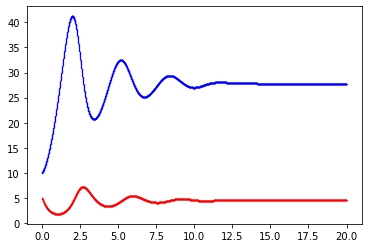

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338388.png
Epoch [32600/50000] Loss:0.000583 Loss_1:0.000000 Loss_2:0.000583 Lr:0.000298 Time:1.368417s
Epoch [32700/50000] Loss:0.000902 Loss_1:0.000040 Loss_2:0.000862 Lr:0.000297 Time:0.792986s
Epoch [32800/50000] Loss:0.000579 Loss_1:0.000000 Loss_2:0.000579 Lr:0.000296 Time:0.813925s
Epoch [32900/50000] Loss:0.000629 Loss_1:0.000002 Loss_2:0.000627 Lr:0.000295 Time:0.791631s
Epoch [33000/50000] Loss:0.000576 Loss_1:0.000000 Loss_2:0.000576 Lr:0.000294 Time:0.791182s
Testing & drawing...
u= [10.000206, 10.005247, 10.010304, 10.0153885, 10.0204935, 10.025622, 10.030769, 10.035941, 10.041136, 10.04635] ... [27.806822, 27.806822, 27.806822, 27.806822, 27.806822, 27.806822, 27.806822, 27.806822, 27.806824, 27.806824]
v= [5.0000443, 4.9910893, 4.982153, 4.9732256, 4.964313, 4.9554167, 4.946542, 4.937678, 4.92883, 4.920006] ... [4.5322495, 4.53225, 4.5322504, 4.

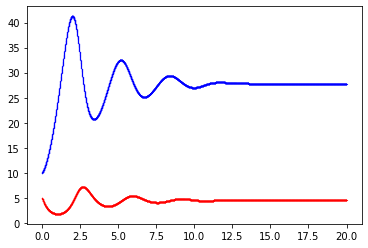

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338392.png
Epoch [33100/50000] Loss:0.000995 Loss_1:0.000060 Loss_2:0.000935 Lr:0.000293 Time:1.332136s
Epoch [33200/50000] Loss:0.000574 Loss_1:0.000000 Loss_2:0.000574 Lr:0.000292 Time:0.797014s
Epoch [33300/50000] Loss:0.000571 Loss_1:0.000000 Loss_2:0.000571 Lr:0.000292 Time:0.790899s
Epoch [33400/50000] Loss:0.000575 Loss_1:0.000000 Loss_2:0.000575 Lr:0.000291 Time:0.790604s
Epoch [33500/50000] Loss:0.000619 Loss_1:0.000003 Loss_2:0.000616 Lr:0.000290 Time:0.791010s
Testing & drawing...
u= [9.9984865, 10.00352, 10.008574, 10.013654, 10.018753, 10.023874, 10.0290165, 10.0341835, 10.039371, 10.04458] ... [27.809721, 27.809721, 27.809721, 27.809721, 27.809721, 27.809721, 27.809721, 27.809721, 27.809721, 27.809721]
v= [4.9977717, 4.988819, 4.9798875, 4.9709644, 4.9620566, 4.953165, 4.944294, 4.935435, 4.926593, 4.917773] ... [4.5332155, 4.5332155, 4.533216, 4

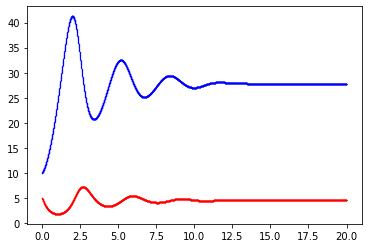

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338397.png
Epoch [33600/50000] Loss:0.000569 Loss_1:0.000000 Loss_2:0.000569 Lr:0.000289 Time:1.309166s
Epoch [33700/50000] Loss:0.000768 Loss_1:0.000009 Loss_2:0.000760 Lr:0.000288 Time:0.792810s
Epoch [33800/50000] Loss:0.000564 Loss_1:0.000000 Loss_2:0.000564 Lr:0.000287 Time:0.791170s
Epoch [33900/50000] Loss:0.000897 Loss_1:0.000013 Loss_2:0.000884 Lr:0.000287 Time:0.791710s
Epoch [34000/50000] Loss:0.000561 Loss_1:0.000000 Loss_2:0.000561 Lr:0.000286 Time:0.792304s
Testing & drawing...
u= [9.99997, 10.005006, 10.010065, 10.015148, 10.020253, 10.025381, 10.030526, 10.0357, 10.040891, 10.046104] ... [27.806705, 27.806705, 27.806705, 27.806705, 27.806705, 27.806705, 27.806705, 27.806705, 27.806705, 27.806705]
v= [4.999845, 4.990889, 4.981952, 4.973025, 4.9641128, 4.955216, 4.946341, 4.937476, 4.9286304, 4.919805] ... [4.5324693, 4.5324697, 4.5324707, 4.5324

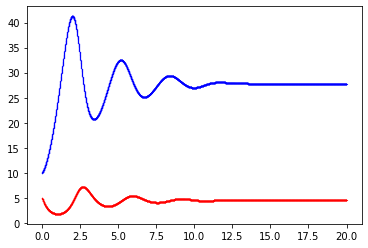

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338401.png
Epoch [34100/50000] Loss:0.001454 Loss_1:0.000109 Loss_2:0.001345 Lr:0.000285 Time:1.356961s
Epoch [34200/50000] Loss:0.000557 Loss_1:0.000000 Loss_2:0.000557 Lr:0.000284 Time:0.791116s
Epoch [34300/50000] Loss:0.000588 Loss_1:0.000002 Loss_2:0.000587 Lr:0.000283 Time:0.803625s
Epoch [34400/50000] Loss:0.000554 Loss_1:0.000000 Loss_2:0.000554 Lr:0.000282 Time:0.796457s
Epoch [34500/50000] Loss:0.000563 Loss_1:0.000001 Loss_2:0.000562 Lr:0.000282 Time:0.816965s
Testing & drawing...
u= [9.999359, 10.004393, 10.009447, 10.014526, 10.0196295, 10.0247555, 10.029895, 10.035068, 10.040258, 10.045465] ... [27.807222, 27.807222, 27.807222, 27.807222, 27.807222, 27.807222, 27.807222, 27.807222, 27.807222, 27.807222]
v= [4.99859, 4.9896355, 4.9806995, 4.9717746, 4.962865, 4.95397, 4.9450955, 4.9362345, 4.9273906, 4.918567] ... [4.532701, 4.5327015, 4.532702, 4

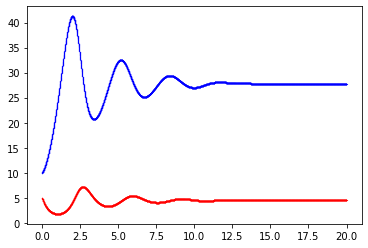

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338406.png
Epoch [34600/50000] Loss:0.000552 Loss_1:0.000000 Loss_2:0.000552 Lr:0.000281 Time:1.288863s
Epoch [34700/50000] Loss:0.000809 Loss_1:0.000015 Loss_2:0.000794 Lr:0.000280 Time:0.792234s
Epoch [34800/50000] Loss:0.000550 Loss_1:0.000000 Loss_2:0.000550 Lr:0.000279 Time:0.791358s
Epoch [34900/50000] Loss:0.001502 Loss_1:0.000087 Loss_2:0.001415 Lr:0.000279 Time:0.791444s
Epoch [35000/50000] Loss:0.000549 Loss_1:0.000000 Loss_2:0.000549 Lr:0.000278 Time:0.791148s
Testing & drawing...
u= [10.000422, 10.005464, 10.01052, 10.015606, 10.020711, 10.025839, 10.030988, 10.0361595, 10.041355, 10.046571] ... [27.806679, 27.806679, 27.806679, 27.806679, 27.806679, 27.806679, 27.806679, 27.806679, 27.806679, 27.806679]
v= [5.0002723, 4.991314, 4.982375, 4.973446, 4.964532, 4.9556336, 4.9467573, 4.9378915, 4.9290433, 4.9202175] ... [4.5327086, 4.532709, 4.5327096,

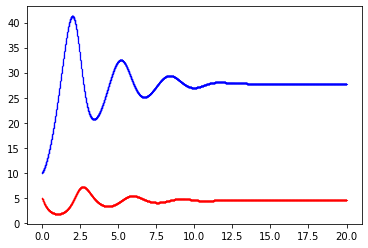

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338410.png
Epoch [35100/50000] Loss:0.000545 Loss_1:0.000000 Loss_2:0.000545 Lr:0.000277 Time:1.348743s
Epoch [35200/50000] Loss:0.001679 Loss_1:0.000094 Loss_2:0.001585 Lr:0.000276 Time:0.795852s
Epoch [35300/50000] Loss:0.001086 Loss_1:0.000033 Loss_2:0.001053 Lr:0.000275 Time:0.806610s
Epoch [35400/50000] Loss:0.000543 Loss_1:0.000000 Loss_2:0.000543 Lr:0.000275 Time:0.791285s
Epoch [35500/50000] Loss:0.000669 Loss_1:0.000011 Loss_2:0.000658 Lr:0.000274 Time:0.791395s
Testing & drawing...
u= [10.003955, 10.0090065, 10.014076, 10.019173, 10.024293, 10.02943, 10.034591, 10.039776, 10.044983, 10.050209] ... [27.803406, 27.803406, 27.803406, 27.803406, 27.803406, 27.803406, 27.803406, 27.803406, 27.803406, 27.803406]
v= [5.0046644, 4.995702, 4.9867578, 4.9778237, 4.9689045, 4.96, 4.951117, 4.9422455, 4.933392, 4.9245605] ... [4.5319114, 4.5319123, 4.531913, 4.5

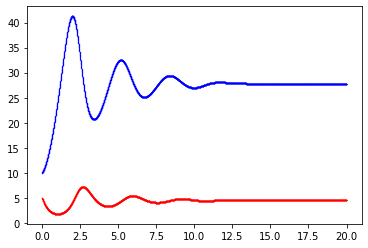

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338415.png
Epoch [35600/50000] Loss:0.000539 Loss_1:0.000000 Loss_2:0.000539 Lr:0.000273 Time:1.291111s
Epoch [35700/50000] Loss:0.000559 Loss_1:0.000002 Loss_2:0.000556 Lr:0.000272 Time:0.791351s
Epoch [35800/50000] Loss:0.000558 Loss_1:0.000001 Loss_2:0.000557 Lr:0.000272 Time:0.791536s
Epoch [35900/50000] Loss:0.000538 Loss_1:0.000000 Loss_2:0.000538 Lr:0.000271 Time:0.795168s
Epoch [36000/50000] Loss:0.000554 Loss_1:0.000002 Loss_2:0.000552 Lr:0.000270 Time:0.792540s
Testing & drawing...
u= [10.00234, 10.007385, 10.01245, 10.01754, 10.022654, 10.027787, 10.03294, 10.038121, 10.043322, 10.04854] ... [27.806288, 27.806288, 27.806288, 27.806288, 27.806288, 27.806288, 27.806288, 27.806288, 27.806288, 27.806288]
v= [5.001432, 4.992469, 4.983525, 4.974591, 4.9656725, 4.95677, 4.947889, 4.9390187, 4.930166, 4.9213357] ... [4.532839, 4.53284, 4.53284, 4.532841, 4.

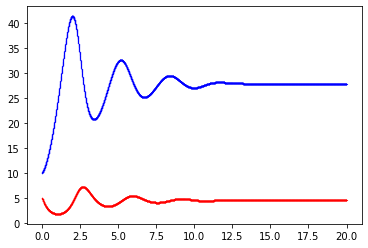

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338419.png
Epoch [36100/50000] Loss:0.000535 Loss_1:0.000000 Loss_2:0.000535 Lr:0.000270 Time:1.315975s
Epoch [36200/50000] Loss:0.000577 Loss_1:0.000003 Loss_2:0.000575 Lr:0.000269 Time:0.791728s
Epoch [36300/50000] Loss:0.000532 Loss_1:0.000000 Loss_2:0.000532 Lr:0.000268 Time:0.793757s
Epoch [36400/50000] Loss:0.000539 Loss_1:0.000001 Loss_2:0.000538 Lr:0.000267 Time:0.792131s
Epoch [36500/50000] Loss:0.000534 Loss_1:0.000000 Loss_2:0.000534 Lr:0.000267 Time:0.791230s
Testing & drawing...
u= [10.000759, 10.005802, 10.010862, 10.015946, 10.021055, 10.026185, 10.031335, 10.03651, 10.041706, 10.046922] ... [27.805916, 27.805916, 27.805916, 27.805916, 27.805916, 27.805916, 27.805916, 27.805916, 27.805916, 27.805916]
v= [5.000869, 4.9919057, 4.9829645, 4.974032, 4.965114, 4.956213, 4.947333, 4.9384656, 4.929615, 4.920786] ... [4.5328283, 4.5328293, 4.5328293, 4.

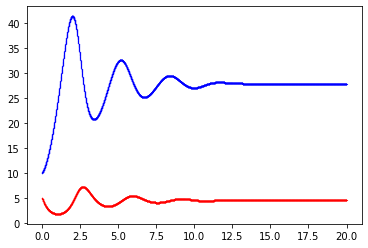

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338424.png
Epoch [36600/50000] Loss:0.000532 Loss_1:0.000000 Loss_2:0.000531 Lr:0.000266 Time:1.360869s
Epoch [36700/50000] Loss:0.000532 Loss_1:0.000001 Loss_2:0.000532 Lr:0.000265 Time:0.791320s
Epoch [36800/50000] Loss:0.004343 Loss_1:0.000368 Loss_2:0.003975 Lr:0.000265 Time:0.791300s
Epoch [36900/50000] Loss:0.004759 Loss_1:0.000347 Loss_2:0.004412 Lr:0.000264 Time:0.795515s
Epoch [37000/50000] Loss:0.000528 Loss_1:0.000000 Loss_2:0.000528 Lr:0.000263 Time:0.791547s
Testing & drawing...
u= [9.999604, 10.004643, 10.009699, 10.01478, 10.019885, 10.025012, 10.030154, 10.035326, 10.040518, 10.045731] ... [27.80715, 27.80715, 27.80715, 27.80715, 27.80715, 27.807152, 27.807152, 27.807152, 27.807152, 27.807152]
v= [4.9995017, 4.990542, 4.9816027, 4.9726725, 4.9637585, 4.95486, 4.9459834, 4.9371185, 4.9282713, 4.9194465] ... [4.5332117, 4.533212, 4.533213, 4.5332

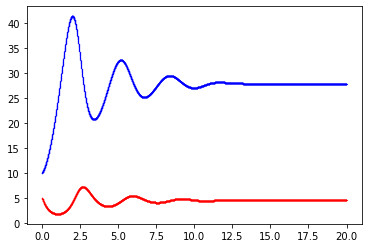

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338428.png
Epoch [37100/50000] Loss:0.000525 Loss_1:0.000000 Loss_2:0.000525 Lr:0.000262 Time:1.286183s
Epoch [37200/50000] Loss:0.001064 Loss_1:0.000046 Loss_2:0.001018 Lr:0.000262 Time:0.791152s
Epoch [37300/50000] Loss:0.000523 Loss_1:0.000000 Loss_2:0.000523 Lr:0.000261 Time:0.791207s
Epoch [37400/50000] Loss:0.000557 Loss_1:0.000002 Loss_2:0.000555 Lr:0.000260 Time:0.791338s
Epoch [37500/50000] Loss:0.000521 Loss_1:0.000000 Loss_2:0.000521 Lr:0.000260 Time:0.790585s
Testing & drawing...
u= [10.000155, 10.005196, 10.010252, 10.015335, 10.020439, 10.025568, 10.030715, 10.035887, 10.0410795, 10.046295] ... [27.806799, 27.806799, 27.806799, 27.806799, 27.806799, 27.806799, 27.806799, 27.806799, 27.806799, 27.806799]
v= [5.000043, 4.991082, 4.982141, 4.9732094, 4.9642935, 4.9553943, 4.9465165, 4.9376507, 4.9288015, 4.919975] ... [4.533177, 4.533177, 4.5331783,

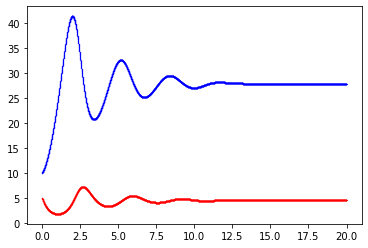

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338433.png
Epoch [37600/50000] Loss:0.000532 Loss_1:0.000001 Loss_2:0.000531 Lr:0.000259 Time:1.292842s
Epoch [37700/50000] Loss:0.001137 Loss_1:0.000035 Loss_2:0.001101 Lr:0.000258 Time:0.813444s
Epoch [37800/50000] Loss:0.000518 Loss_1:0.000000 Loss_2:0.000518 Lr:0.000258 Time:0.790481s
Epoch [37900/50000] Loss:0.000532 Loss_1:0.000000 Loss_2:0.000531 Lr:0.000257 Time:0.791605s
Epoch [38000/50000] Loss:0.000517 Loss_1:0.000000 Loss_2:0.000517 Lr:0.000256 Time:0.791337s
Testing & drawing...
u= [10.000165, 10.005205, 10.010263, 10.0153475, 10.020451, 10.02558, 10.030726, 10.035899, 10.041093, 10.046309] ... [27.806664, 27.806664, 27.806664, 27.806664, 27.806664, 27.806664, 27.806664, 27.806664, 27.806664, 27.806664]
v= [5.0000486, 4.9910874, 4.982146, 4.9732127, 4.964297, 4.9553967, 4.9465184, 4.937651, 4.928802, 4.919976] ... [4.5331726, 4.533174, 4.5331745, 

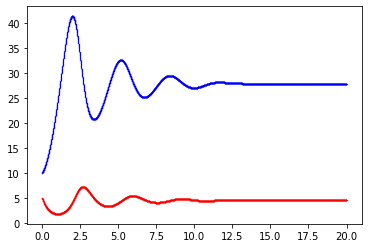

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338437.png
Epoch [38100/50000] Loss:0.000746 Loss_1:0.000027 Loss_2:0.000719 Lr:0.000256 Time:1.370121s
Epoch [38200/50000] Loss:0.000516 Loss_1:0.000000 Loss_2:0.000516 Lr:0.000255 Time:0.791333s
Epoch [38300/50000] Loss:0.000942 Loss_1:0.000044 Loss_2:0.000898 Lr:0.000254 Time:0.791301s
Epoch [38400/50000] Loss:0.000514 Loss_1:0.000000 Loss_2:0.000514 Lr:0.000254 Time:0.791183s
Epoch [38500/50000] Loss:0.000523 Loss_1:0.000000 Loss_2:0.000523 Lr:0.000253 Time:0.792803s
Testing & drawing...
u= [9.998657, 10.003692, 10.008744, 10.013822, 10.018924, 10.024048, 10.029189, 10.034357, 10.039548, 10.044757] ... [27.806965, 27.806965, 27.806965, 27.806965, 27.806965, 27.806965, 27.806965, 27.806965, 27.806965, 27.806965]
v= [4.999084, 4.990129, 4.981194, 4.972269, 4.9633594, 4.954465, 4.945594, 4.9367337, 4.9278913, 4.9190726] ... [4.533286, 4.5332875, 4.533288, 4.5

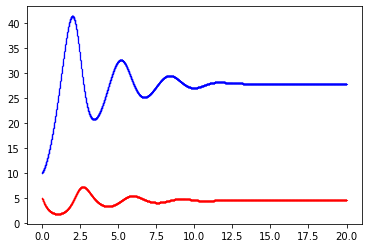

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338442.png
Epoch [38600/50000] Loss:0.000662 Loss_1:0.000014 Loss_2:0.000649 Lr:0.000253 Time:1.327629s
Epoch [38700/50000] Loss:0.000513 Loss_1:0.000000 Loss_2:0.000513 Lr:0.000252 Time:0.793356s
Epoch [38800/50000] Loss:0.004196 Loss_1:0.000257 Loss_2:0.003939 Lr:0.000251 Time:0.790908s
Epoch [38900/50000] Loss:0.000511 Loss_1:0.000000 Loss_2:0.000511 Lr:0.000251 Time:0.791478s
Epoch [39000/50000] Loss:0.004280 Loss_1:0.000270 Loss_2:0.004010 Lr:0.000250 Time:0.790572s
Testing & drawing...
u= [9.992875, 9.99787, 10.00288, 10.007919, 10.012979, 10.018059, 10.023165, 10.02829, 10.033438, 10.038608] ... [27.823507, 27.823511, 27.823507, 27.823507, 27.823507, 27.823507, 27.823511, 27.823511, 27.823511, 27.823511]
v= [4.9876914, 4.978791, 4.969911, 4.9610405, 4.952188, 4.94335, 4.9345355, 4.9257326, 4.9169464, 4.908184] ... [4.537714, 4.537715, 4.5377154, 4.53771

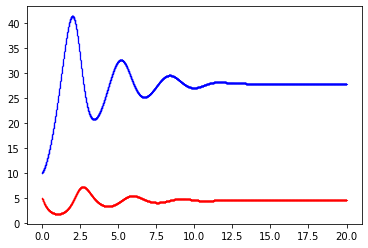

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338446.png
Epoch [39100/50000] Loss:0.000509 Loss_1:0.000000 Loss_2:0.000509 Lr:0.000249 Time:1.309987s
Epoch [39200/50000] Loss:0.007614 Loss_1:0.000447 Loss_2:0.007168 Lr:0.000249 Time:0.791568s
Epoch [39300/50000] Loss:0.000508 Loss_1:0.000000 Loss_2:0.000508 Lr:0.000248 Time:0.793164s
Epoch [39400/50000] Loss:0.001903 Loss_1:0.000142 Loss_2:0.001761 Lr:0.000248 Time:0.810945s
Epoch [39500/50000] Loss:0.000508 Loss_1:0.000000 Loss_2:0.000508 Lr:0.000247 Time:0.791407s
Testing & drawing...
u= [10.000561, 10.005597, 10.010658, 10.015742, 10.020848, 10.025976, 10.031124, 10.036295, 10.0414915, 10.046706] ... [27.806904, 27.806904, 27.806904, 27.806904, 27.806904, 27.806904, 27.806904, 27.806904, 27.806904, 27.806904]
v= [5.0003123, 4.991349, 4.9824047, 4.973471, 4.964553, 4.9556513, 4.9467726, 4.9379044, 4.9290547, 4.9202275] ... [4.5332837, 4.5332847, 4.53328

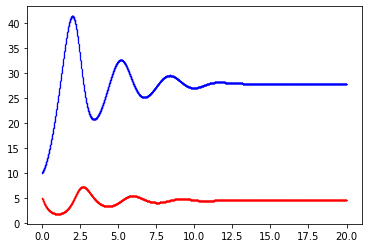

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338451.png
Epoch [39600/50000] Loss:0.000505 Loss_1:0.000000 Loss_2:0.000505 Lr:0.000246 Time:1.361216s
Epoch [39700/50000] Loss:0.000637 Loss_1:0.000006 Loss_2:0.000630 Lr:0.000246 Time:0.791486s
Epoch [39800/50000] Loss:0.000504 Loss_1:0.000000 Loss_2:0.000504 Lr:0.000245 Time:0.791776s
Epoch [39900/50000] Loss:0.000582 Loss_1:0.000006 Loss_2:0.000576 Lr:0.000244 Time:0.791756s
Epoch [40000/50000] Loss:0.000503 Loss_1:0.000000 Loss_2:0.000503 Lr:0.000244 Time:0.791225s
Testing & drawing...
u= [10.000148, 10.005187, 10.010246, 10.015328, 10.020434, 10.025562, 10.030708, 10.035881, 10.041075, 10.046288] ... [27.806625, 27.806625, 27.806625, 27.806625, 27.806625, 27.806625, 27.806625, 27.806625, 27.806625, 27.806625]
v= [5.000103, 4.991138, 4.982194, 4.97326, 4.964342, 4.95544, 4.94656, 4.9376926, 4.9288416, 4.9200144] ... [4.5332665, 4.533267, 4.5332675, 4.533

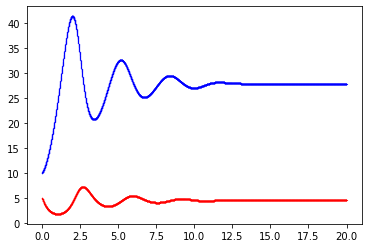

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338455.png
Epoch [40100/50000] Loss:0.000533 Loss_1:0.000003 Loss_2:0.000530 Lr:0.000243 Time:1.295470s
Epoch [40200/50000] Loss:0.000551 Loss_1:0.000001 Loss_2:0.000550 Lr:0.000243 Time:0.813892s
Epoch [40300/50000] Loss:0.006875 Loss_1:0.000495 Loss_2:0.006380 Lr:0.000242 Time:0.790954s
Epoch [40400/50000] Loss:0.000501 Loss_1:0.000000 Loss_2:0.000501 Lr:0.000242 Time:0.796622s
Epoch [40500/50000] Loss:0.000554 Loss_1:0.000004 Loss_2:0.000550 Lr:0.000241 Time:0.791933s
Testing & drawing...
u= [10.000854, 10.005893, 10.010949, 10.016035, 10.021141, 10.026269, 10.031417, 10.036591, 10.041786, 10.047001] ... [27.806492, 27.806492, 27.806492, 27.806492, 27.806492, 27.806492, 27.806492, 27.806492, 27.806492, 27.806492]
v= [5.0004845, 4.9915204, 4.9825783, 4.973645, 4.964729, 4.9558277, 4.9469504, 4.9380836, 4.929235, 4.9204097] ... [4.5332103, 4.5332117, 4.533212

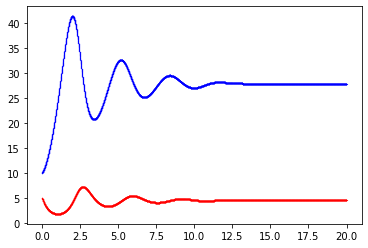

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338460.png
Epoch [40600/50000] Loss:0.000500 Loss_1:0.000000 Loss_2:0.000500 Lr:0.000240 Time:1.346226s
Epoch [40700/50000] Loss:0.000608 Loss_1:0.000010 Loss_2:0.000598 Lr:0.000240 Time:0.791526s
Epoch [40800/50000] Loss:0.000498 Loss_1:0.000000 Loss_2:0.000498 Lr:0.000239 Time:0.791130s
Epoch [40900/50000] Loss:0.000793 Loss_1:0.000037 Loss_2:0.000756 Lr:0.000239 Time:0.792770s
Epoch [41000/50000] Loss:0.000497 Loss_1:0.000000 Loss_2:0.000497 Lr:0.000238 Time:0.791913s
Testing & drawing...
u= [10.000081, 10.005119, 10.010177, 10.015259, 10.020365, 10.02549, 10.030637, 10.035809, 10.041003, 10.046215] ... [27.806704, 27.806704, 27.806704, 27.806704, 27.806704, 27.806704, 27.806704, 27.806704, 27.806704, 27.806704]
v= [5.0000114, 4.991046, 4.9821005, 4.9731665, 4.9642477, 4.955344, 4.9464655, 4.9375973, 4.928746, 4.91992] ... [4.533284, 4.533285, 4.533285, 4.5

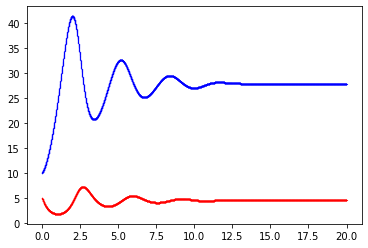

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338464.png
Epoch [41100/50000] Loss:0.000499 Loss_1:0.000000 Loss_2:0.000499 Lr:0.000238 Time:1.318976s
Epoch [41200/50000] Loss:0.000496 Loss_1:0.000000 Loss_2:0.000496 Lr:0.000237 Time:0.791548s
Epoch [41300/50000] Loss:0.000498 Loss_1:0.000000 Loss_2:0.000498 Lr:0.000236 Time:0.791529s
Epoch [41400/50000] Loss:0.000495 Loss_1:0.000000 Loss_2:0.000495 Lr:0.000236 Time:0.791414s
Epoch [41500/50000] Loss:0.000501 Loss_1:0.000001 Loss_2:0.000500 Lr:0.000235 Time:0.791498s
Testing & drawing...
u= [9.998192, 10.003223, 10.008273, 10.0133505, 10.01845, 10.023571, 10.02871, 10.033876, 10.039063, 10.044274] ... [27.805094, 27.805094, 27.805094, 27.805094, 27.805094, 27.805094, 27.805094, 27.805094, 27.805094, 27.805094]
v= [5.000356, 4.991391, 4.9824467, 4.973513, 4.964596, 4.9556947, 4.946815, 4.937949, 4.9290996, 4.920274] ... [4.5328627, 4.532864, 4.5328646, 4.53

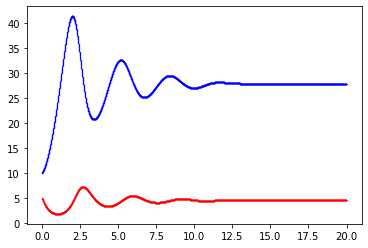

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338469.png
Epoch [41600/50000] Loss:0.000607 Loss_1:0.000012 Loss_2:0.000594 Lr:0.000235 Time:1.289302s
Epoch [41700/50000] Loss:0.001107 Loss_1:0.000048 Loss_2:0.001058 Lr:0.000234 Time:0.791955s
Epoch [41800/50000] Loss:0.000493 Loss_1:0.000000 Loss_2:0.000493 Lr:0.000234 Time:0.792585s
Epoch [41900/50000] Loss:0.005050 Loss_1:0.000350 Loss_2:0.004700 Lr:0.000233 Time:0.795325s
Epoch [42000/50000] Loss:0.000492 Loss_1:0.000000 Loss_2:0.000492 Lr:0.000233 Time:0.791039s
Testing & drawing...
u= [10.0002, 10.005239, 10.010296, 10.015379, 10.020485, 10.02561, 10.03076, 10.035929, 10.041125, 10.046338] ... [27.806833, 27.806833, 27.806835, 27.806837, 27.806837, 27.806837, 27.806837, 27.806837, 27.806837, 27.806837]
v= [5.000152, 4.991186, 4.9822407, 4.9733043, 4.9643855, 4.955483, 4.9466023, 4.9377337, 4.928882, 4.920055] ... [4.533278, 4.5332785, 4.5332794, 4.53

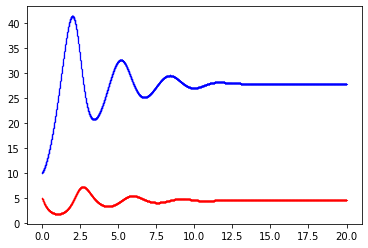

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338473.png
Epoch [42100/50000] Loss:0.000494 Loss_1:0.000000 Loss_2:0.000493 Lr:0.000232 Time:1.363416s
Epoch [42200/50000] Loss:0.000494 Loss_1:0.000000 Loss_2:0.000493 Lr:0.000231 Time:0.791202s
Epoch [42300/50000] Loss:0.000490 Loss_1:0.000000 Loss_2:0.000490 Lr:0.000231 Time:0.791302s
Epoch [42400/50000] Loss:0.000493 Loss_1:0.000000 Loss_2:0.000493 Lr:0.000230 Time:0.791031s
Epoch [42500/50000] Loss:0.000490 Loss_1:0.000000 Loss_2:0.000490 Lr:0.000230 Time:0.791151s
Testing & drawing...
u= [10.000128, 10.005164, 10.0102215, 10.015305, 10.020408, 10.025536, 10.030682, 10.035853, 10.041046, 10.046261] ... [27.806955, 27.806955, 27.806955, 27.806955, 27.806955, 27.806955, 27.806955, 27.806955, 27.806955, 27.806955]
v= [5.000039, 4.9910727, 4.982126, 4.973191, 4.964271, 4.9553685, 4.9464893, 4.93762, 4.9287696, 4.919943] ... [4.533293, 4.5332932, 4.533294, 4.

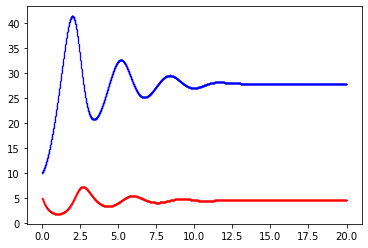

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338478.png
Epoch [42600/50000] Loss:0.000490 Loss_1:0.000000 Loss_2:0.000490 Lr:0.000229 Time:1.296834s
Epoch [42700/50000] Loss:0.000491 Loss_1:0.000000 Loss_2:0.000491 Lr:0.000229 Time:0.814563s
Epoch [42800/50000] Loss:0.000488 Loss_1:0.000000 Loss_2:0.000488 Lr:0.000228 Time:0.791155s
Epoch [42900/50000] Loss:0.000644 Loss_1:0.000021 Loss_2:0.000623 Lr:0.000228 Time:0.791367s
Epoch [43000/50000] Loss:0.000487 Loss_1:0.000000 Loss_2:0.000486 Lr:0.000227 Time:0.791755s
Testing & drawing...
u= [10.000127, 10.005165, 10.0102215, 10.015305, 10.020409, 10.0255375, 10.030683, 10.035854, 10.04105, 10.046263] ... [27.806992, 27.806992, 27.806992, 27.806992, 27.806992, 27.806995, 27.806995, 27.806995, 27.806995, 27.806995]
v= [5.0000596, 4.9910917, 4.9821453, 4.973209, 4.9642878, 4.9553847, 4.9465046, 4.937634, 4.928784, 4.9199557] ... [4.5333033, 4.5333037, 4.53330

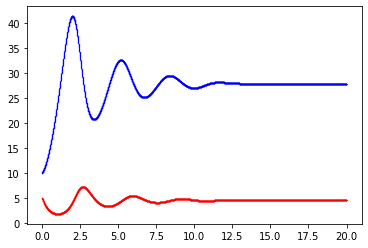

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338482.png
Epoch [43100/50000] Loss:0.000490 Loss_1:0.000001 Loss_2:0.000490 Lr:0.000227 Time:1.296612s
Epoch [43200/50000] Loss:0.007394 Loss_1:0.000554 Loss_2:0.006840 Lr:0.000226 Time:0.797437s
Epoch [43300/50000] Loss:0.000486 Loss_1:0.000000 Loss_2:0.000486 Lr:0.000226 Time:0.790363s
Epoch [43400/50000] Loss:0.003532 Loss_1:0.000240 Loss_2:0.003292 Lr:0.000225 Time:0.791474s
Epoch [43500/50000] Loss:0.000485 Loss_1:0.000000 Loss_2:0.000485 Lr:0.000225 Time:0.812818s
Testing & drawing...
u= [10.000326, 10.005365, 10.010422, 10.015505, 10.020611, 10.025738, 10.030886, 10.036057, 10.04125, 10.046465] ... [27.806885, 27.806885, 27.806885, 27.806885, 27.806885, 27.806885, 27.806885, 27.806885, 27.806885, 27.806885]
v= [5.0002832, 4.9913154, 4.982368, 4.973431, 4.96451, 4.9556055, 4.9467244, 4.9378543, 4.929003, 4.9201746] ... [4.533255, 4.5332565, 4.533257, 4.

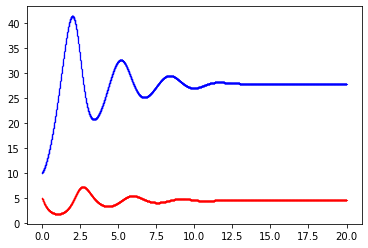

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338487.png
Epoch [43600/50000] Loss:0.000673 Loss_1:0.000017 Loss_2:0.000655 Lr:0.000224 Time:1.363455s
Epoch [43700/50000] Loss:0.000483 Loss_1:0.000000 Loss_2:0.000483 Lr:0.000224 Time:0.791240s
Epoch [43800/50000] Loss:0.000484 Loss_1:0.000000 Loss_2:0.000484 Lr:0.000223 Time:0.796548s
Epoch [43900/50000] Loss:0.000994 Loss_1:0.000040 Loss_2:0.000954 Lr:0.000223 Time:0.791817s
Epoch [44000/50000] Loss:0.000482 Loss_1:0.000000 Loss_2:0.000482 Lr:0.000222 Time:0.792199s
Testing & drawing...
u= [10.000098, 10.005136, 10.010193, 10.015275, 10.020378, 10.025506, 10.030652, 10.035822, 10.041017, 10.04623] ... [27.807096, 27.807096, 27.807096, 27.807098, 27.8071, 27.8071, 27.8071, 27.8071, 27.8071, 27.8071]
v= [5.000082, 4.9911137, 4.9821663, 4.9732294, 4.9643087, 4.955405, 4.9465237, 4.9376554, 4.9288044, 4.919976] ... [4.533284, 4.533285, 4.533286, 4.533286, 4.5

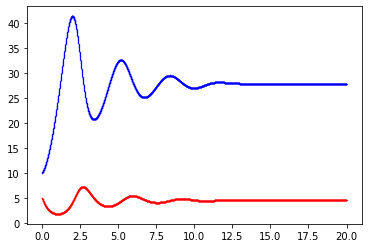

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338491.png
Epoch [44100/50000] Loss:0.001412 Loss_1:0.000055 Loss_2:0.001357 Lr:0.000222 Time:1.306859s
Epoch [44200/50000] Loss:0.000482 Loss_1:0.000000 Loss_2:0.000482 Lr:0.000221 Time:0.792122s
Epoch [44300/50000] Loss:0.000481 Loss_1:0.000000 Loss_2:0.000481 Lr:0.000221 Time:0.794384s
Epoch [44400/50000] Loss:0.000967 Loss_1:0.000064 Loss_2:0.000904 Lr:0.000220 Time:0.795668s
Epoch [44500/50000] Loss:0.000480 Loss_1:0.000000 Loss_2:0.000480 Lr:0.000220 Time:0.790940s
Testing & drawing...
u= [10.000051, 10.005089, 10.010145, 10.015229, 10.020331, 10.025458, 10.030604, 10.035775, 10.040969, 10.046183] ... [27.806896, 27.806896, 27.806896, 27.806896, 27.806896, 27.8069, 27.8069, 27.8069, 27.8069, 27.8069]
v= [5.0001607, 4.9911904, 4.982243, 4.9733047, 4.9643836, 4.9554787, 4.9465976, 4.937728, 4.9288764, 4.920048] ... [4.533208, 4.533209, 4.533209, 4.53321, 4

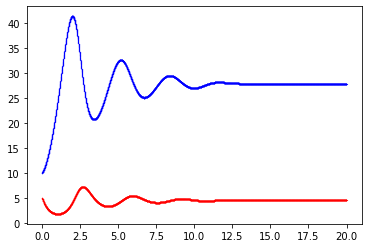

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338496.png
Epoch [44600/50000] Loss:0.000510 Loss_1:0.000004 Loss_2:0.000506 Lr:0.000219 Time:1.304880s
Epoch [44700/50000] Loss:0.000502 Loss_1:0.000001 Loss_2:0.000501 Lr:0.000219 Time:0.798409s
Epoch [44800/50000] Loss:0.000479 Loss_1:0.000000 Loss_2:0.000479 Lr:0.000218 Time:0.796863s
Epoch [44900/50000] Loss:0.004015 Loss_1:0.000185 Loss_2:0.003830 Lr:0.000218 Time:0.791954s
Epoch [45000/50000] Loss:0.000478 Loss_1:0.000000 Loss_2:0.000478 Lr:0.000217 Time:0.791852s
Testing & drawing...
u= [9.999967, 10.005005, 10.010059, 10.0151415, 10.020246, 10.025372, 10.030518, 10.035687, 10.040882, 10.046094] ... [27.807198, 27.807198, 27.8072, 27.8072, 27.8072, 27.8072, 27.8072, 27.8072, 27.8072, 27.8072]
v= [4.9999757, 4.991007, 4.982058, 4.97312, 4.9642005, 4.9552965, 4.946415, 4.937546, 4.9286947, 4.919867] ... [4.5332427, 4.5332437, 4.533244, 4.5332446, 4.53324

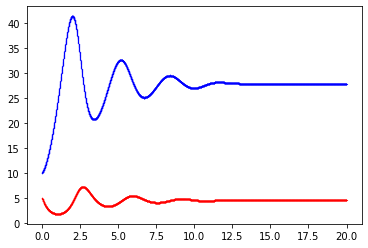

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338500.png
Epoch [45100/50000] Loss:0.001146 Loss_1:0.000083 Loss_2:0.001063 Lr:0.000217 Time:1.358545s
Epoch [45200/50000] Loss:0.000477 Loss_1:0.000000 Loss_2:0.000477 Lr:0.000216 Time:0.813545s
Epoch [45300/50000] Loss:0.000533 Loss_1:0.000002 Loss_2:0.000531 Lr:0.000216 Time:0.791029s
Epoch [45400/50000] Loss:0.000476 Loss_1:0.000000 Loss_2:0.000476 Lr:0.000216 Time:0.791798s
Epoch [45500/50000] Loss:0.000479 Loss_1:0.000000 Loss_2:0.000478 Lr:0.000215 Time:0.791342s
Testing & drawing...
u= [9.999867, 10.004904, 10.009962, 10.01504, 10.020144, 10.025269, 10.030415, 10.035585, 10.040777, 10.045989] ... [27.808033, 27.808035, 27.808035, 27.808035, 27.808035, 27.808035, 27.808035, 27.808037, 27.808037, 27.808037]
v= [4.9997096, 4.9907413, 4.981794, 4.972857, 4.963938, 4.9550357, 4.9461546, 4.9372864, 4.9284368, 4.9196095] ... [4.533389, 4.5333896, 4.5333905, 

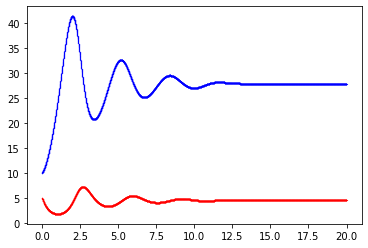

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338505.png
Epoch [45600/50000] Loss:0.000475 Loss_1:0.000000 Loss_2:0.000475 Lr:0.000215 Time:1.304142s
Epoch [45700/50000] Loss:0.000487 Loss_1:0.000000 Loss_2:0.000487 Lr:0.000214 Time:0.794012s
Epoch [45800/50000] Loss:0.000474 Loss_1:0.000000 Loss_2:0.000474 Lr:0.000214 Time:0.793449s
Epoch [45900/50000] Loss:0.000493 Loss_1:0.000000 Loss_2:0.000492 Lr:0.000213 Time:0.791253s
Epoch [46000/50000] Loss:0.000473 Loss_1:0.000000 Loss_2:0.000473 Lr:0.000213 Time:0.792432s
Testing & drawing...
u= [10.000098, 10.005133, 10.010189, 10.015271, 10.020376, 10.025503, 10.030648, 10.035819, 10.041014, 10.0462265] ... [27.807535, 27.807535, 27.807539, 27.807539, 27.807539, 27.807539, 27.807539, 27.807539, 27.807539, 27.807539]
v= [5.0000496, 4.9910793, 4.98213, 4.9731917, 4.9642696, 4.9553657, 4.946483, 4.937614, 4.928762, 4.9199333] ... [4.5332623, 4.533263, 4.533264, 

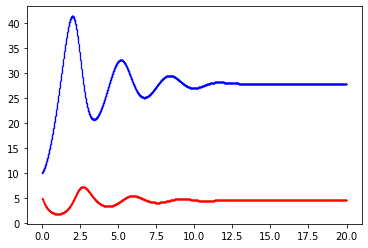

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338509.png
Epoch [46100/50000] Loss:0.000514 Loss_1:0.000005 Loss_2:0.000510 Lr:0.000212 Time:1.349617s
Epoch [46200/50000] Loss:0.000473 Loss_1:0.000000 Loss_2:0.000473 Lr:0.000212 Time:0.791250s
Epoch [46300/50000] Loss:0.000474 Loss_1:0.000000 Loss_2:0.000474 Lr:0.000211 Time:0.790989s
Epoch [46400/50000] Loss:0.006372 Loss_1:0.000435 Loss_2:0.005938 Lr:0.000211 Time:0.791508s
Epoch [46500/50000] Loss:0.000471 Loss_1:0.000000 Loss_2:0.000471 Lr:0.000211 Time:0.791339s
Testing & drawing...
u= [10.000086, 10.005123, 10.01018, 10.015259, 10.020366, 10.02549, 10.030637, 10.035809, 10.041001, 10.046214] ... [27.807432, 27.807434, 27.807434, 27.807434, 27.807434, 27.807436, 27.807436, 27.807438, 27.807438, 27.807438]
v= [5.000208, 4.9912367, 4.982288, 4.9733486, 4.964426, 4.9555206, 4.9466386, 4.9377685, 4.9289165, 4.9200883] ... [4.533184, 4.5331845, 4.5331855, 

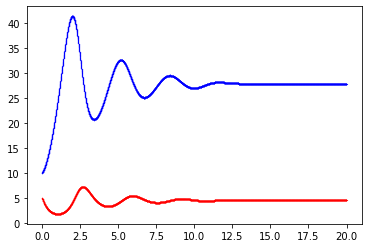

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338514.png
Epoch [46600/50000] Loss:0.000727 Loss_1:0.000037 Loss_2:0.000690 Lr:0.000210 Time:1.304225s
Epoch [46700/50000] Loss:0.000470 Loss_1:0.000000 Loss_2:0.000470 Lr:0.000210 Time:0.792689s
Epoch [46800/50000] Loss:0.000987 Loss_1:0.000053 Loss_2:0.000934 Lr:0.000209 Time:0.810014s
Epoch [46900/50000] Loss:0.000469 Loss_1:0.000000 Loss_2:0.000469 Lr:0.000209 Time:0.791276s
Epoch [47000/50000] Loss:0.000482 Loss_1:0.000002 Loss_2:0.000481 Lr:0.000208 Time:0.791322s
Testing & drawing...
u= [9.999195, 10.00423, 10.009283, 10.014362, 10.019463, 10.024585, 10.029725, 10.034894, 10.040085, 10.045293] ... [27.808765, 27.808765, 27.808765, 27.808765, 27.808765, 27.808765, 27.808765, 27.80877, 27.80877, 27.80877]
v= [4.9988995, 4.989931, 4.980984, 4.9720488, 4.9631295, 4.9542274, 4.9453473, 4.9364815, 4.927632, 4.918807] ... [4.533461, 4.533462, 4.533462, 4.5334

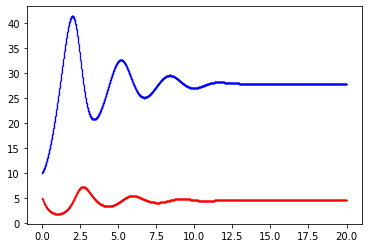

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338518.png
Epoch [47100/50000] Loss:0.000469 Loss_1:0.000000 Loss_2:0.000469 Lr:0.000208 Time:1.312085s
Epoch [47200/50000] Loss:0.000470 Loss_1:0.000000 Loss_2:0.000470 Lr:0.000207 Time:0.791816s
Epoch [47300/50000] Loss:0.000480 Loss_1:0.000001 Loss_2:0.000479 Lr:0.000207 Time:0.791132s
Epoch [47400/50000] Loss:0.000468 Loss_1:0.000000 Loss_2:0.000468 Lr:0.000207 Time:0.792946s
Epoch [47500/50000] Loss:0.000467 Loss_1:0.000000 Loss_2:0.000467 Lr:0.000206 Time:0.790943s
Testing & drawing...
u= [10.000134, 10.005172, 10.010228, 10.01531, 10.020415, 10.025541, 10.030687, 10.035858, 10.041052, 10.046265] ... [27.807745, 27.807745, 27.807745, 27.807745, 27.807745, 27.807747, 27.807747, 27.807747, 27.807747, 27.807747]
v= [5.000167, 4.9911957, 4.982245, 4.973305, 4.964382, 4.9554768, 4.9465938, 4.937722, 4.92887, 4.920042] ... [4.533167, 4.5331674, 4.533168, 4.533

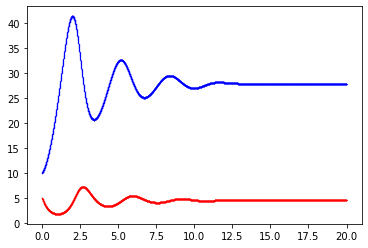

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338523.png
Epoch [47600/50000] Loss:0.000471 Loss_1:0.000000 Loss_2:0.000471 Lr:0.000206 Time:1.353760s
Epoch [47700/50000] Loss:0.000466 Loss_1:0.000000 Loss_2:0.000466 Lr:0.000205 Time:0.812052s
Epoch [47800/50000] Loss:0.000492 Loss_1:0.000003 Loss_2:0.000489 Lr:0.000205 Time:0.791364s
Epoch [47900/50000] Loss:0.000465 Loss_1:0.000000 Loss_2:0.000465 Lr:0.000204 Time:0.791763s
Epoch [48000/50000] Loss:0.000466 Loss_1:0.000000 Loss_2:0.000466 Lr:0.000204 Time:0.791159s
Testing & drawing...
u= [10.000132, 10.005169, 10.010224, 10.015306, 10.0204115, 10.025539, 10.030683, 10.035855, 10.041049, 10.046261] ... [27.807589, 27.807589, 27.807589, 27.807589, 27.807589, 27.807589, 27.807589, 27.807589, 27.807589, 27.807589]
v= [5.0002213, 4.9912505, 4.9823, 4.973361, 4.964437, 4.955531, 4.946649, 4.937778, 4.928925, 4.9200974] ... [4.5330305, 4.533031, 4.5330315, 4.5

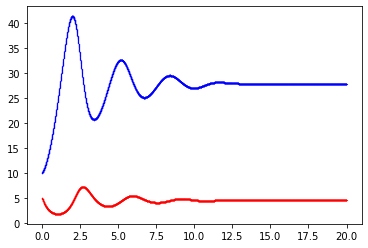

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338527.png
Epoch [48100/50000] Loss:0.000465 Loss_1:0.000000 Loss_2:0.000465 Lr:0.000204 Time:1.301425s
Epoch [48200/50000] Loss:0.000468 Loss_1:0.000000 Loss_2:0.000468 Lr:0.000203 Time:0.799068s
Epoch [48300/50000] Loss:0.000464 Loss_1:0.000000 Loss_2:0.000464 Lr:0.000203 Time:0.791247s
Epoch [48400/50000] Loss:0.000673 Loss_1:0.000025 Loss_2:0.000649 Lr:0.000202 Time:0.790775s
Epoch [48500/50000] Loss:0.000463 Loss_1:0.000000 Loss_2:0.000463 Lr:0.000202 Time:0.815594s
Testing & drawing...
u= [9.99991, 10.004946, 10.010002, 10.015081, 10.0201845, 10.025311, 10.030456, 10.035626, 10.04082, 10.046032] ... [27.80845, 27.80845, 27.80845, 27.808453, 27.808453, 27.808453, 27.808453, 27.808453, 27.808453, 27.808453]
v= [4.9998455, 4.990875, 4.981924, 4.972986, 4.9640627, 4.9551578, 4.9462748, 4.9374046, 4.9285536, 4.919726] ... [4.533199, 4.5332, 4.5332003, 4.53320

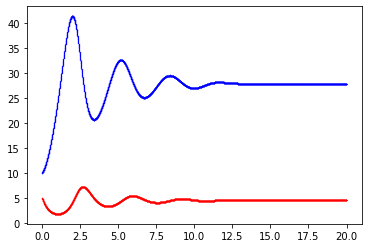

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338532.png
Epoch [48600/50000] Loss:0.000465 Loss_1:0.000000 Loss_2:0.000465 Lr:0.000202 Time:1.316022s
Epoch [48700/50000] Loss:0.003176 Loss_1:0.000136 Loss_2:0.003040 Lr:0.000201 Time:0.791419s
Epoch [48800/50000] Loss:0.000462 Loss_1:0.000000 Loss_2:0.000462 Lr:0.000201 Time:0.792605s
Epoch [48900/50000] Loss:0.000789 Loss_1:0.000029 Loss_2:0.000760 Lr:0.000200 Time:0.794493s
Epoch [49000/50000] Loss:0.000462 Loss_1:0.000000 Loss_2:0.000462 Lr:0.000200 Time:0.791585s
Testing & drawing...
u= [9.999871, 10.0049095, 10.009963, 10.015044, 10.020145, 10.02527, 10.030417, 10.035587, 10.04078, 10.04599] ... [27.808939, 27.808939, 27.808939, 27.808939, 27.808939, 27.80894, 27.80894, 27.80894, 27.80894, 27.80894]
v= [4.999708, 4.990736, 4.9817863, 4.972847, 4.9639244, 4.95502, 4.9461374, 4.937267, 4.9284163, 4.919588] ... [4.533249, 4.53325, 4.5332503, 4.533251, 4.

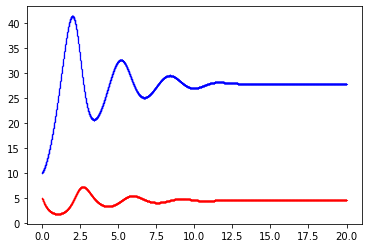

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338536.png
Epoch [49100/50000] Loss:0.000464 Loss_1:0.000000 Loss_2:0.000464 Lr:0.000200 Time:1.363997s
Epoch [49200/50000] Loss:0.002933 Loss_1:0.000276 Loss_2:0.002657 Lr:0.000199 Time:0.791437s
Epoch [49300/50000] Loss:0.000460 Loss_1:0.000000 Loss_2:0.000460 Lr:0.000199 Time:0.793459s
Epoch [49400/50000] Loss:0.001499 Loss_1:0.000034 Loss_2:0.001465 Lr:0.000198 Time:0.795640s
Epoch [49500/50000] Loss:0.000459 Loss_1:0.000000 Loss_2:0.000459 Lr:0.000198 Time:0.791773s
Testing & drawing...
u= [10.000266, 10.005301, 10.01036, 10.015441, 10.020546, 10.025671, 10.030819, 10.03599, 10.041183, 10.046396] ... [27.808807, 27.808807, 27.80881, 27.80881, 27.80881, 27.80881, 27.808811, 27.808813, 27.808813, 27.808813]
v= [5.000136, 4.9911633, 4.9822125, 4.9732714, 4.9643483, 4.9554424, 4.946559, 4.937688, 4.9288344, 4.9200068] ... [4.5331144, 4.5331144, 4.533116, 4.53

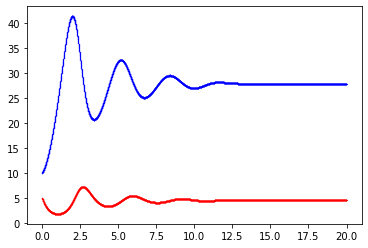

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338541.png
Epoch [49600/50000] Loss:0.001205 Loss_1:0.000076 Loss_2:0.001129 Lr:0.000198 Time:1.291301s
Epoch [49700/50000] Loss:0.000459 Loss_1:0.000000 Loss_2:0.000459 Lr:0.000197 Time:0.790930s
Epoch [49800/50000] Loss:0.002551 Loss_1:0.000107 Loss_2:0.002444 Lr:0.000197 Time:0.791130s
Epoch [49900/50000] Loss:0.000458 Loss_1:0.000000 Loss_2:0.000458 Lr:0.000196 Time:0.791638s
Epoch [50000/50000] Loss:0.000457 Loss_1:0.000000 Loss_2:0.000457 Lr:0.000196 Time:0.791569s
Testing & drawing...
u= [10.000241, 10.00528, 10.010336, 10.015418, 10.020523, 10.025647, 10.030794, 10.035966, 10.041161, 10.046373] ... [27.809002, 27.809002, 27.809002, 27.809002, 27.809002, 27.809002, 27.809002, 27.809004, 27.809004, 27.809006]
v= [5.0002465, 4.991273, 4.9823203, 4.973379, 4.9644556, 4.9555483, 4.946664, 4.937793, 4.92894, 4.9201097] ... [4.533087, 4.533087, 4.533088, 4.53

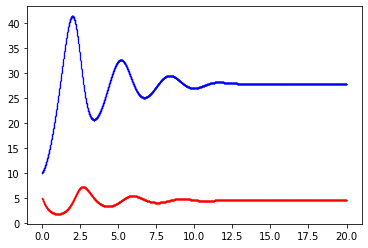

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338545.png
Testing & drawing...
u= [10.000241, 10.00528, 10.010336, 10.015418, 10.020523, 10.025647, 10.030794, 10.035966, 10.041161, 10.046373] ... [27.809002, 27.809002, 27.809002, 27.809002, 27.809002, 27.809002, 27.809002, 27.809004, 27.809004, 27.809006]
v= [5.0002465, 4.991273, 4.9823203, 4.973379, 4.9644556, 4.9555483, 4.946664, 4.937793, 4.92894, 4.9201097] ... [4.533087, 4.533087, 4.533088, 4.533088, 4.533089, 4.5330896, 4.53309, 4.533091, 4.533092, 4.533092]
x= [0.0, 0.0010001659, 0.0019997358, 0.0029999018, 0.0040000677, 0.0050002337, 0.0059998035, 0.0069999695, 0.008000135, 0.008999705] ... [19.990002, 19.991, 19.992, 19.993, 19.994, 19.995, 19.995998, 19.997002, 19.998, 19.999]


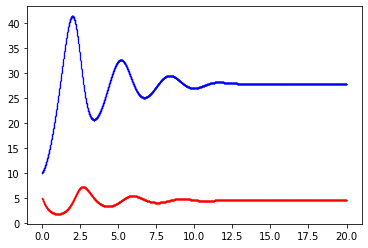

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkPP_50000_100_0.01_1.0_3.0_0.3_0.333_2022-03-26-23-41-36_1648338546.png


<Figure size 432x288 with 0 Axes>

In [ ]:
main_path = "/content/drive/My Drive/Workspace/PINN"  # you may need to alter the path if it's not here
run_pp(main_path)